In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

In [3]:
from classifier import *
from ntk import *
from Q_minimization import *
from train import *

### Define Dimensions

In [4]:
n = 100
m = 20
d = 3

### Define Dataset

In [102]:
x = np.array([[1, -0.8, -0.5], [1, -0.4, -0.5], [1, 0.15, 0.3]])
y = np.array([[1.0, -1.0, 1.0]]).reshape(-1,)

In [103]:
def create_sample():
    cluster_centers = [-0.8, 0, 0.8]
    choice = np.random.choice(cluster_centers, size=2, replace=True)
    
    y_sample = -1
    if (choice[0] != -choice[1]) and not (choice[0] == 0.8 and choice[1] == 0):
        y_sample = 1    
    
    choice += np.random.normal(loc=0, scale=0.1, size=(2,))
    x_sample = np.concatenate([np.ones((1, )), choice])

    return x_sample.reshape(1, -1), y_sample

In [104]:
# samples = [create_sample() for _ in range(n)]
# x = np.concatenate([sample[0] for sample in samples])
# y = np.array([sample[1] for sample in samples]).reshape(-1,)

### Solve L1

In [105]:
w_0 = np.random.normal(loc=0, scale=1, size=(m, d))
a_0 = np.random.normal(loc=0, scale=1, size=(m,))

In [106]:
w_opt_L1, a_opt_L1 = solver(x, y, w_0, a_0, m, d, obj='L1')
w_opt_L1, a_opt_L1

(array([[ 2.66449734e-04,  7.09049218e-04, -1.41206685e-03],
        [ 3.34737854e-01, -7.55673148e-01,  1.27398855e+00],
        [-1.63109928e-02, -5.20874119e-02,  9.02507984e-03],
        [ 1.22078147e-01,  2.86041506e-01, -5.49955210e-01],
        [ 9.07008192e-02, -2.04672350e-01,  3.44708229e-01],
        [-9.63508859e-03, -3.04144163e-02,  4.72376066e-03],
        [-2.05664257e-04,  5.36180193e-04, -4.41010022e-04],
        [ 1.64774474e-02, -3.89993565e-02,  6.38104239e-02],
        [ 2.03062369e-01,  4.75977214e-01, -9.14850377e-01],
        [-5.13203599e-01, -1.60364426e+00,  2.56511137e-01],
        [ 1.11217569e-02,  2.55106347e-02, -4.96759552e-02],
        [ 1.30526090e-01,  3.06004400e-01, -5.88079482e-01],
        [ 7.09597324e-04,  1.89934486e-03, -3.68749373e-03],
        [ 1.93652216e-03,  4.94361572e-03, -9.19398275e-03],
        [-3.60205395e-04,  8.46944798e-04,  1.46647809e-04],
        [ 4.16204159e-02, -9.29589794e-02,  1.57564421e-01],
        [ 1.19951445e-03

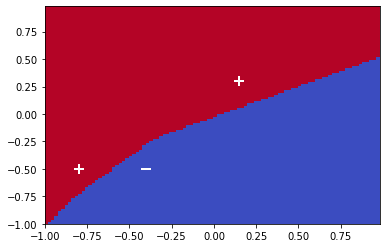

In [107]:
plot_classifier(w_opt_L1, a_opt_L1, x, y)

In [108]:
w_tilde_norms_opt_L1 = calc_w_tilde_norms(w_opt_L1, a_opt_L1)

In [109]:
np.linalg.norm(w_tilde_norms_opt_L1, ord=1)

7.6572679589420085

In [110]:
minimal_margin(w_opt_L1, a_opt_L1, x, y)

0.9999991827581018

In [111]:
np.linalg.norm(w_tilde_norms_opt_L1, ord=2) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1)

0.5128592365064363

### Empirical Gradient Flow

In [74]:
alpha = [10000] * m 
s = [0.95] * m

w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, symmetric=True)
results = train(
    w_0=w_0,
    a_0=a_0,
    x=x,
    y=y,
    m=m,
    d=d,
    alpha=alpha,
    s=s,
    step_size=1e-6,
    n_epochs=50000000,
    eval_freq=100,
    eval_freq_Q=np.inf)

100%|██████████| 50000000/50000000 [41:49<00:00, 19926.31it/s]  


##### Estimate Q over specific mu values

In [77]:
training_loss_Q = []
w_array_Q = []
a_array_Q = []

for mu_val in tqdm([1e-4, 1e-3, 0.01, 0.1, 0.5, 1, 2, 5, 10, 25, 50, 100, 200, 300, 400, 500, 1000]):
    mu = [mu_val] * m

    NUM_RERIES = 5
    best_Q_val_so_far = np.inf
    for retry in range(NUM_RERIES):
        try:
            w_opt_Q, a_opt_Q = solver(
                x,
                y,
                w_0,
                a_0,
                m,
                d,
                obj='Q',
                mu=mu,
                s=s,
                x0=np.random.normal(size=(m * (d + 1),)),
                optim_tol=1e-7
            )

           
            Q_val = Q_func(w_opt_Q, a_opt_Q, mu, s)
            if (Q_val < best_Q_val_so_far):
                best_Q_val_so_far = Q_val
                w_best_Q = w_opt_Q
                a_best_Q = a_opt_Q
                
        except Exception as e:
            print(f'Mu = {mu[0]}:: {e}')            

    training_loss_Q.append(2 * alpha[0] / mu_val)
    w_array_Q.append(w_best_Q)
    a_array_Q.append(a_best_Q)

 12%|█▏        | 2/17 [02:41<19:50, 79.39s/it]

Mu = 0.001:: Minimization Failed.


100%|██████████| 17/17 [06:31<00:00, 23.04s/it]


##### Plot weights norms over time

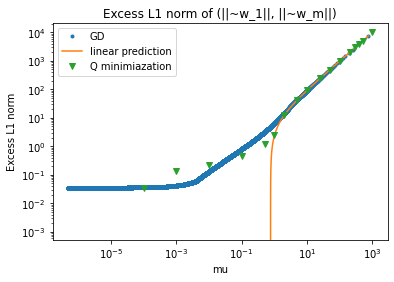

In [78]:
plot(
    [2 * alpha[0]/t for t in results['training_loss']],
    [np.linalg.norm(r, ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for r in results['w_tilde_norms']],
    '.')

plot(
    [2 * alpha[0]/t for t in results['training_loss']],
    [m * alpha[0] / t - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) for t in results['training_loss']])

plot(
    [2 * alpha[0]/t for t in training_loss_Q],
    [np.linalg.norm(calc_w_tilde_norms(w, a), ord=1) - np.linalg.norm(w_tilde_norms_opt_L1, ord=1) 
     for w, a in zip(w_array_Q, a_array_Q)],
    'v')

yscale('log')
xscale('log')
ylabel('Excess L1 norm')
xlabel('mu');
title(f'Excess L1 norm of (||~w_1||, ||~w_m||)');
legend(['GD', 'linear prediction', 'Q minimiazation']);

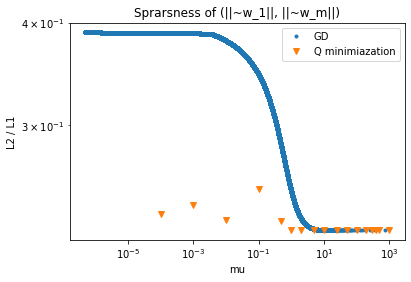

In [79]:
plot(
    [2 * alpha[0]/t for t in results['training_loss']],
    [np.linalg.norm(r, ord=2) / np.linalg.norm(r, ord=1) for r in results['w_tilde_norms']],
    '.')

plot(
    [2 * alpha[0]/t for t in training_loss_Q],
    [[np.linalg.norm(calc_w_tilde_norms(w, a), ord=2) / np.linalg.norm(calc_w_tilde_norms(w, a), ord=1)] 
      for w, a in zip(w_array_Q, a_array_Q)],
    'v')

yscale('log')
xscale('log')
ylabel('L2 / L1')
xlabel('mu');
title(f'Sprarsness of (||~w_1||, ||~w_m||)');
legend(['GD', 'Q minimiazation']);

In [ ]:
plot(
    [2 * alpha[0]/t for t in results['training_loss']],
    [Q_func(w / minimal_margin(w, a, x, y), a.reshape(-1, 1), [2 * alpha[0]/t] * m, s)
     for t, w, a in zip(results['training_loss'], results['w'], results['a'])],
    '.')

plot(
    [2 * alpha[0]/t for t in training_loss_Q],
    [Q_func(w, a.reshape(-1, 1), [2 * alpha[0]/t] * m, s) for t, w, a in zip(training_loss_Q, w_array_Q, a_array_Q)],
    '.')

ylim([-100, 100])
xscale('log')
ylabel('Q_alpha^s value')
xlabel('mu');
title(f'Q_alpha^s value');
legend(['GD', 'Q minimiazation']);

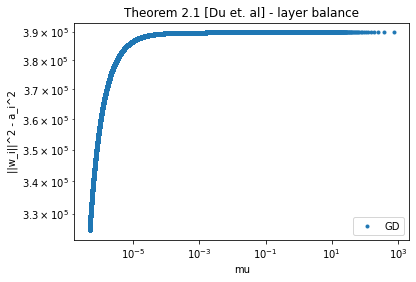

In [118]:
plot(
    [2 * alpha[0]/t for t in results['training_loss']],
    [np.mean(np.abs(a)**2 - np.linalg.norm(w, ord=2, axis=1)**2)for w, a in zip(results['w'], results['a'])],
    '.')

yscale('log')
xscale('log')
ylabel('||w_i||^2 - a_i^2')
xlabel('mu');
title(f'Theorem 2.1 [Du et. al] - layer balance');
legend(['GD']);

##### Plot NTK kerel change over time

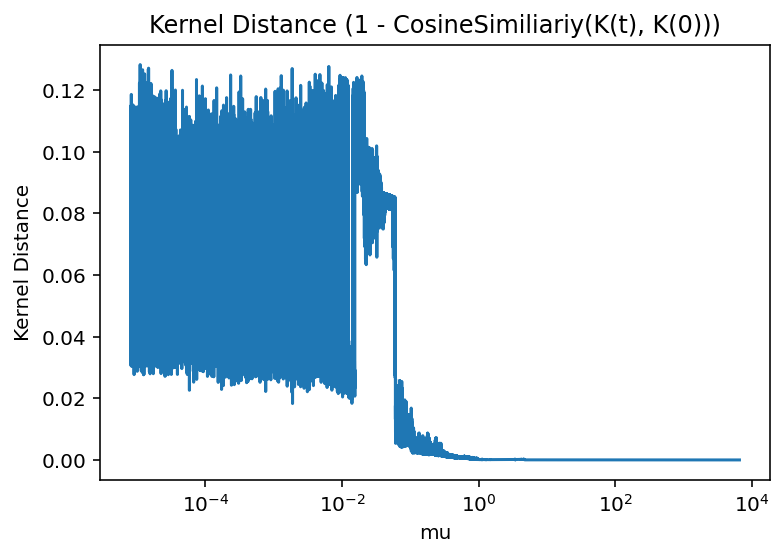

In [828]:
kernel_distances_smooth = pd.Series(results['kernel_distances']).rolling(10).mean()
plot([2 * alpha[0]/t for t in results['training_loss']], kernel_distances_smooth)
#yscale('log')
xscale('log')
ylabel('Kernel Distance')
xlabel('mu');
title(f'Kernel Distance (1 - CosineSimiliariy(K(t), K(0)))');

##### Plot decision boundary over time

In [341]:
mu_vals = [2 * alpha[0]/t for t in results['training_loss']]
max(mu_vals), min(mu_vals)

(32752.107015328555, 0.951500637785371)

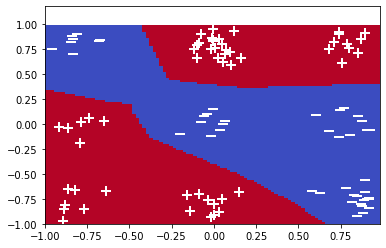

In [347]:
plot_classifier(results['w'][-1], results['a'][-1], x, y)

mu = 32752.107015328555


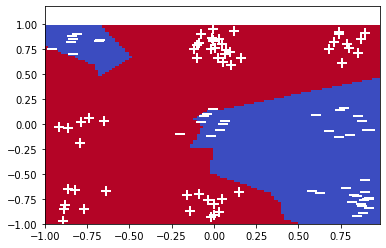

mu = 830.6128407002916


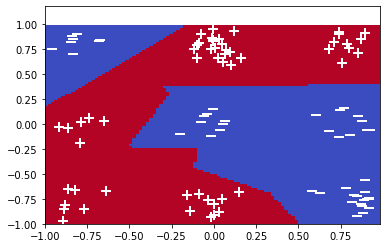

mu = 452.299296831174


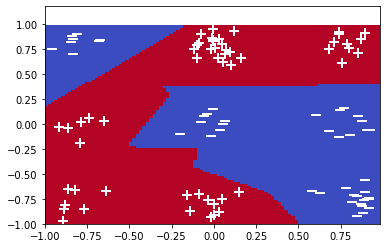

mu = 311.1225435131193


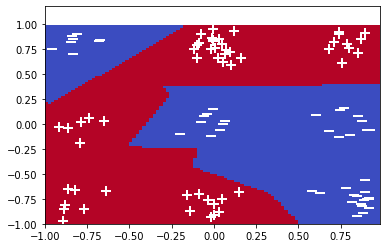

mu = 237.19598888929727


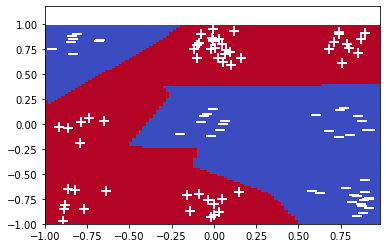

mu = 191.68581372801512


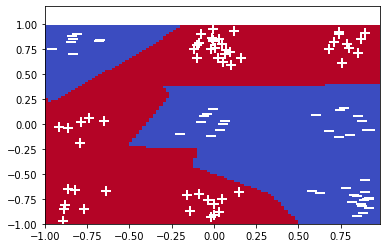

mu = 160.8387081270156


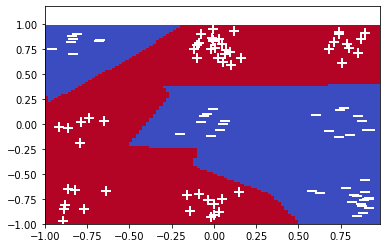

mu = 138.54651598155542


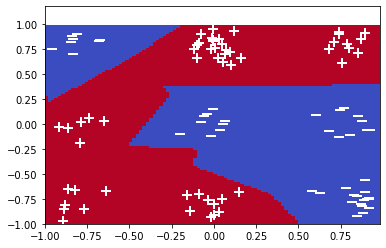

mu = 121.68164770051733


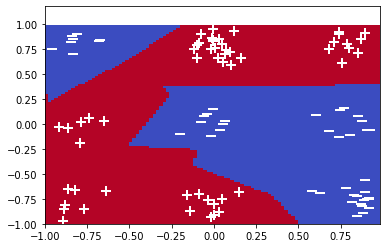

mu = 108.4762692378429


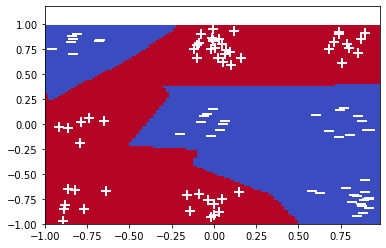

mu = 97.8554665512172


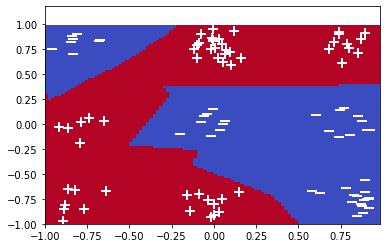

mu = 89.12789292222995


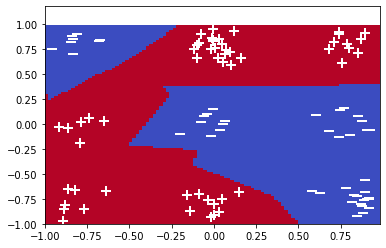

mu = 81.82863152422001


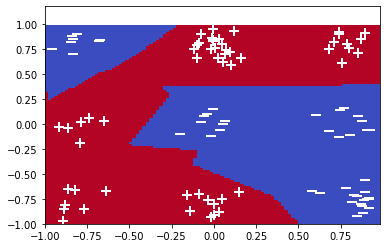

mu = 75.63348824635692


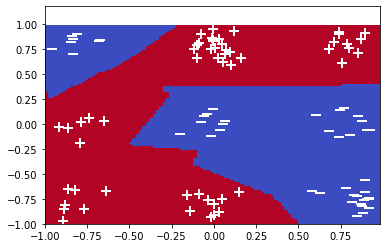

mu = 70.3094861647455


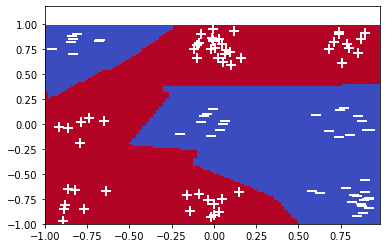

mu = 65.6848893677731


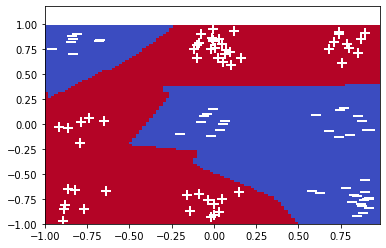

mu = 61.63032031312738


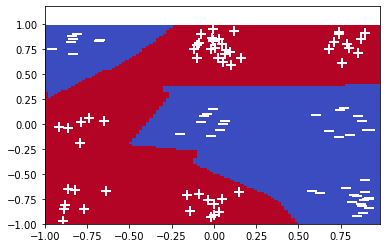

mu = 58.04645847054944


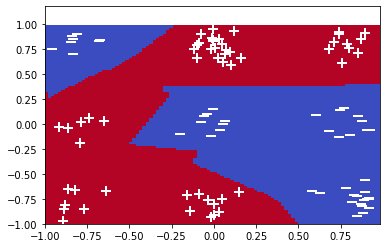

mu = 54.855790768718904


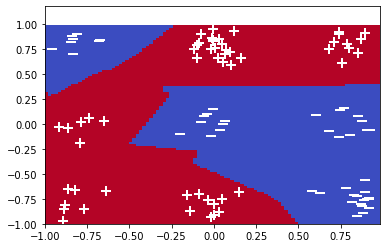

mu = 51.99693776471613


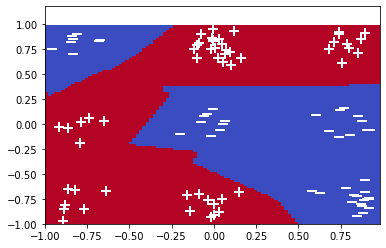

mu = 49.420663670274614


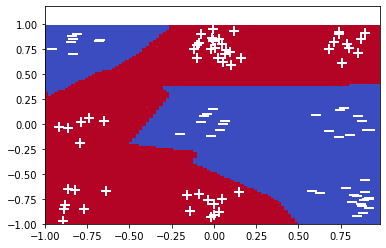

mu = 47.08701588036718


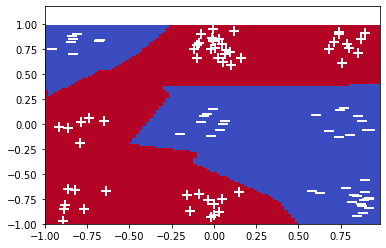

mu = 44.963721251556606


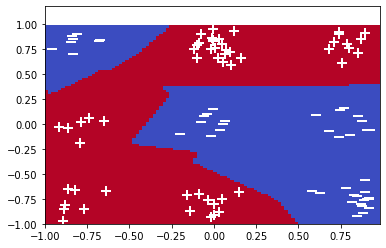

mu = 43.03030725043812


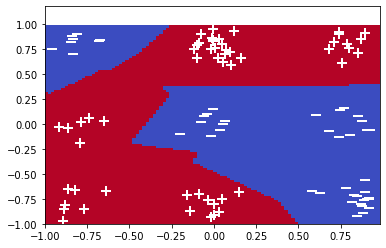

mu = 41.258299305748544


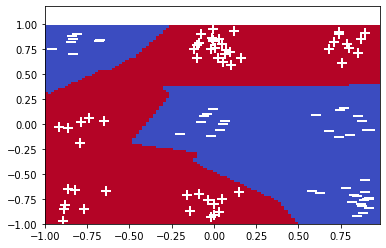

mu = 39.626181994398344


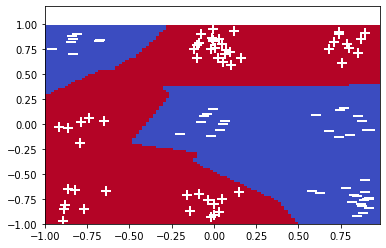

mu = 38.117904902584314


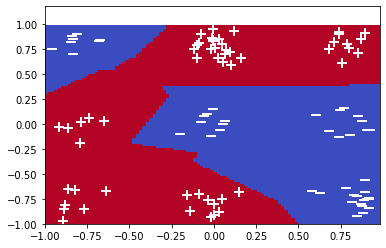

mu = 36.71985358817136


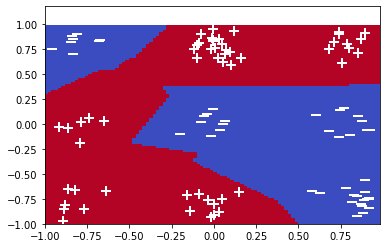

mu = 35.42034924959718


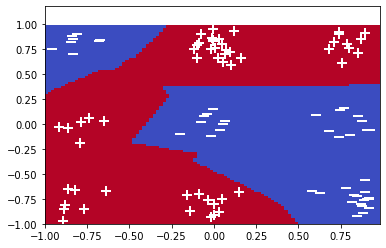

mu = 34.20930961024027


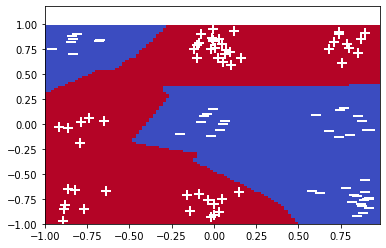

mu = 33.07798348415823


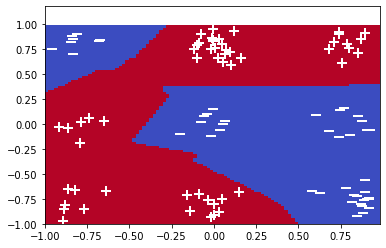

mu = 32.01873759720658


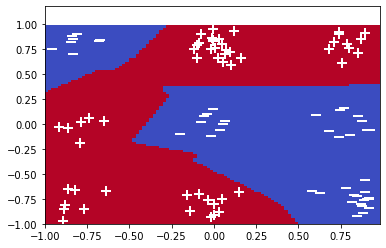

mu = 31.02488339402678


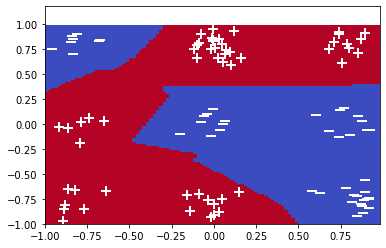

mu = 30.123656641259217


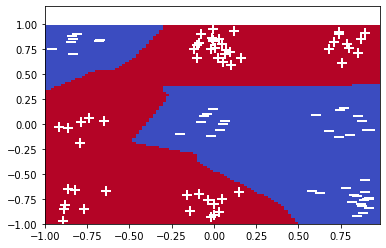

mu = 29.31232798948847


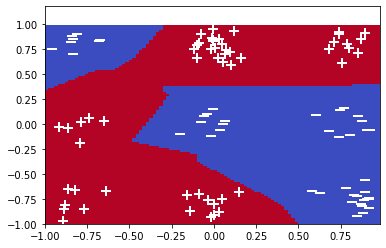

mu = 28.543217489937078


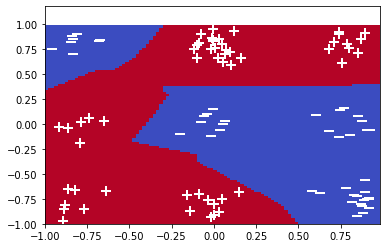

mu = 27.813097738971834


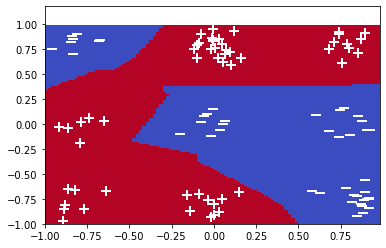

mu = 27.119068652295482


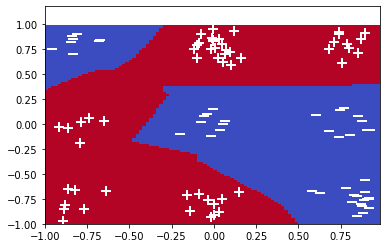

mu = 26.458510829803


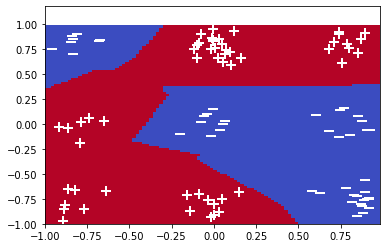

mu = 25.82905238900381


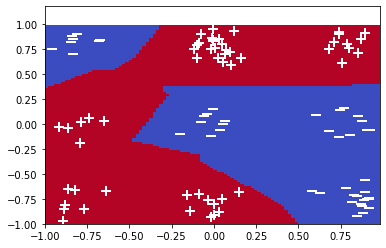

mu = 25.22854040229739


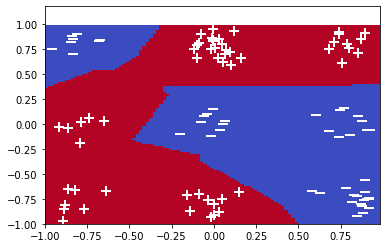

mu = 24.655016200983738


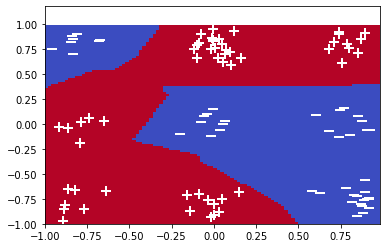

mu = 24.106693948518092


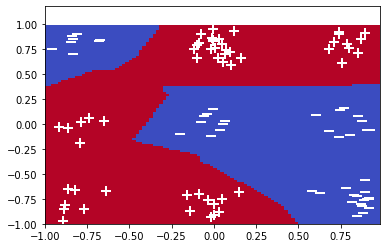

mu = 23.5819419887989


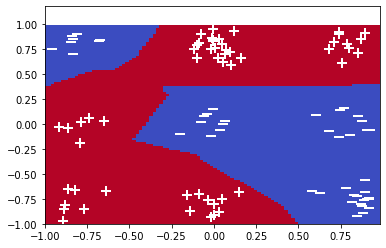

mu = 23.079266558938436


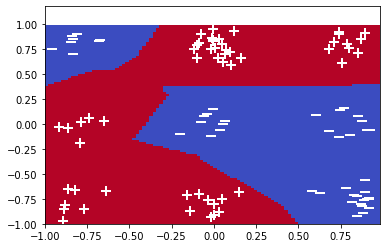

mu = 22.597297523991966


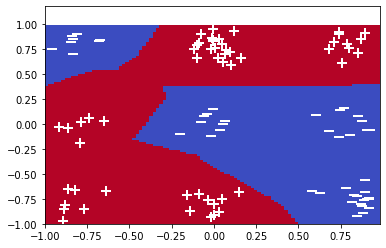

mu = 22.134775846727255


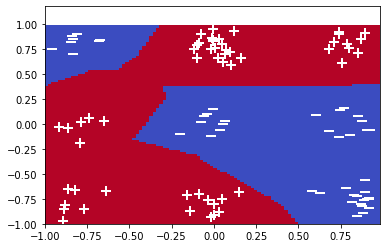

mu = 21.69054255110879


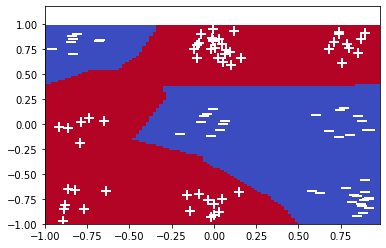

mu = 21.263528975799648


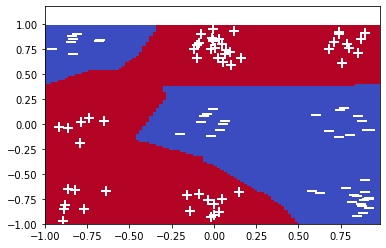

mu = 20.852748145131546


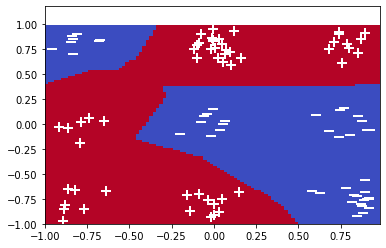

mu = 20.457287110858214


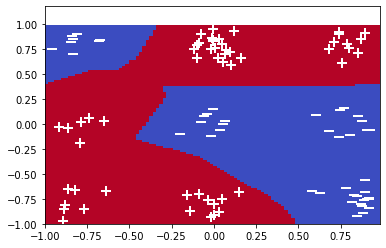

mu = 20.076300139631265


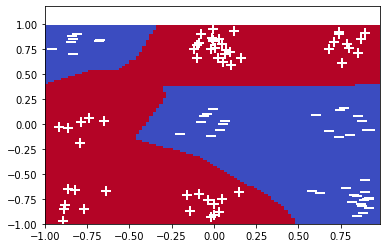

mu = 19.70900263919657


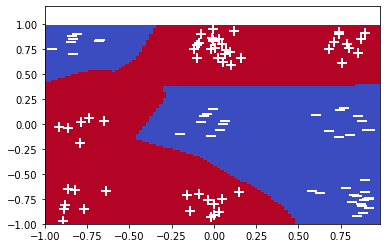

mu = 19.354665731523685


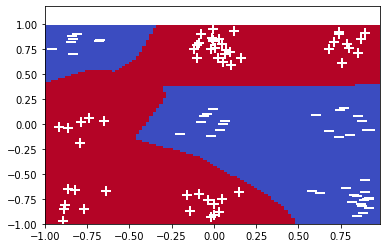

mu = 19.012611393871268


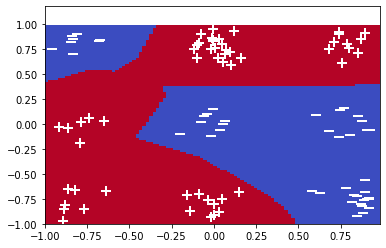

mu = 18.68220809964941


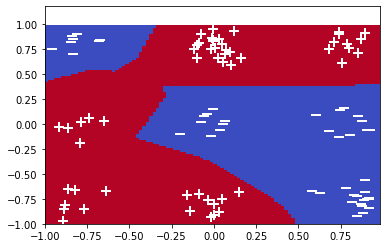

mu = 18.362866900089983


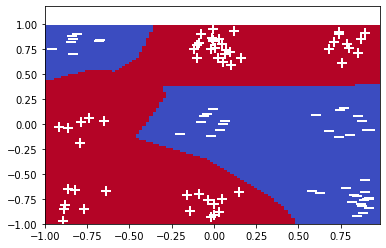

mu = 18.054037895606015


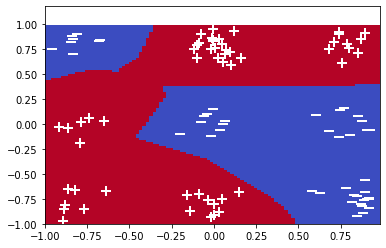

mu = 17.755207052342016


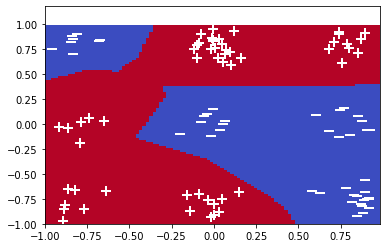

mu = 17.46589332516736


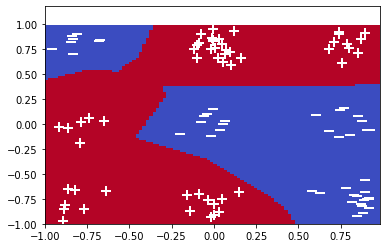

mu = 17.185646053224573


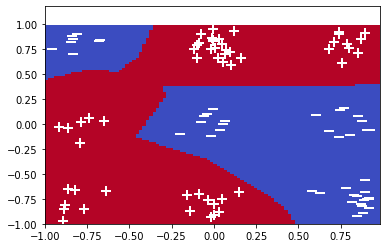

mu = 16.914042598391624


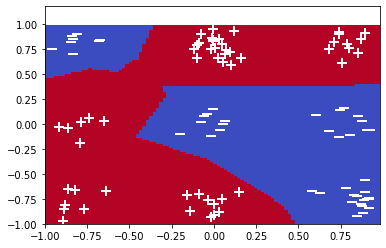

mu = 16.650686200623532


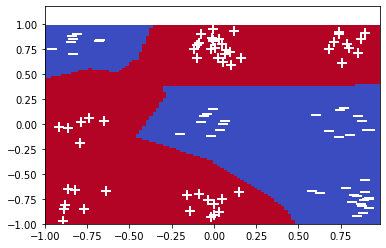

mu = 16.39520402728429


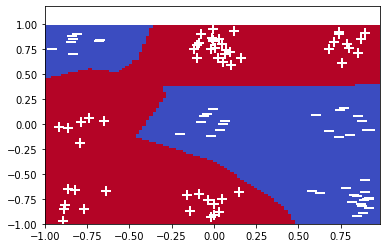

mu = 16.14724539630511


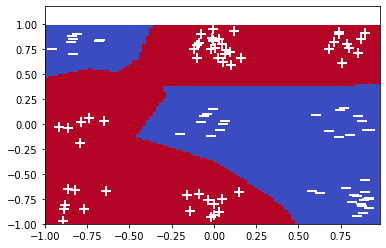

mu = 15.906480155361129


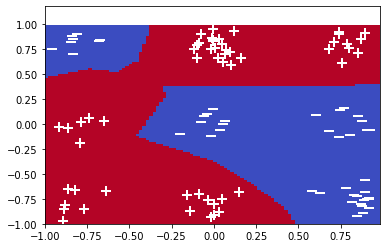

mu = 15.672597201315822


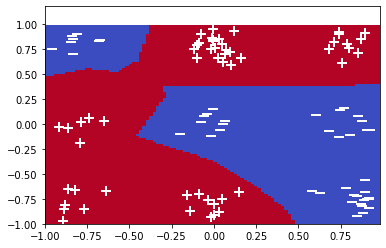

mu = 15.44530312596667


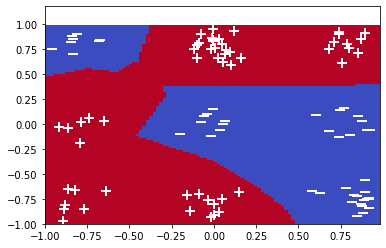

mu = 15.224320975707062


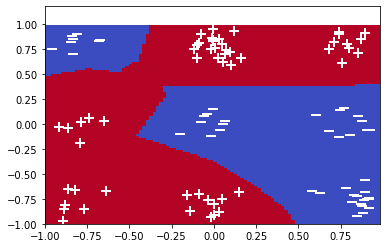

mu = 15.009389114072464


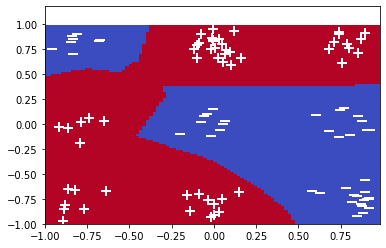

mu = 14.800260177352405


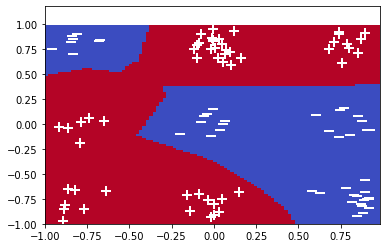

mu = 14.596700114504538


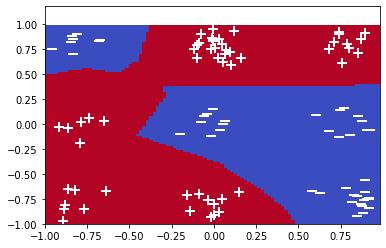

mu = 14.39848730353903


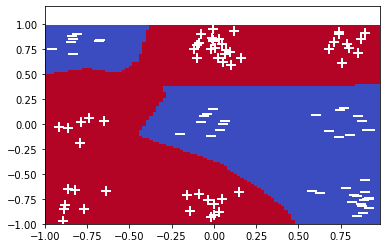

mu = 14.205411737355389


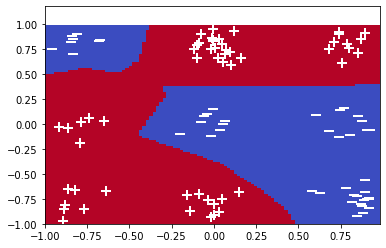

mu = 14.017274272750067


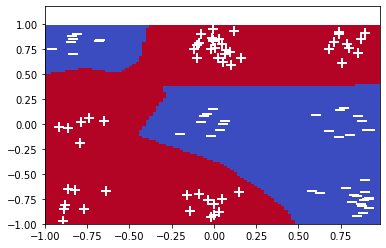

mu = 13.833885936947205


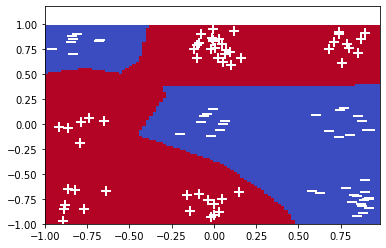

mu = 13.655067286578


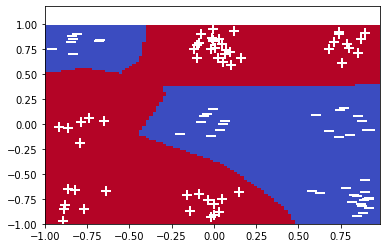

mu = 13.480667465803675


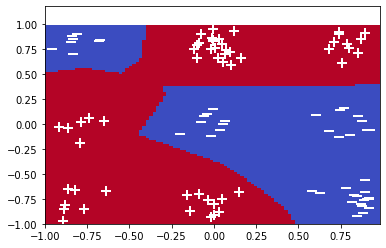

mu = 13.31626421671721


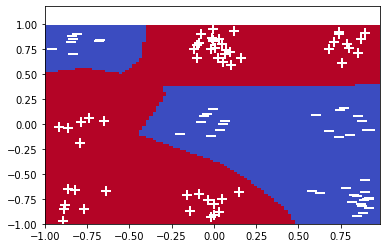

mu = 13.156606231407983


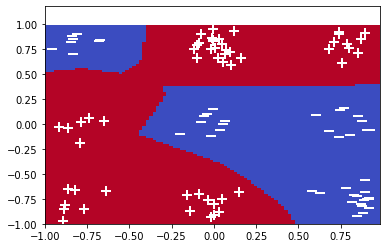

mu = 13.00052499075656


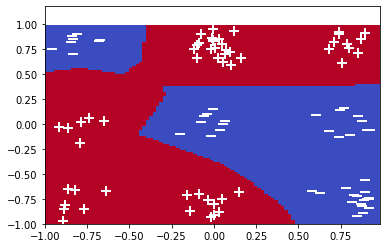

mu = 12.847895742998446


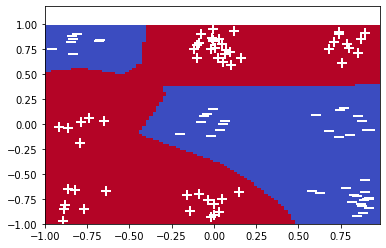

mu = 12.698603950594086


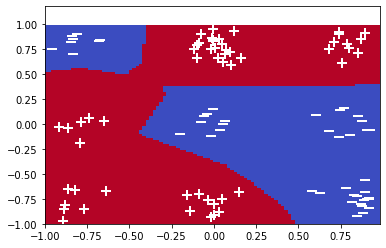

mu = 12.55254018837348


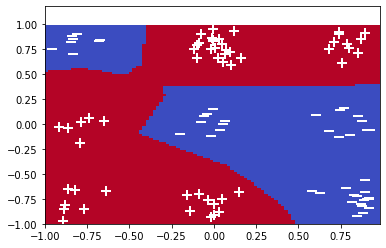

mu = 12.409599771705341


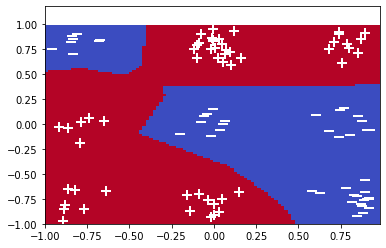

mu = 12.269682500468983


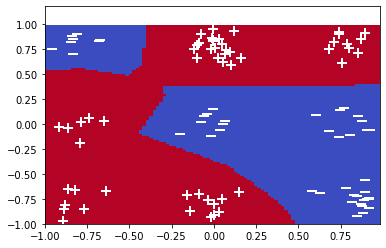

mu = 12.133580199361855


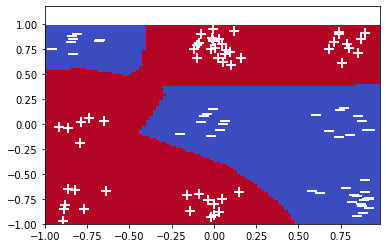

mu = 12.010153471644678


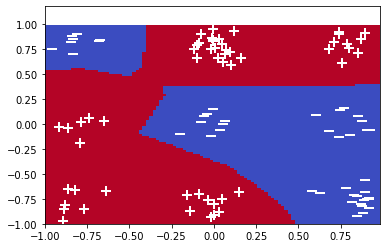

mu = 11.889081923005044


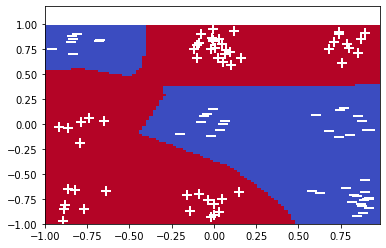

mu = 11.770297055824775


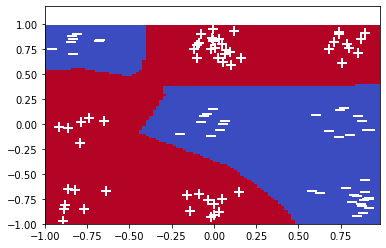

mu = 11.653734793931944


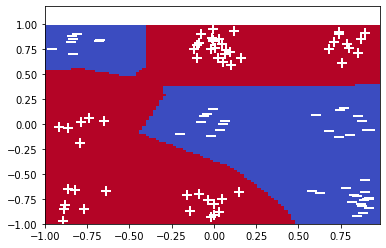

mu = 11.539332498182834


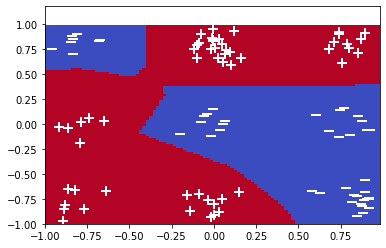

mu = 11.42702798755518


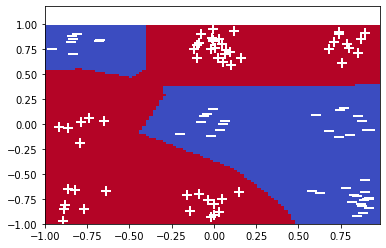

mu = 11.316765103829335


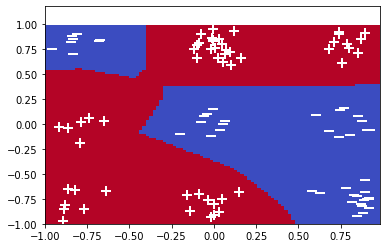

mu = 11.208486073546975


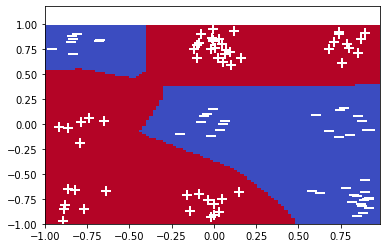

mu = 11.102139426363461


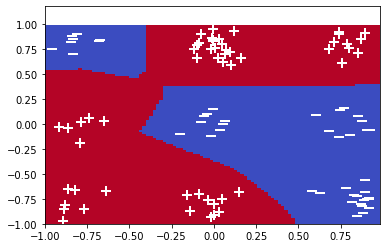

mu = 10.997671370608785


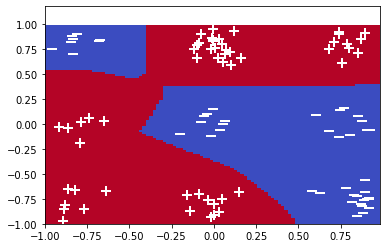

mu = 10.895031942667522


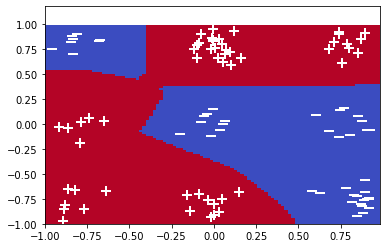

mu = 10.794173726150127


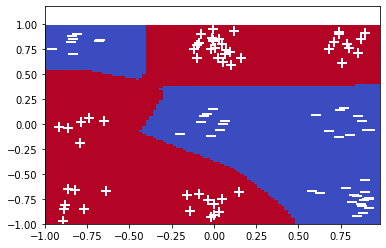

mu = 10.695048798800974


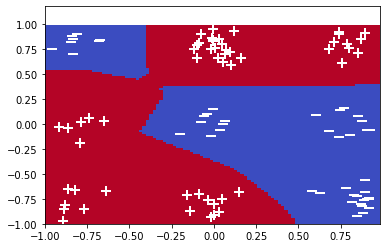

mu = 10.59772382327783


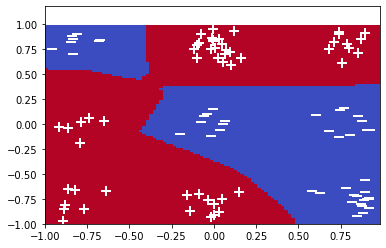

mu = 10.501333351614424


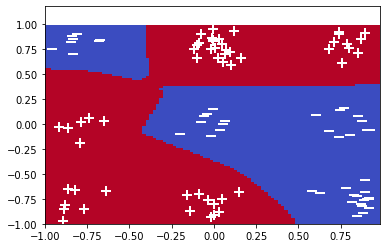

mu = 10.40417947812272


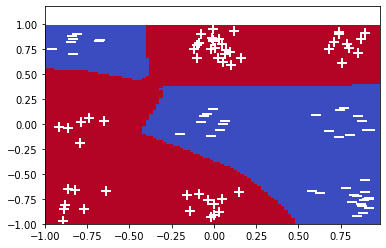

mu = 10.30876356825575


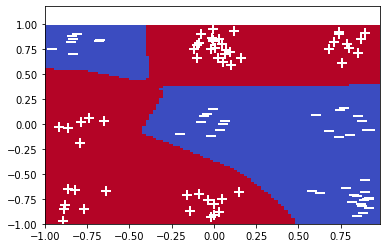

mu = 10.21500495135359


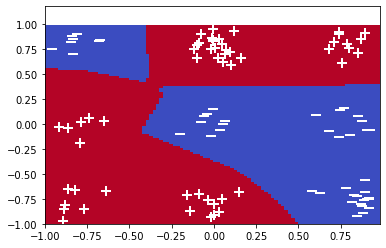

mu = 10.093080456823419


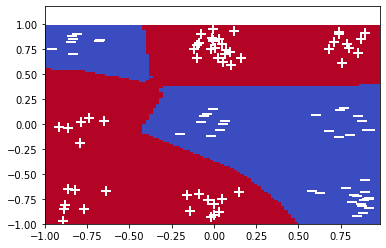

mu = 9.951768882816578


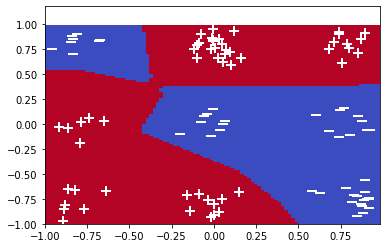

mu = 9.814259822596375


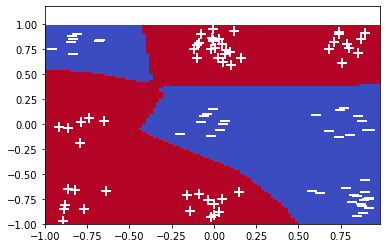

mu = 9.680345579808547


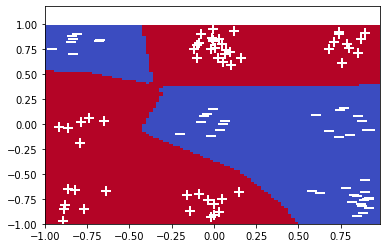

mu = 9.549883782525685


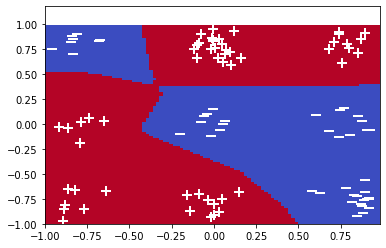

mu = 9.422740425027635


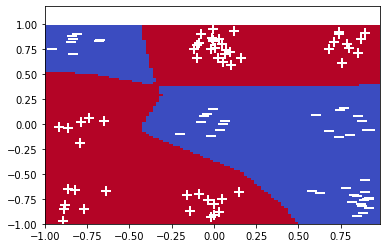

mu = 9.298788470655278


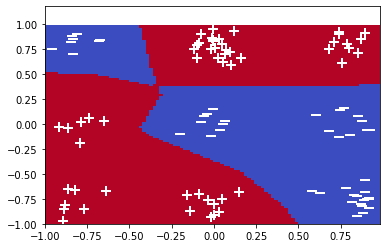

mu = 9.177907774560644


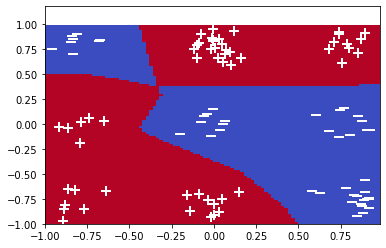

mu = 9.063701154083251


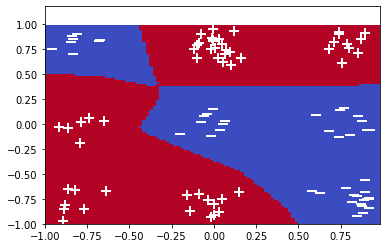

mu = 8.957617651681595


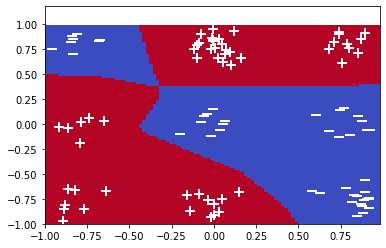

mu = 8.865168251922922


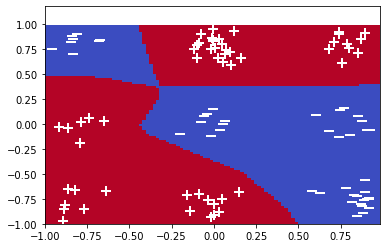

mu = 8.781397382866762


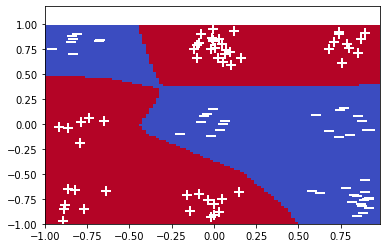

mu = 8.699162993084206


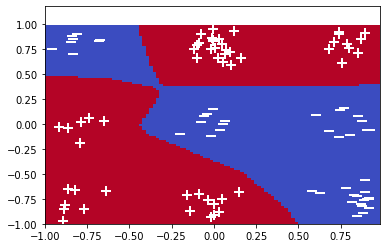

mu = 8.61841572861409


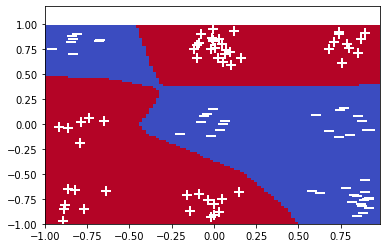

mu = 8.53911283526238


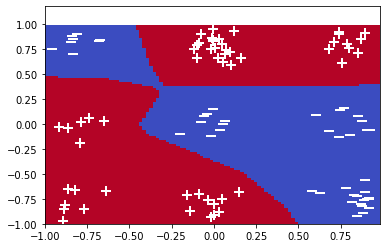

mu = 8.461213563933738


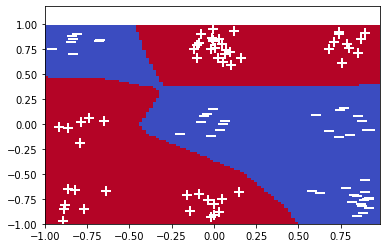

mu = 8.384678349033006


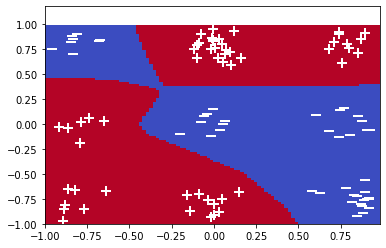

mu = 8.309469450760083


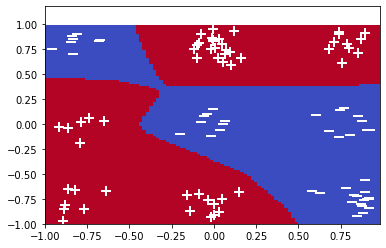

mu = 8.235550227620257


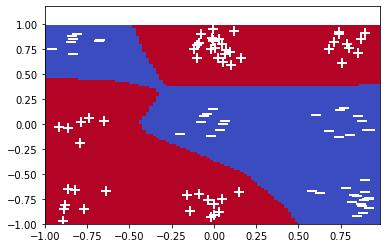

mu = 8.162885385629792


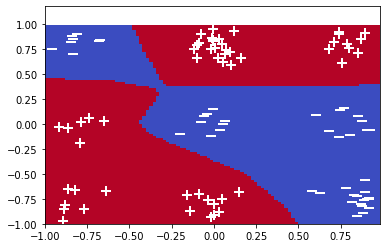

mu = 8.091441067001151


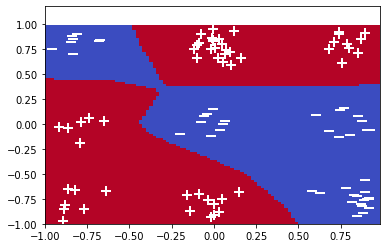

mu = 8.021184573968371


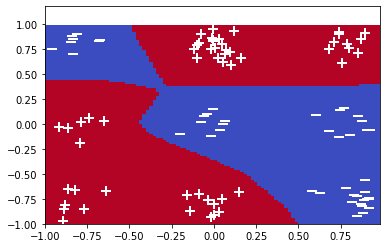

mu = 7.952084266124049


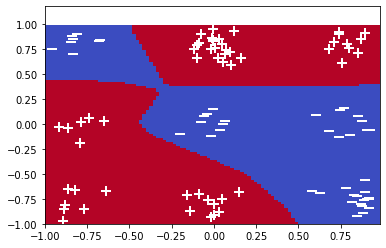

mu = 7.903784432752563


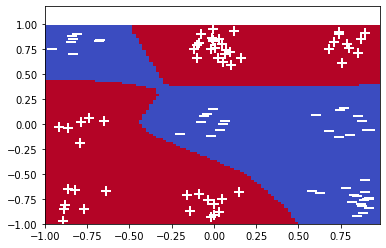

mu = 7.859256486223665


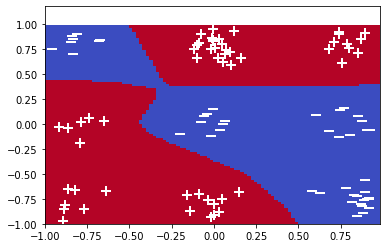

mu = 7.8152146455251685


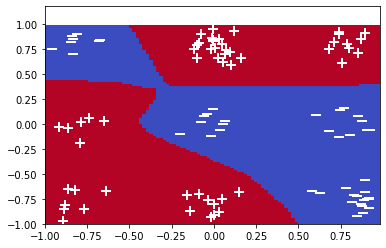

mu = 7.771649697891786


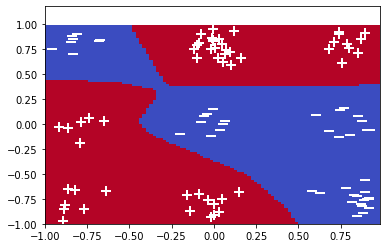

mu = 7.728554267200369


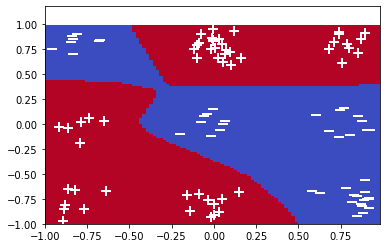

mu = 7.68591973714377


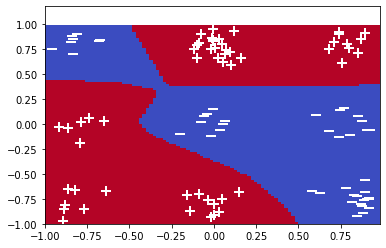

mu = 7.643738243370001


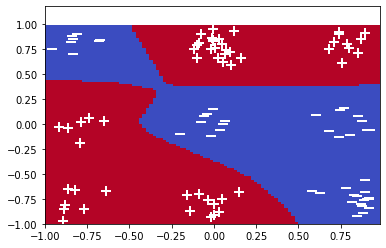

mu = 7.602002123287684


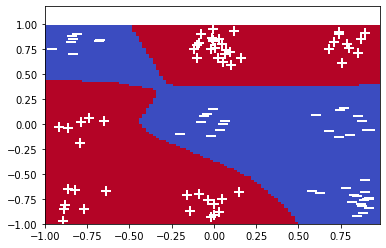

mu = 7.5607043745587665


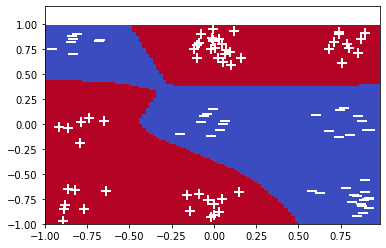

mu = 7.519836716913579


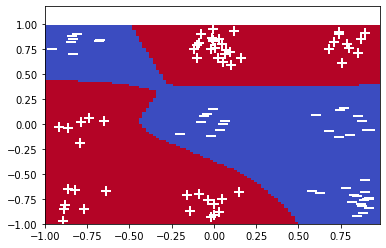

mu = 7.479392150276803


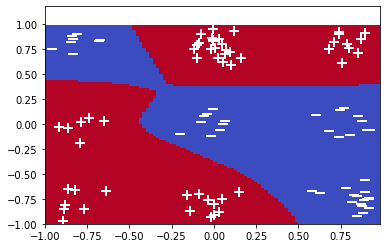

mu = 7.439364398374815


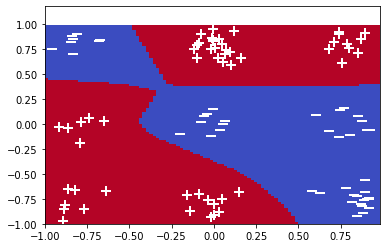

mu = 7.399745701121278


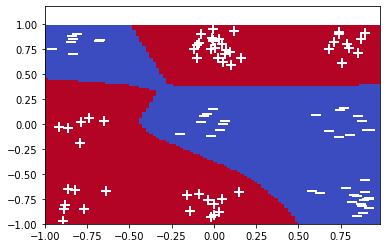

mu = 7.360529386023831


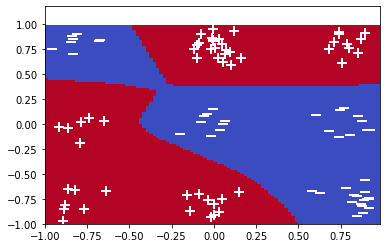

mu = 7.32170961081375


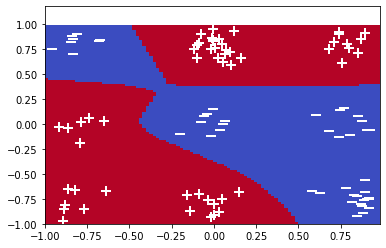

mu = 7.283279348152691


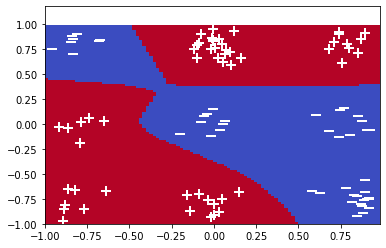

mu = 7.245232271480513


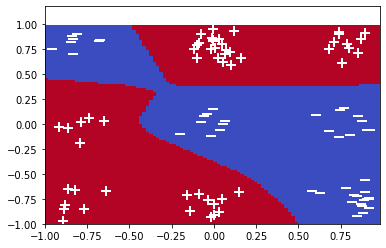

mu = 7.207562147498362


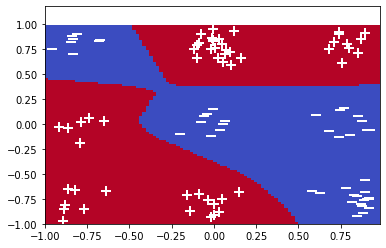

mu = 7.170262989460208


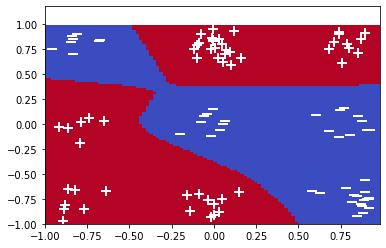

mu = 7.133329503527127


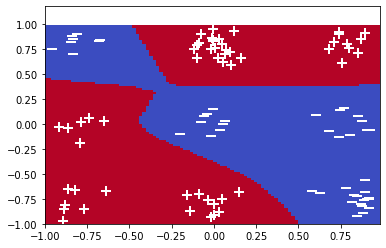

mu = 7.096756108764098


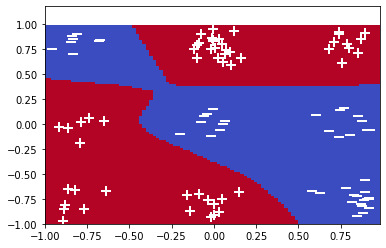

mu = 7.060553186189591


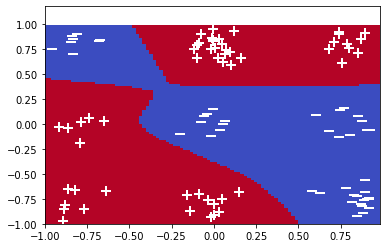

mu = 7.024728881771092


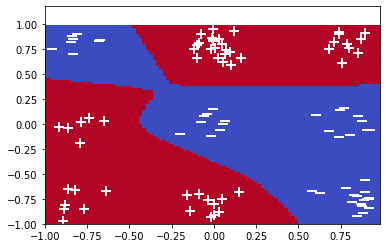

mu = 6.989248390672225


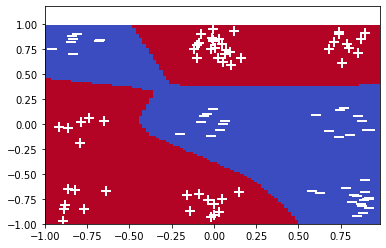

mu = 6.95410387260976


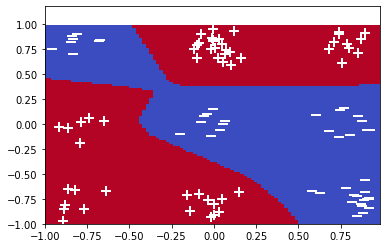

mu = 6.919290147632621


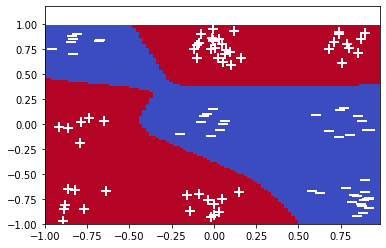

mu = 6.884802087985762


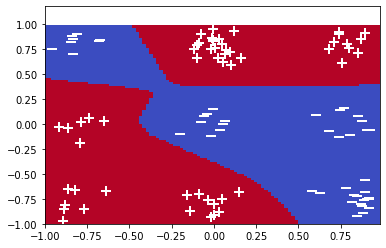

mu = 6.850634778723008


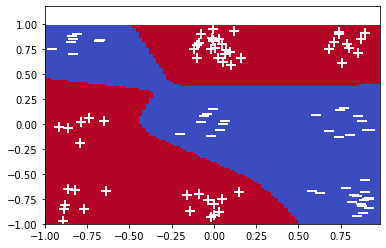

mu = 6.81678335876389


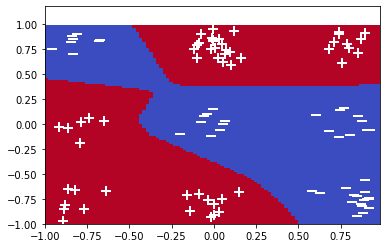

mu = 6.783243082860846


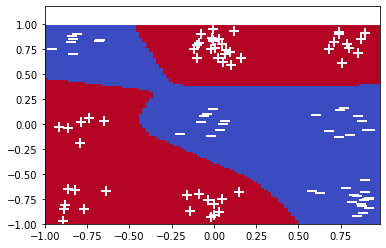

mu = 6.750009295448231


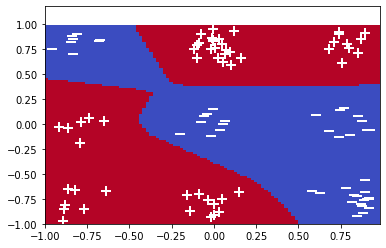

mu = 6.717077437294502


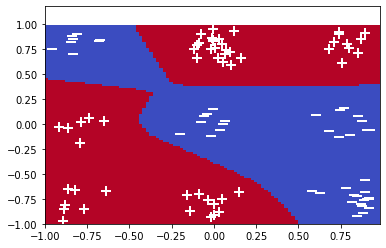

mu = 6.684443041191225


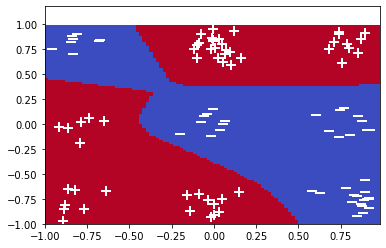

mu = 6.652101720440944


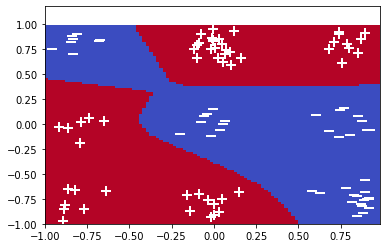

mu = 6.620049180188412


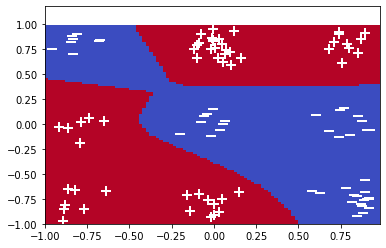

mu = 6.588281163331303


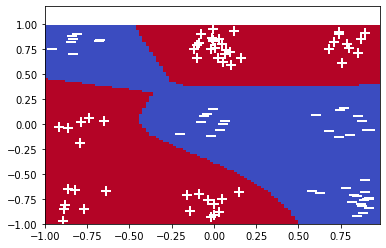

mu = 6.556792998097925


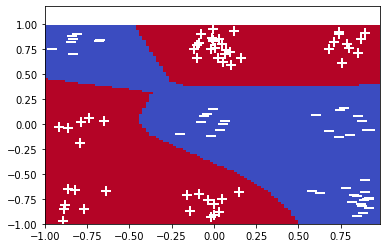

mu = 6.525581592853689


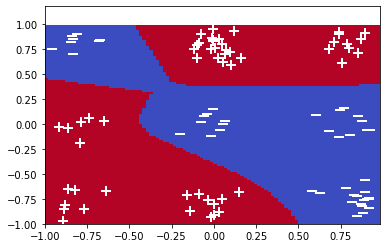

mu = 6.494642435501579


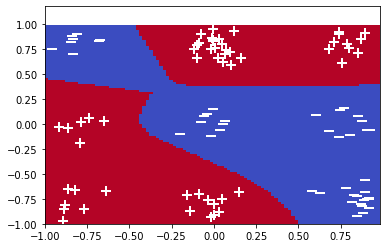

mu = 6.463971478910807


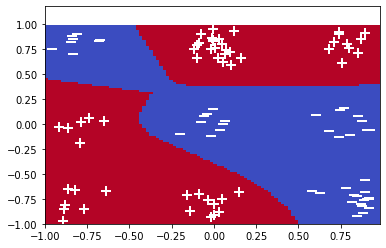

mu = 6.433564735685748


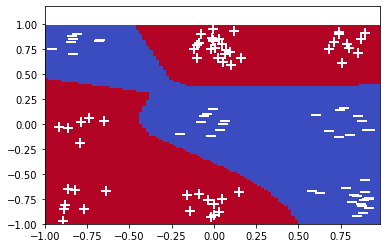

mu = 6.403419472046104


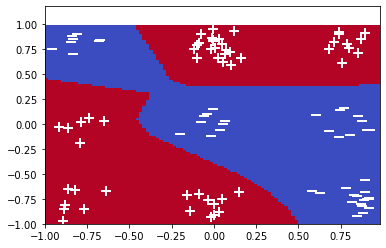

mu = 6.373530855047655


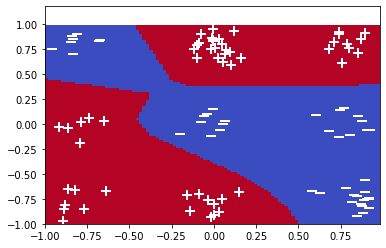

mu = 6.343895889328327


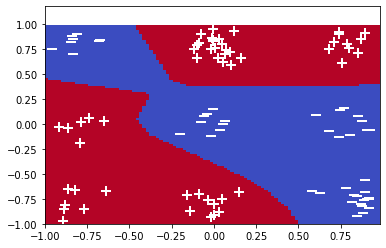

mu = 6.314510431432307


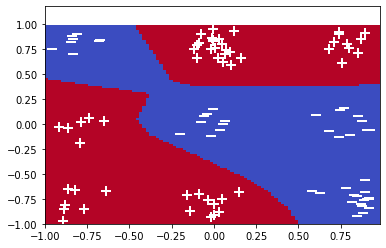

mu = 6.2853717330402405


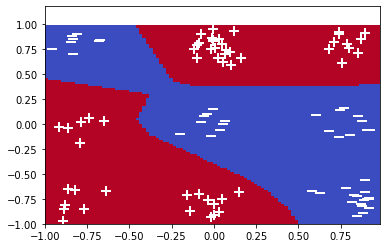

mu = 6.256475988848517


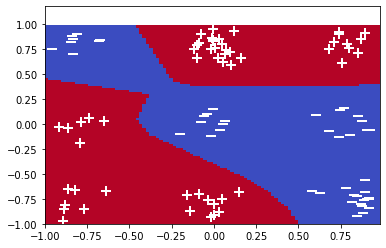

mu = 6.227820113449558


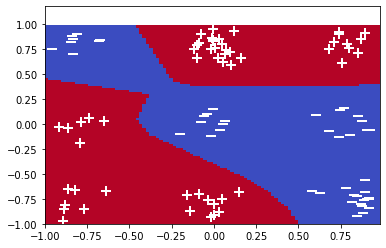

mu = 6.199400335334382


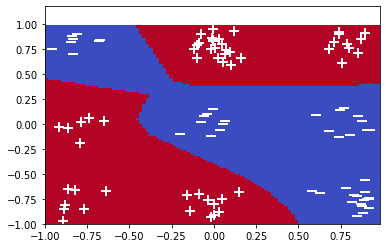

mu = 6.171213506802934


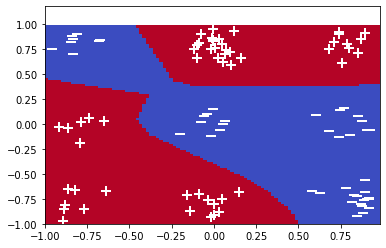

mu = 6.1432567229364246


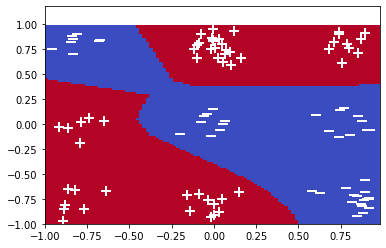

mu = 6.115527014275882


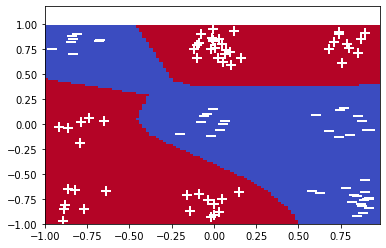

mu = 6.088020751489203


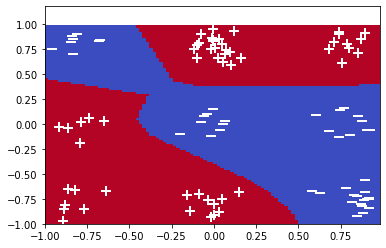

mu = 6.060735364410701


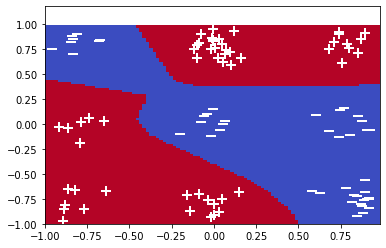

mu = 6.033667760502801


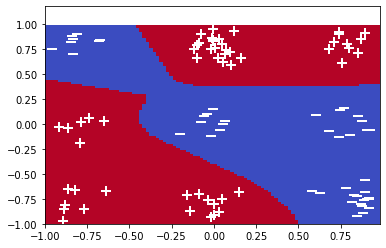

mu = 6.010955993996361


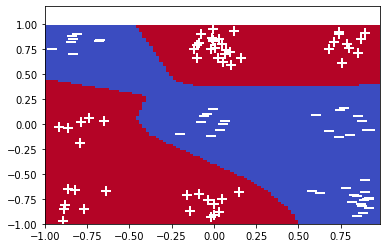

mu = 5.9887183825930315


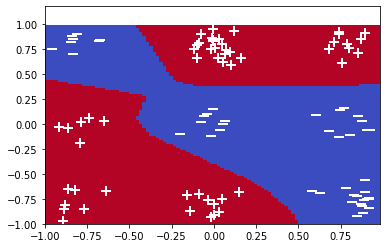

mu = 5.966616182361718


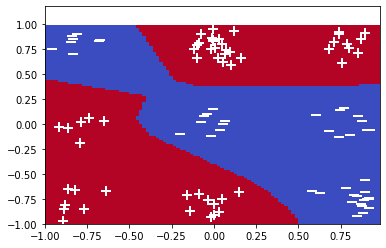

mu = 5.944648576450748


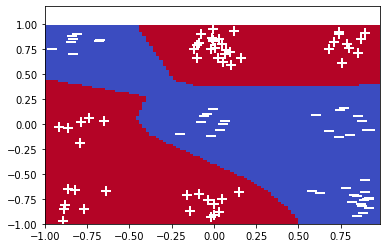

mu = 5.922813745322629


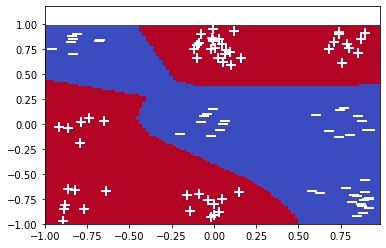

mu = 5.901110879794595


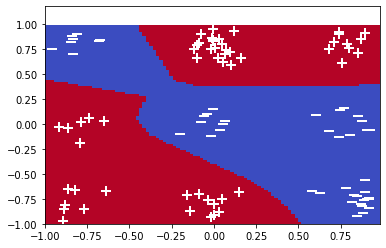

mu = 5.879537867972144


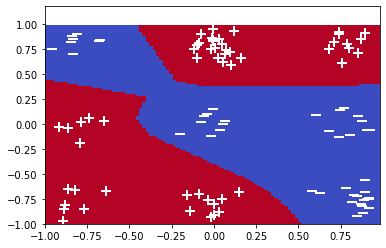

mu = 5.858094108111378


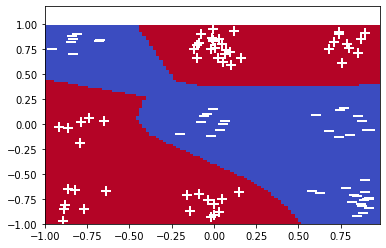

mu = 5.836777767914435


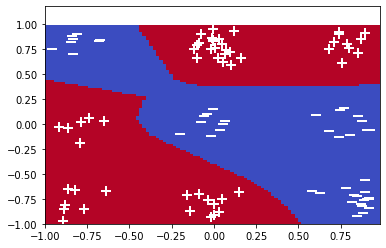

mu = 5.815588137945476


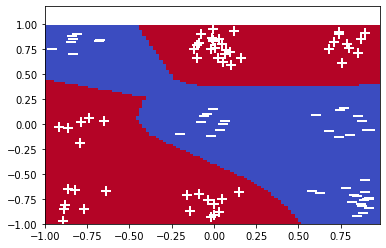

mu = 5.79452354208425


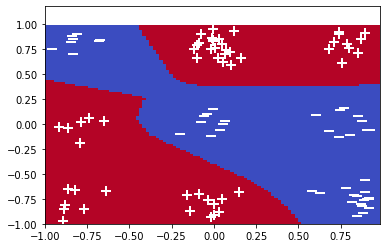

mu = 5.773582977090712


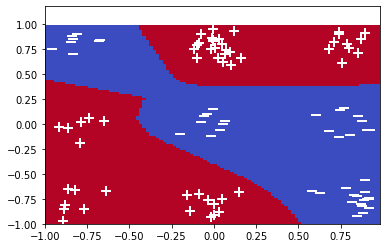

mu = 5.752764700400913


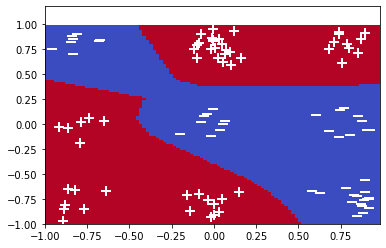

mu = 5.732068588936679


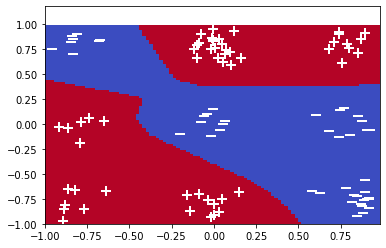

mu = 5.711492323134491


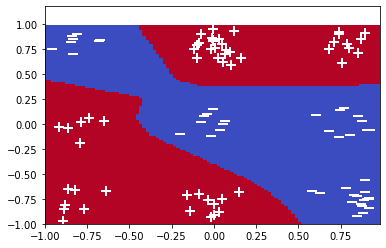

mu = 5.6910322043708526


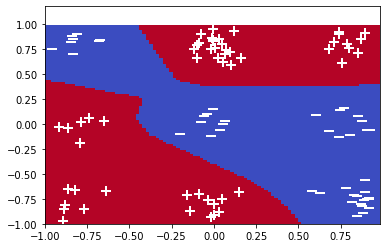

mu = 5.664458313593621


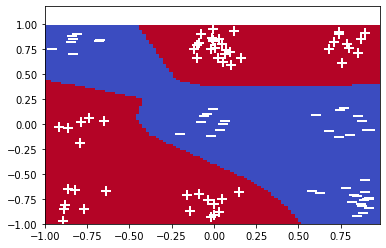

mu = 5.638145952696805


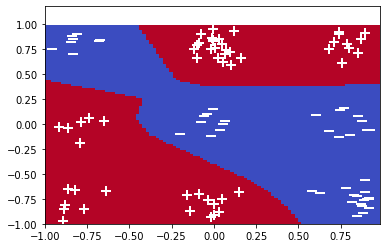

mu = 5.612038701127915


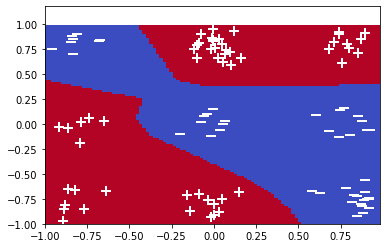

mu = 5.587327017113935


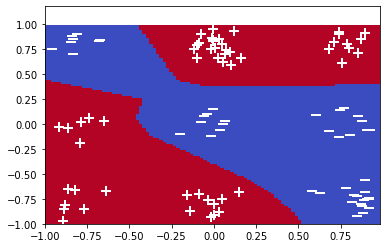

mu = 5.562971815881034


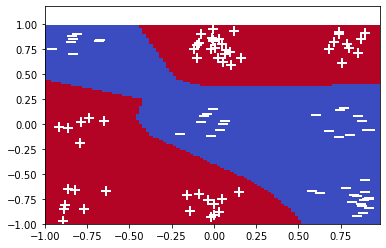

mu = 5.538790177337566


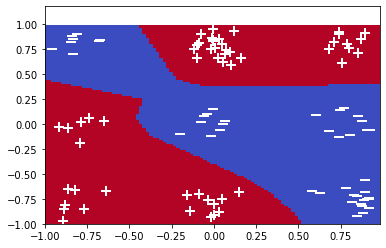

mu = 5.514779868672367


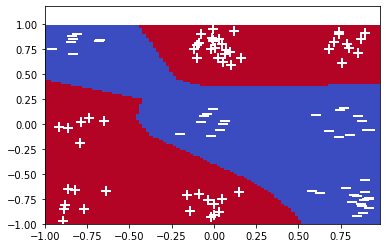

mu = 5.490938110989558


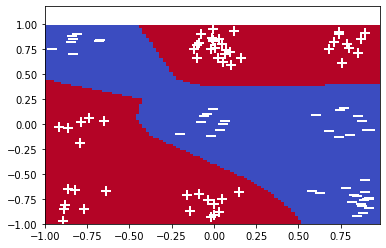

mu = 5.47195085871233


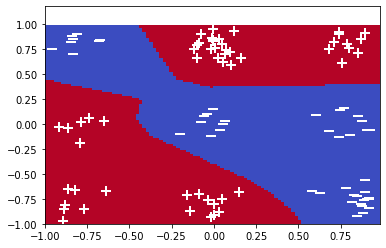

mu = 5.4572354948042765


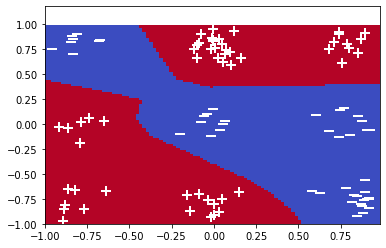

mu = 5.442892977647194


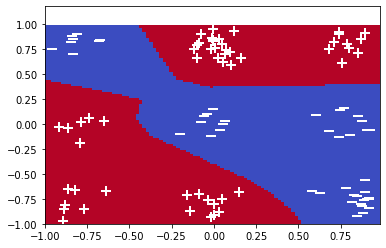

mu = 5.428625323803252


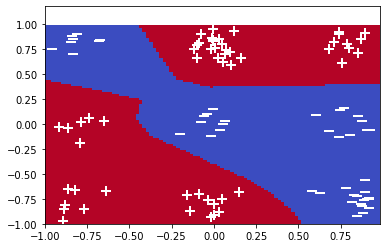

mu = 5.41440758031154


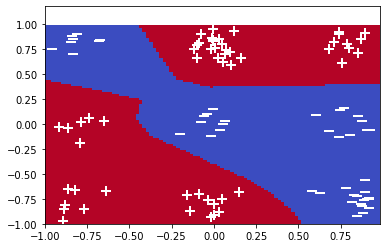

mu = 5.400236547116017


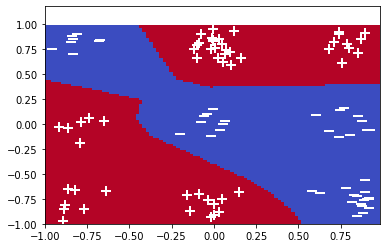

mu = 5.386111501315451


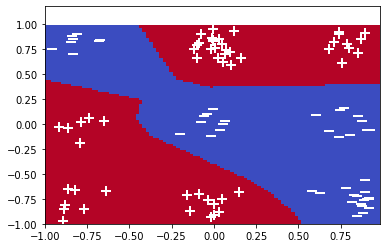

mu = 5.3720320542288675


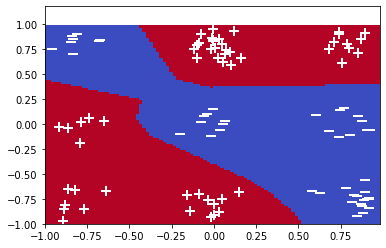

mu = 5.357998073195566


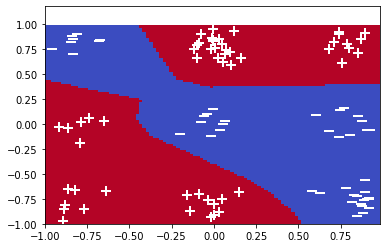

mu = 5.344009338971712


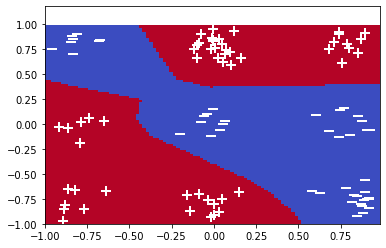

mu = 5.3300656977610155


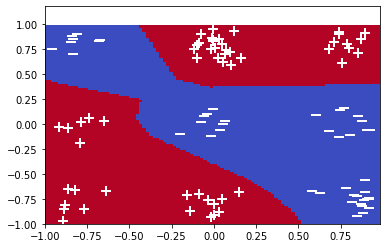

mu = 5.316166691882347


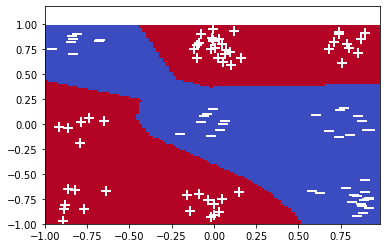

mu = 5.3023127398339


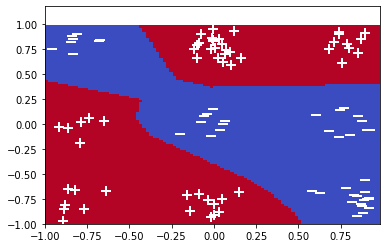

mu = 5.28850307350496


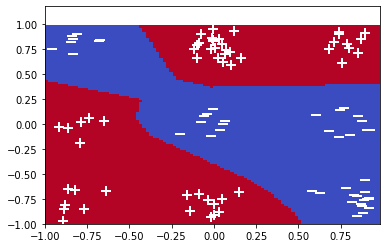

mu = 5.274737692829806


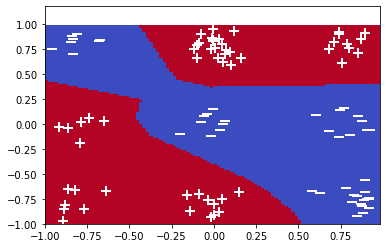

mu = 5.261016461648217


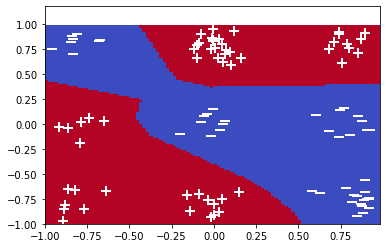

mu = 5.2473391480071445


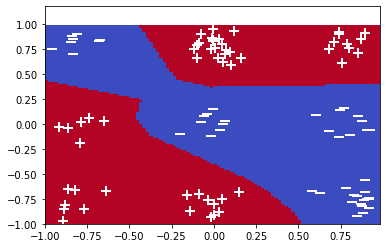

mu = 5.23370539059325


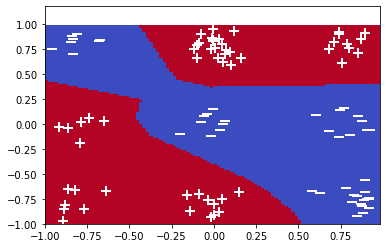

mu = 5.220115456287165


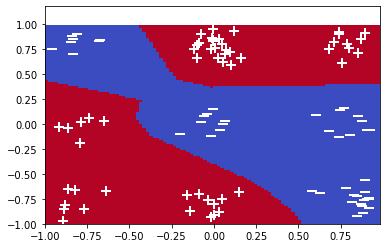

mu = 5.206568805077356


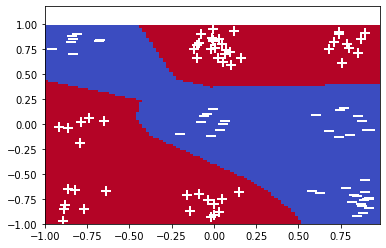

mu = 5.193065155666956


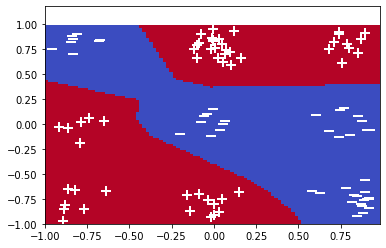

mu = 5.179604519273379


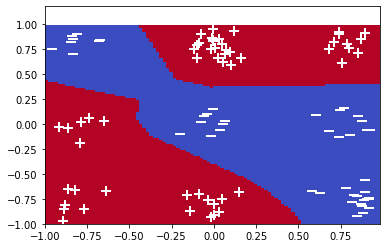

mu = 5.1661867639756425


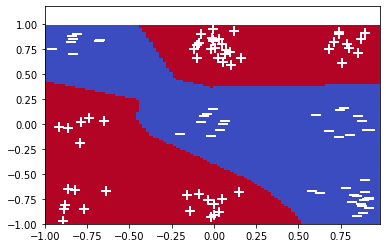

mu = 5.152811654975348


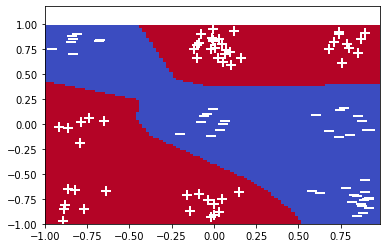

mu = 5.139479011663844


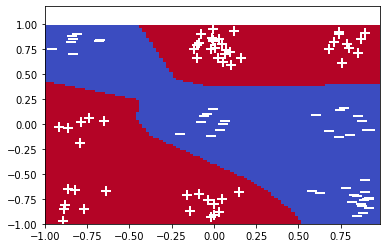

mu = 5.126188624354401


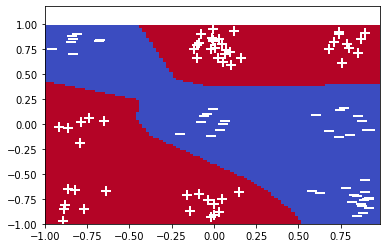

mu = 5.112940231465466


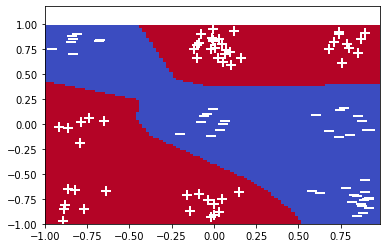

mu = 5.099733655236905


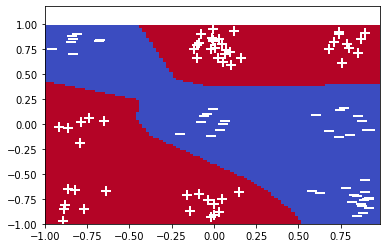

mu = 5.086569183082534


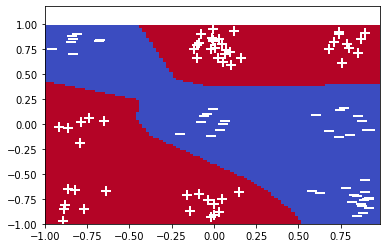

mu = 5.073445807856189


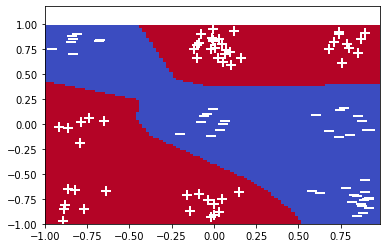

mu = 5.060364243767001


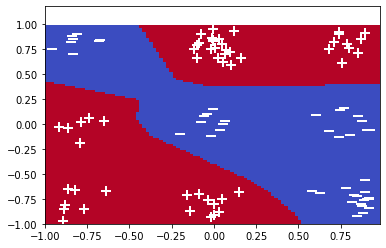

mu = 5.047323587200719


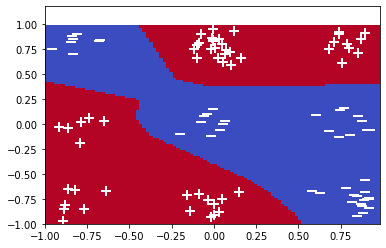

mu = 5.034324012362088


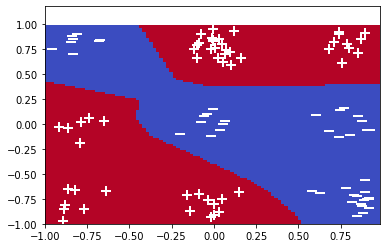

mu = 5.021365344998899


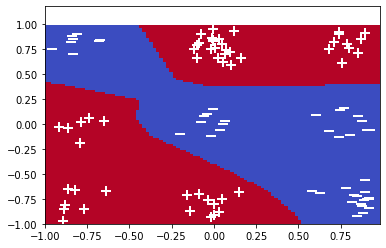

mu = 5.008447452052821


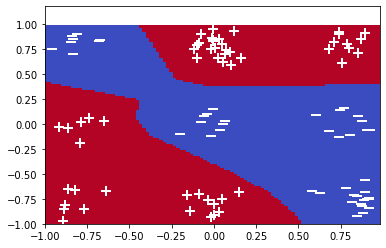

mu = 4.995569990283083


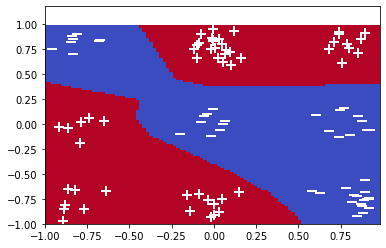

mu = 4.9827328933717165


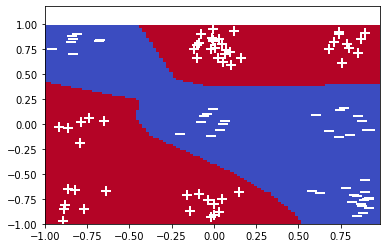

mu = 4.969935982170784


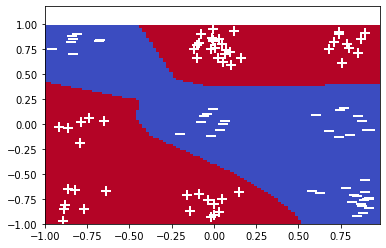

mu = 4.957179218670109


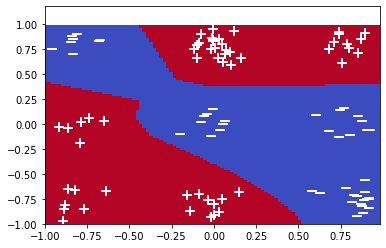

mu = 4.94446223518994


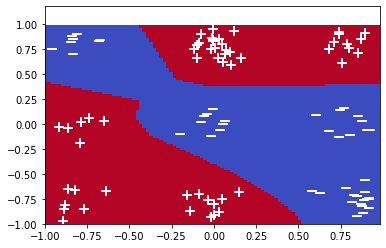

mu = 4.931784918896524


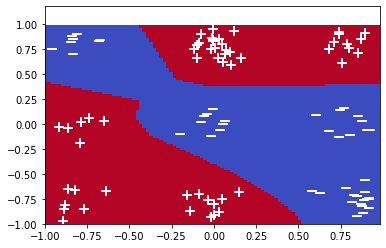

mu = 4.919147016903452


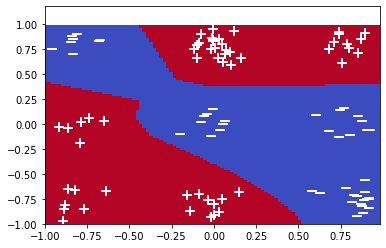

mu = 4.906548728452159


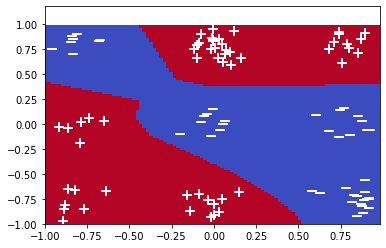

mu = 4.893989599674651


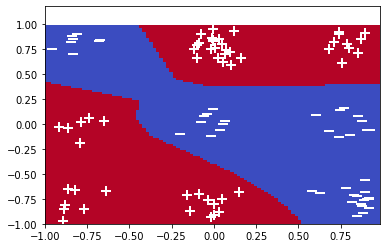

mu = 4.88146940647512


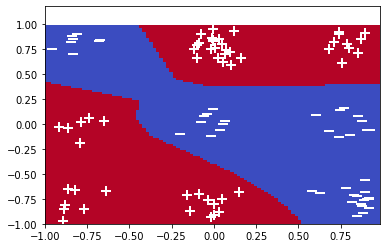

mu = 4.868988101945138


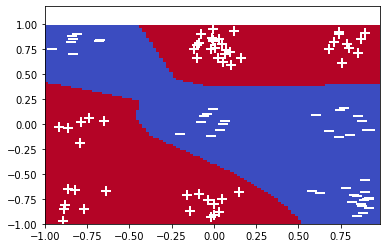

mu = 4.85654540613705


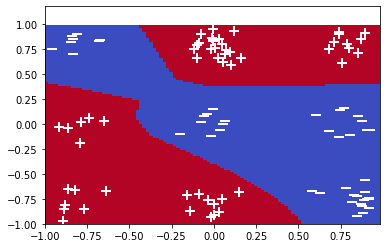

mu = 4.844141264024211


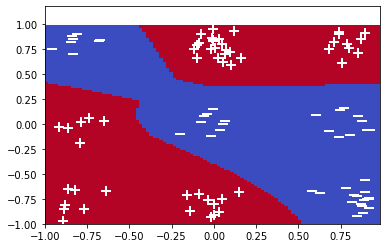

mu = 4.831775833136426


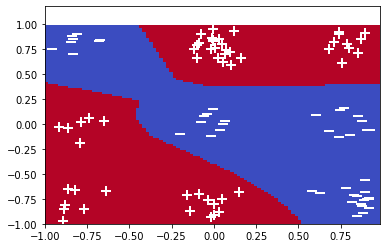

mu = 4.81944827215345


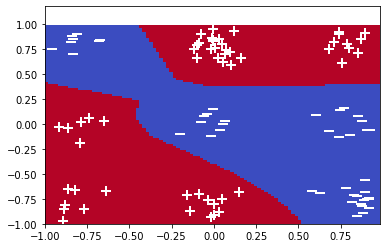

mu = 4.807159203234807


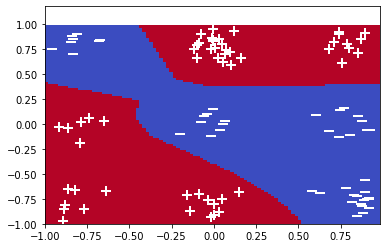

mu = 4.7949077520412695


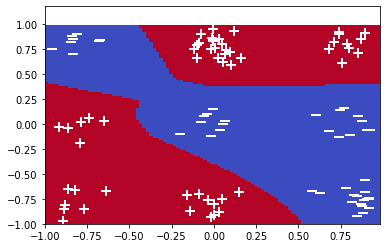

mu = 4.782694118995646


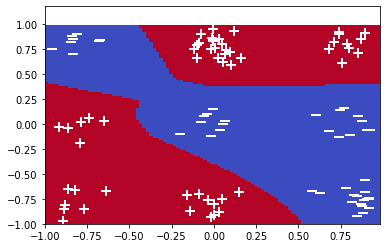

mu = 4.770518158418078


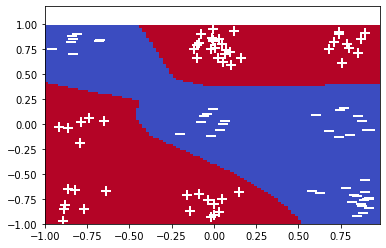

mu = 4.758379741256021


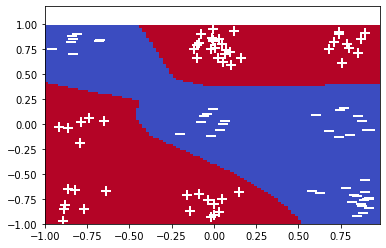

mu = 4.746278684796384


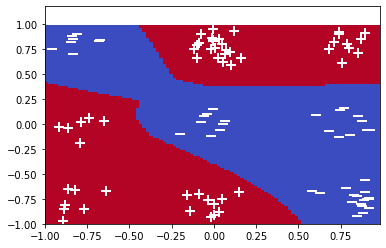

mu = 4.7342145508924425


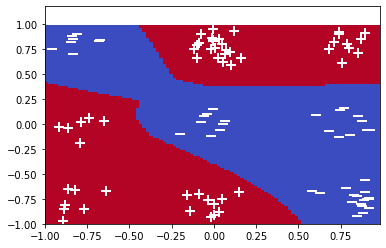

mu = 4.7221877065710665


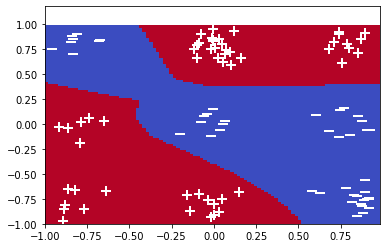

mu = 4.710197513344539


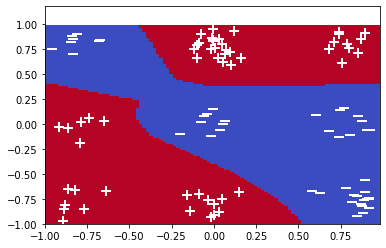

mu = 4.698244090963568


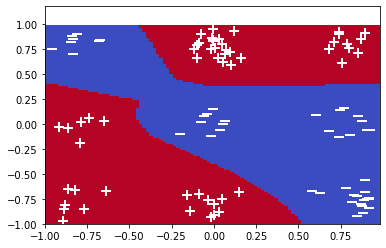

mu = 4.686327322337756


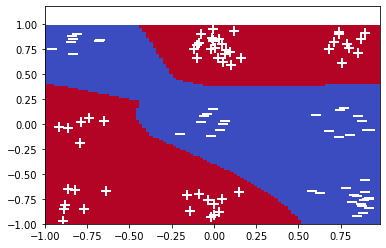

mu = 4.6744468767812455


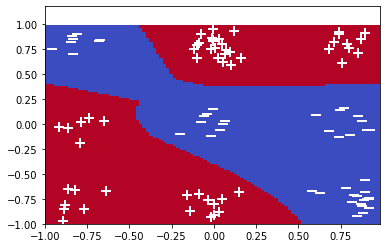

mu = 4.662696552740359


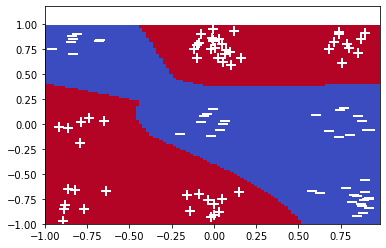

mu = 4.651329481154913


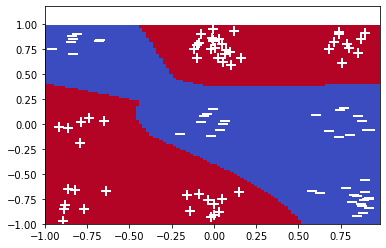

mu = 4.640006633065489


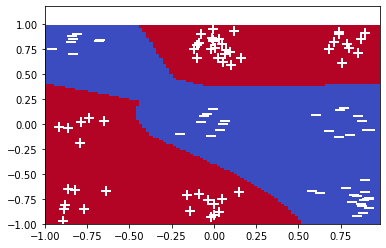

mu = 4.628715693668253


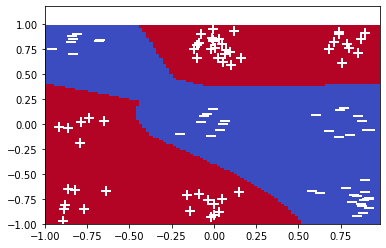

mu = 4.6174564942123615


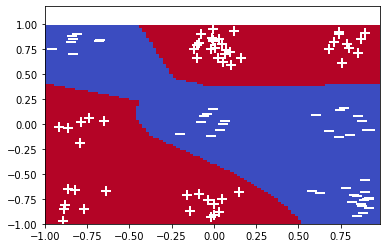

mu = 4.606228818888982


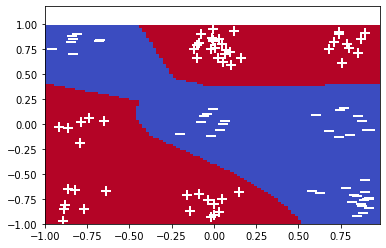

mu = 4.595032603132321


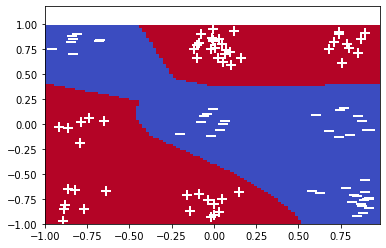

mu = 4.583867731279285


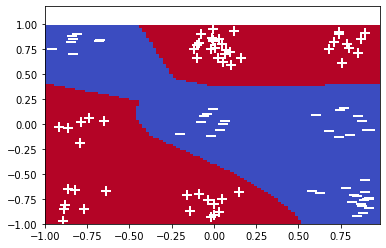

mu = 4.572734051367437


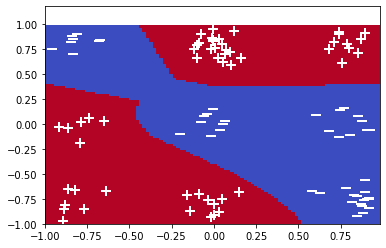

mu = 4.5616314567988825


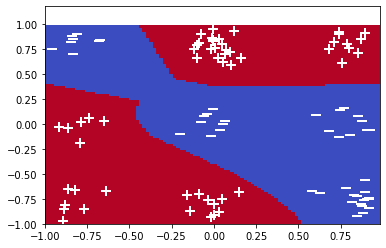

mu = 4.550559882208726


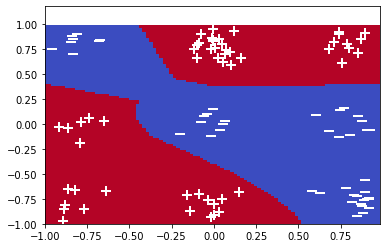

mu = 4.539519174562835


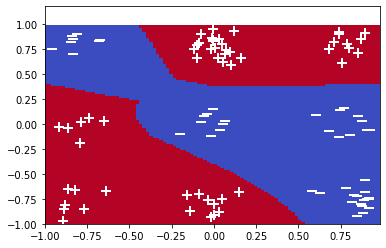

mu = 4.52850925685079


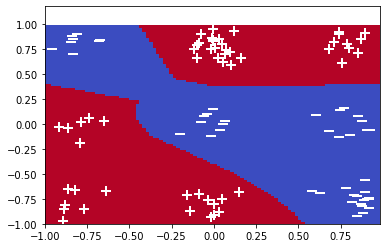

mu = 4.517530076163675


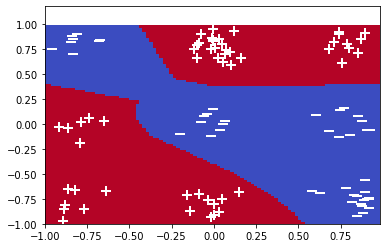

mu = 4.5065814916383635


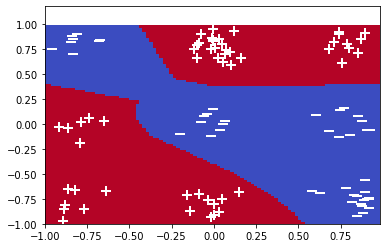

mu = 4.495663461121121


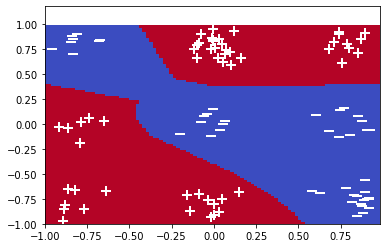

mu = 4.4847758043916945


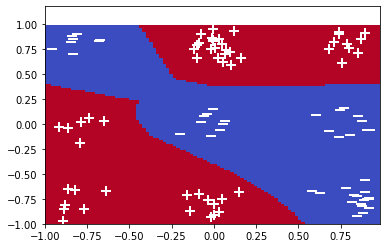

mu = 4.473918392921085


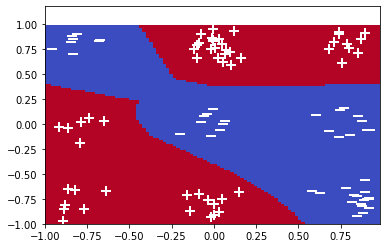

mu = 4.463091076825659


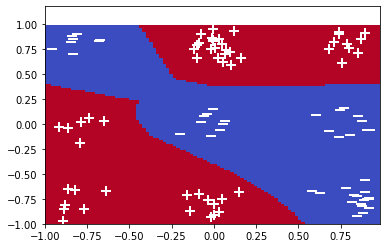

mu = 4.452293839005277


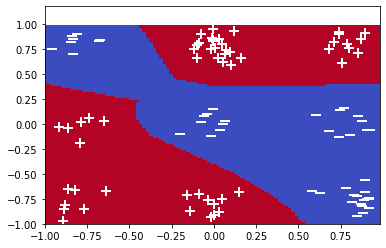

mu = 4.441526551253048


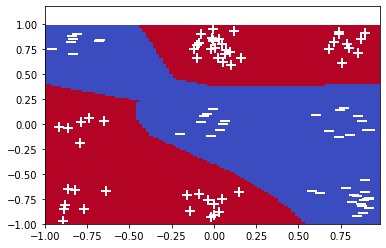

mu = 4.430789132182441


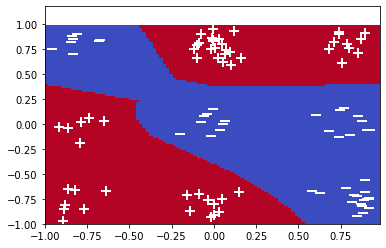

mu = 4.420081522988606


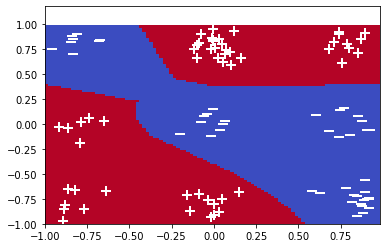

mu = 4.4094036271707315


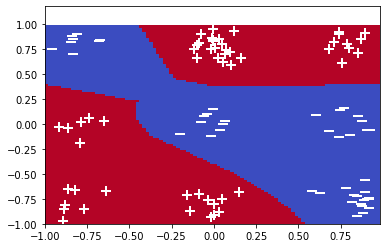

mu = 4.398755318601707


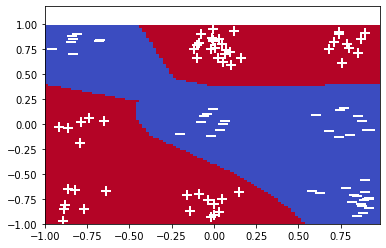

mu = 4.38813640578818


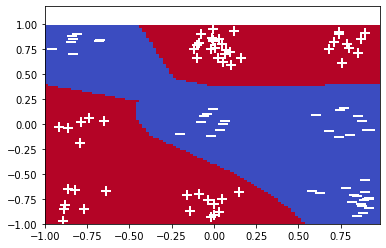

mu = 4.377546817539865


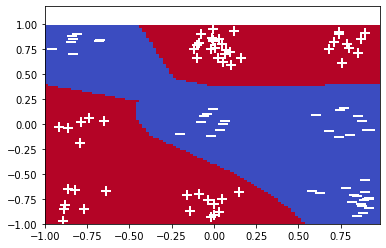

mu = 4.366986481292838


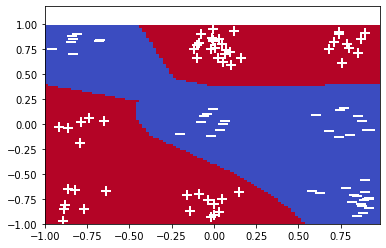

mu = 4.356455301684288


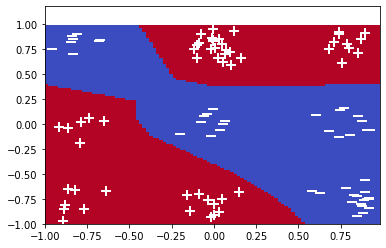

mu = 4.345953178782386


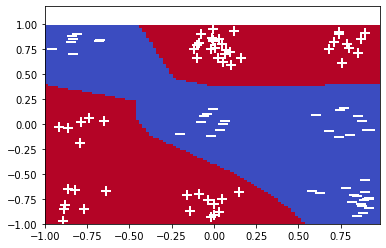

mu = 4.335480066602453


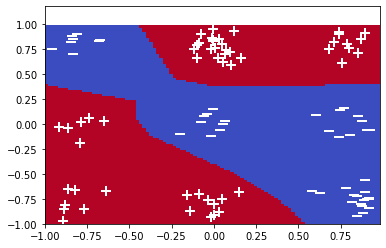

mu = 4.3250358089807195


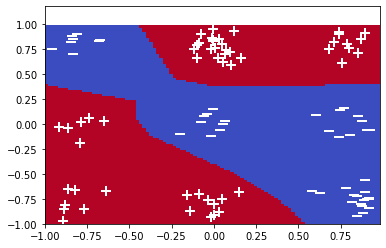

mu = 4.314620300421563


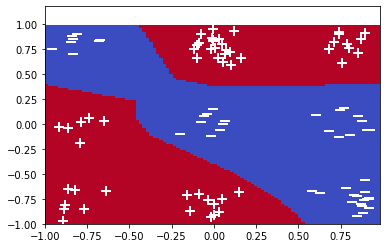

mu = 4.304233511163402


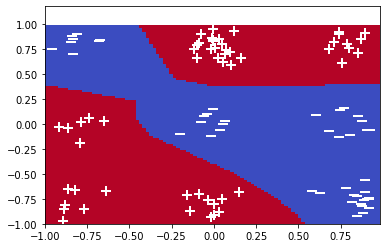

mu = 4.293875292830066


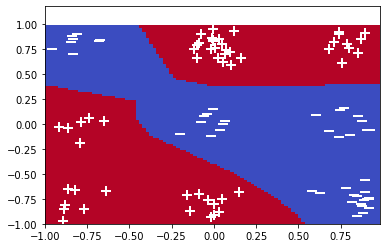

mu = 4.283545550643674


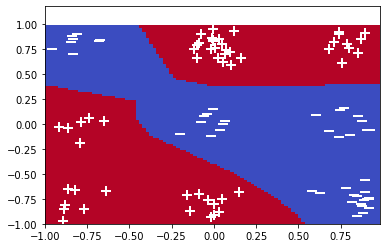

mu = 4.273244201936068


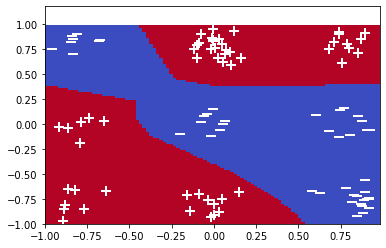

mu = 4.262971137171415


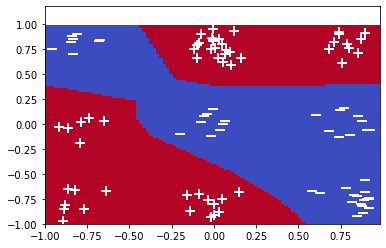

mu = 4.252726281742569


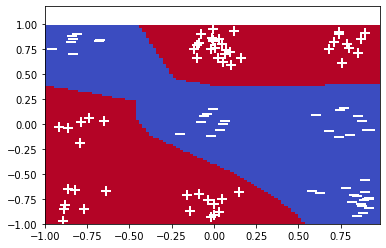

mu = 4.242509553088875


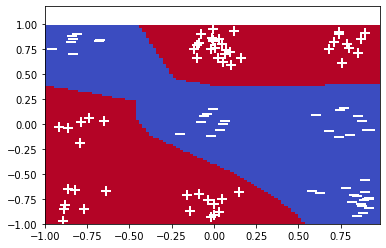

mu = 4.232320833417466


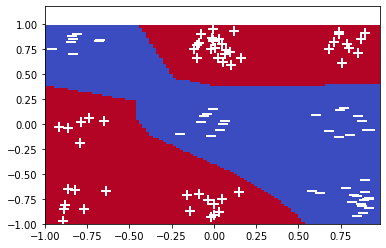

mu = 4.222160029917175


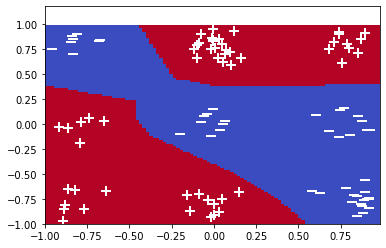

mu = 4.212027047178779


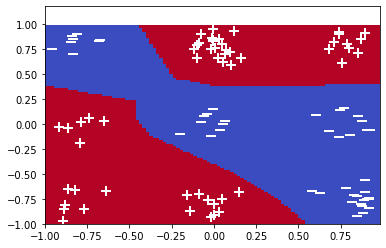

mu = 4.201921650058824


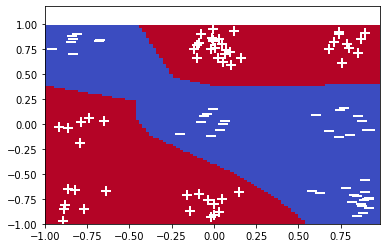

mu = 4.191843897001724


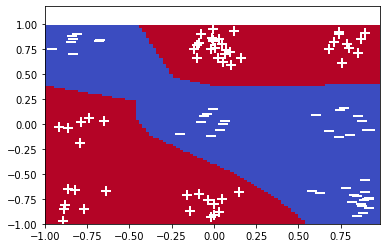

mu = 4.181793876358016


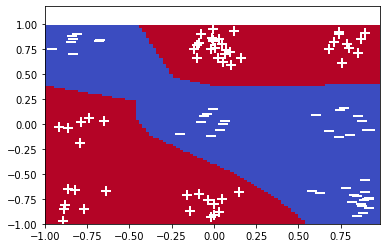

mu = 4.171771293713676


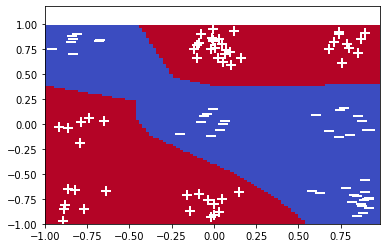

mu = 4.161775884592267


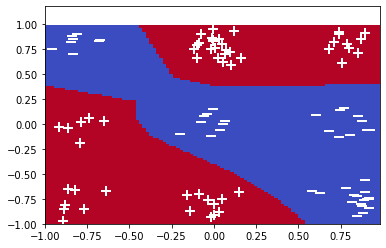

mu = 4.1518078294933565


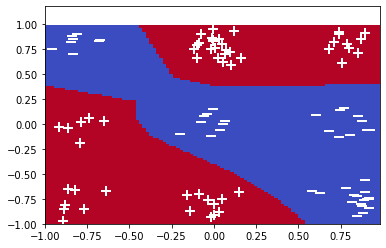

mu = 4.141867089375195


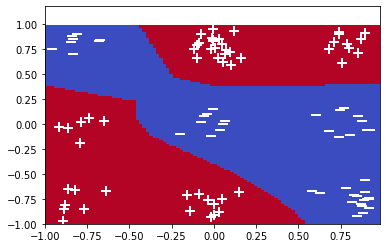

mu = 4.131953172495358


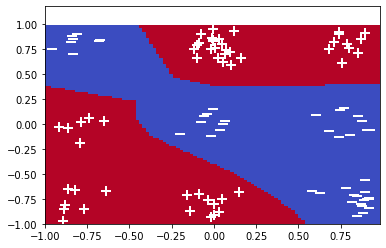

mu = 4.1220664917276


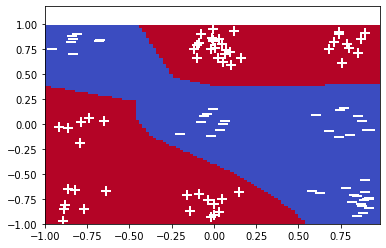

mu = 4.112206571543684


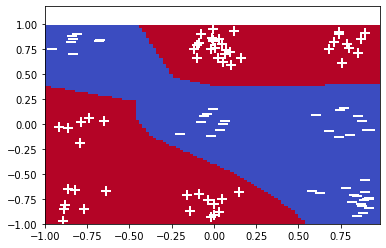

mu = 4.1023736024731585


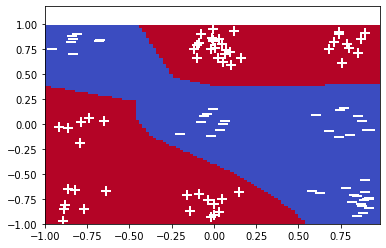

mu = 4.092567184281004


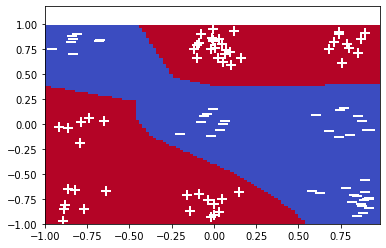

mu = 4.08278765786998


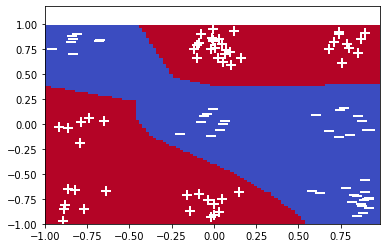

mu = 4.073034412936693


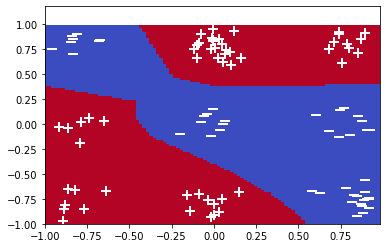

mu = 4.063307816166317


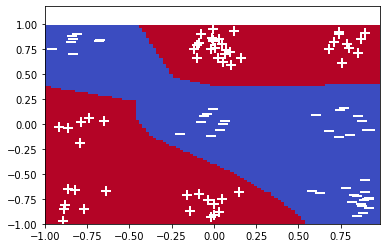

mu = 4.053607599418028


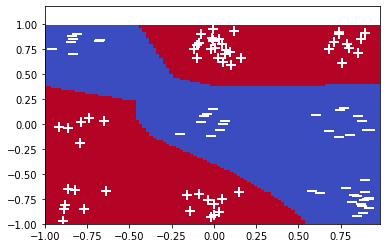

mu = 4.043933573213809


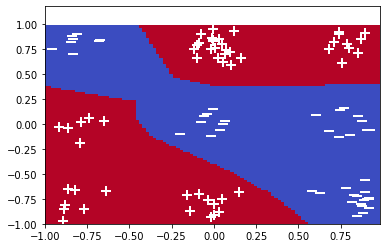

mu = 4.034285726502629


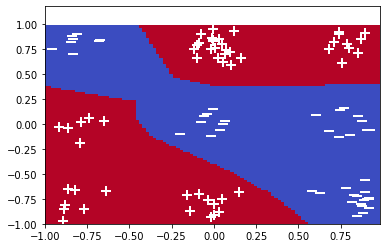

mu = 4.0246641208570875


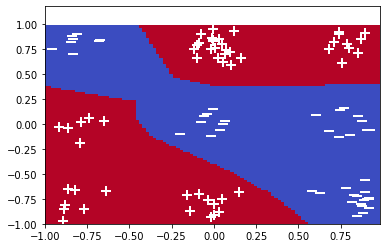

mu = 4.0150685722304456


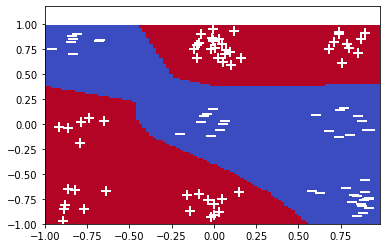

mu = 4.005498930290716


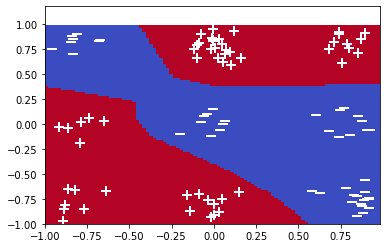

mu = 3.9959551365803727


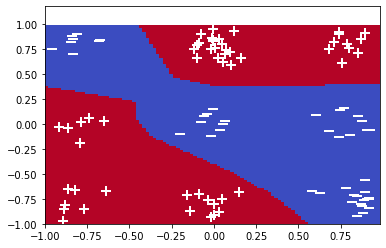

mu = 3.9864371407773307


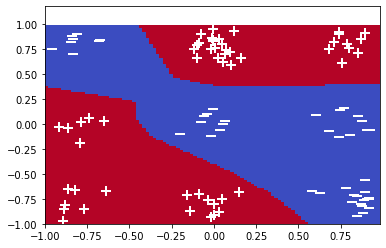

mu = 3.9769447469393886


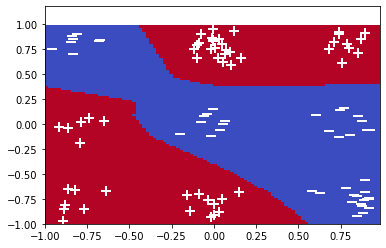

mu = 3.9674779679241254


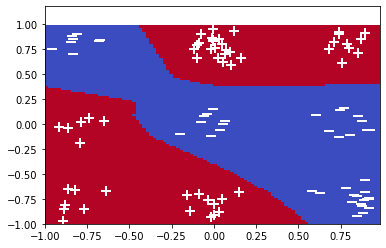

mu = 3.9580367271054846


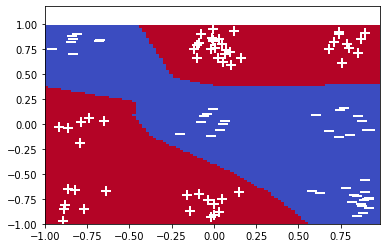

mu = 3.948621012853292


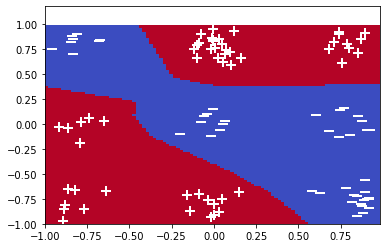

mu = 3.939230661417704


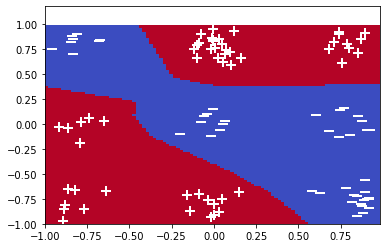

mu = 3.9298655682721426


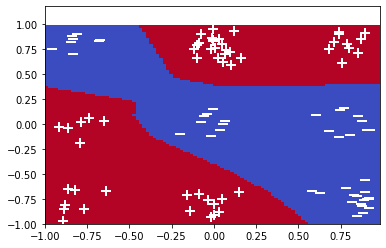

mu = 3.9205255135848613


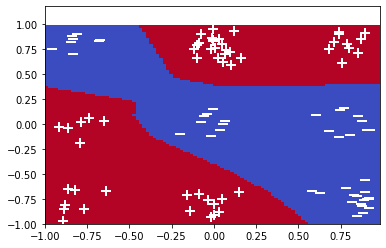

mu = 3.9112108170117215


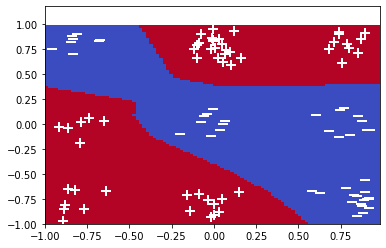

mu = 3.901920975754378


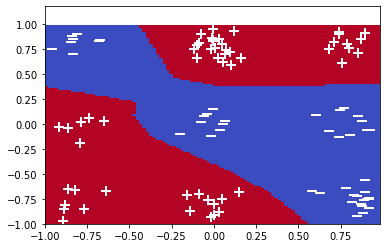

mu = 3.892656182794242


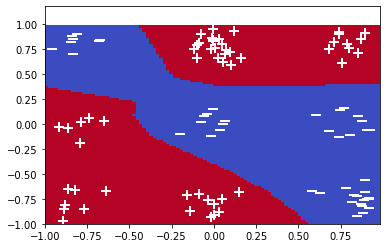

mu = 3.8834161606544013


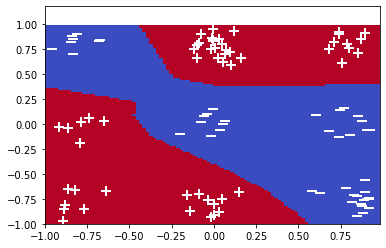

mu = 3.8742011244692613


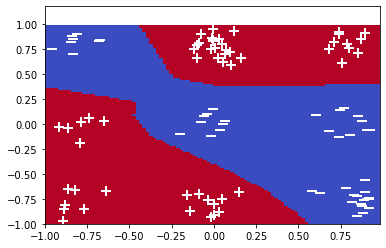

mu = 3.8650105557099983


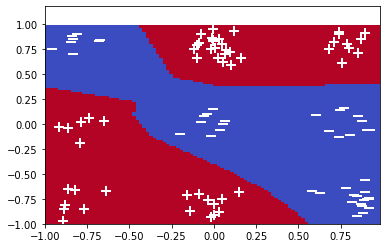

mu = 3.855844669427273


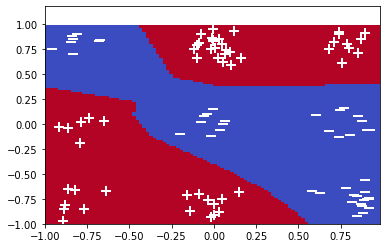

mu = 3.846703351441842


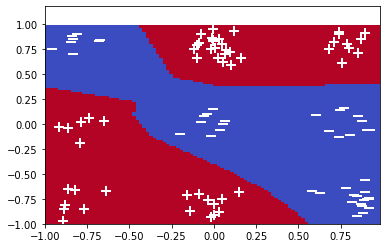

mu = 3.8375865424549604


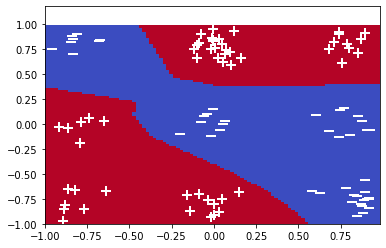

mu = 3.8284941288477183


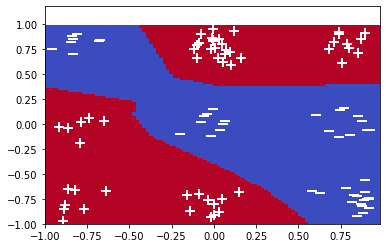

mu = 3.8194260028600704


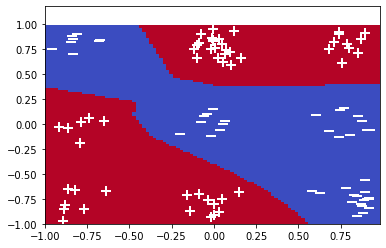

mu = 3.8103820558571373


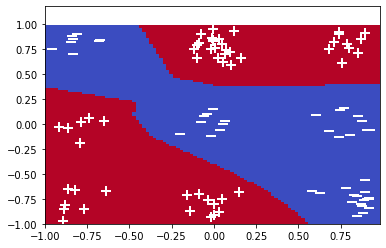

mu = 3.8013623062344295


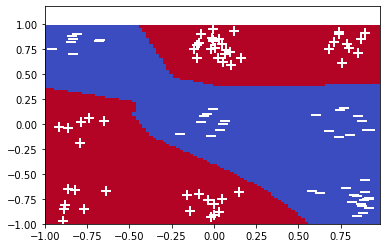

mu = 3.7923667027580987


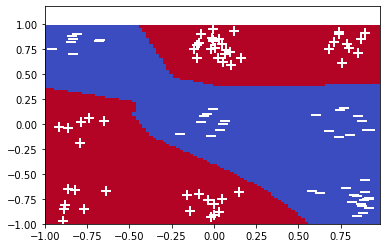

mu = 3.7833950442827846


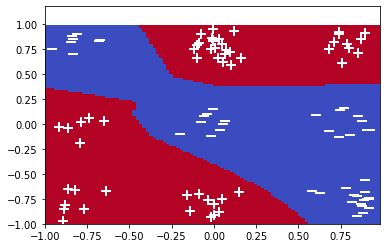

mu = 3.774447217803105


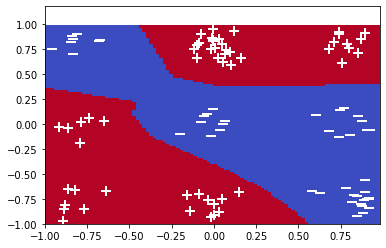

mu = 3.765523385927649


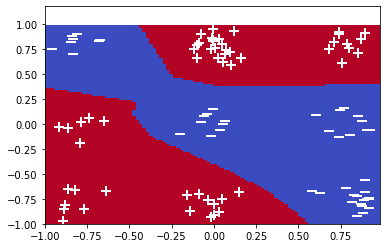

mu = 3.7566230924077


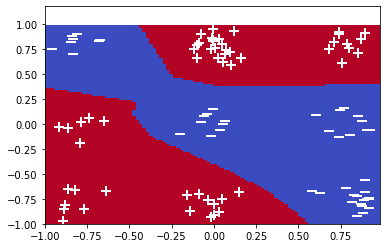

mu = 3.747746792512312


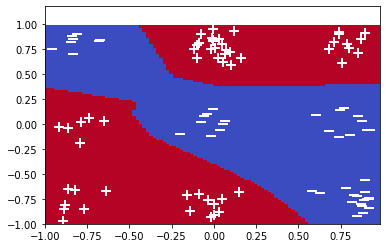

mu = 3.7388938226390156


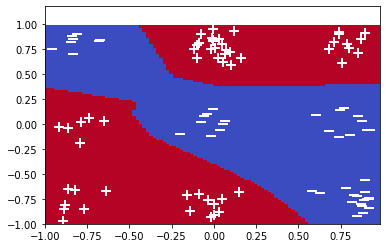

mu = 3.73006456165718


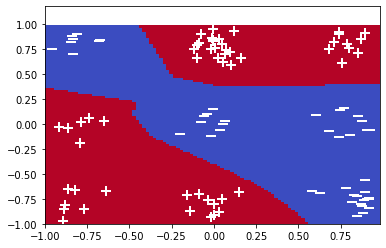

mu = 3.7212587393491883


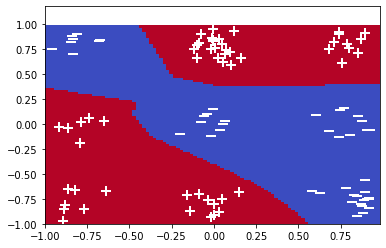

mu = 3.712476218750466


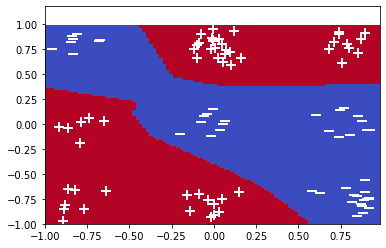

mu = 3.7037170207987433


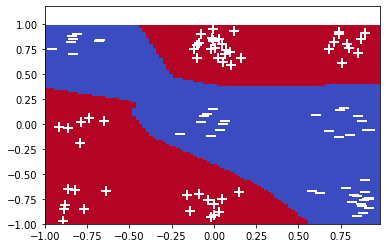

mu = 3.694981110568444


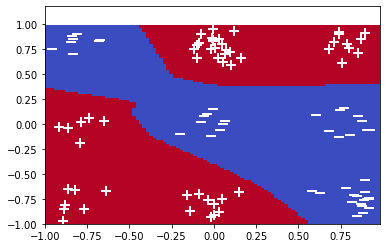

mu = 3.686268376658583


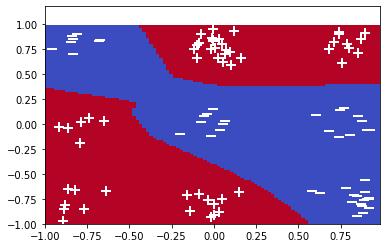

mu = 3.677578748657574


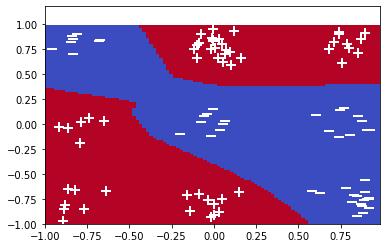

mu = 3.668912163122701


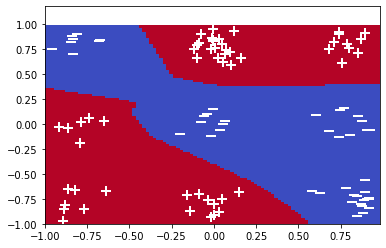

mu = 3.6602684947460586


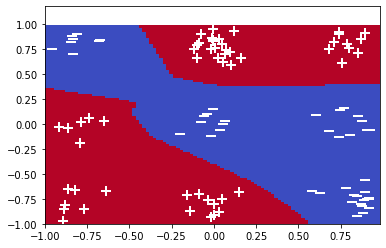

mu = 3.6516475477982016


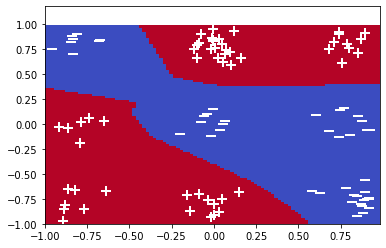

mu = 3.64304959468605


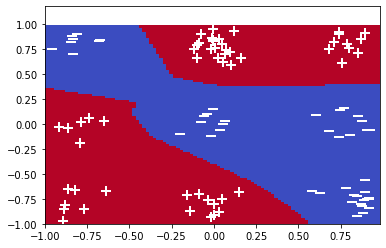

mu = 3.634474253093651


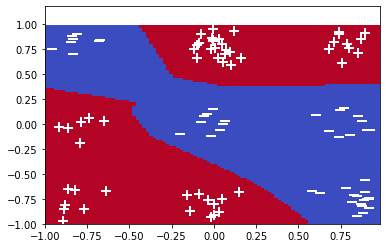

mu = 3.625921613934969


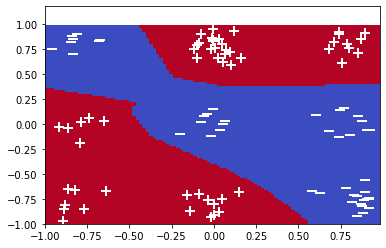

mu = 3.6173914683386923


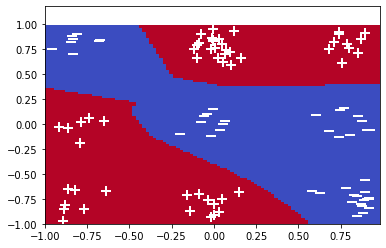

mu = 3.6088840181850075


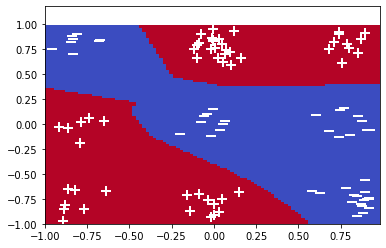

mu = 3.600398849382636


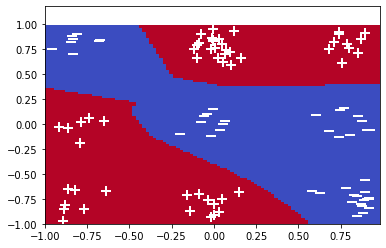

mu = 3.591936039807862


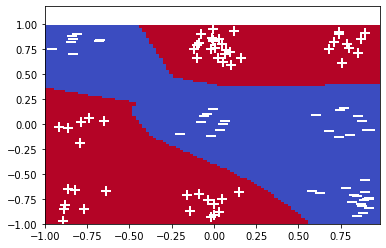

mu = 3.583495606865783


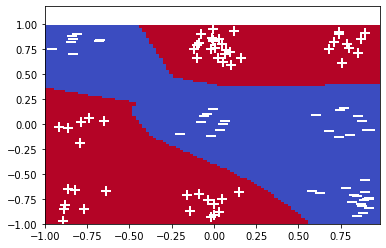

mu = 3.5750773483329006


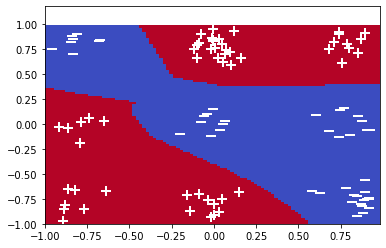

mu = 3.566681285715224


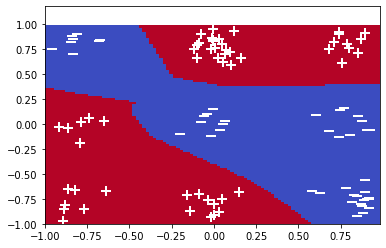

mu = 3.5583072902185093


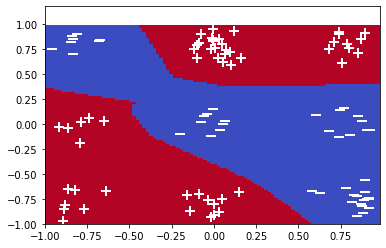

mu = 3.5499551732265004


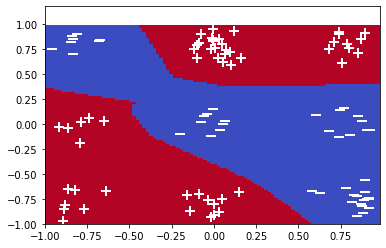

mu = 3.541625257886744


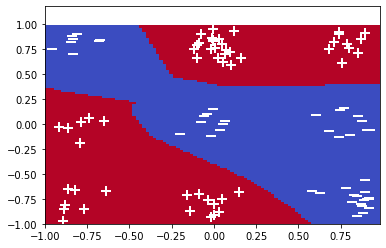

mu = 3.5333169520193066


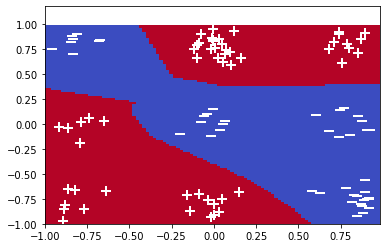

mu = 3.525030700198783


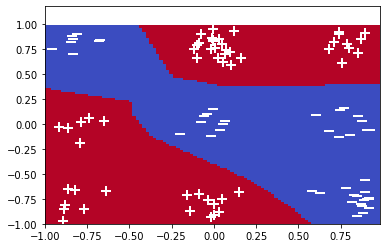

mu = 3.5167659798960034


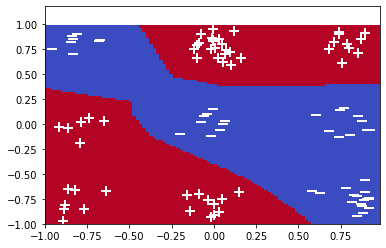

mu = 3.5085230316937004


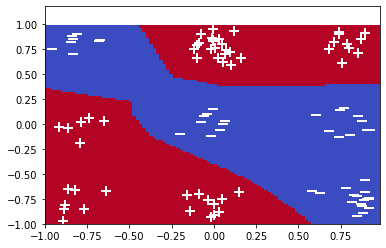

mu = 3.5003017457674908


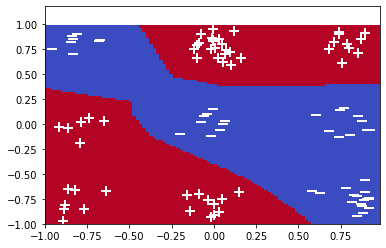

mu = 3.4921019181621


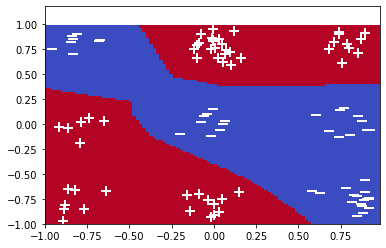

mu = 3.4839235685042103


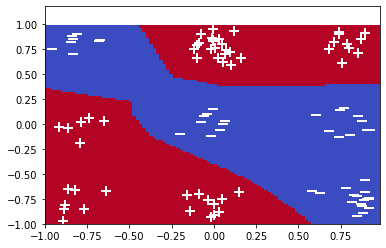

mu = 3.4757666538802177


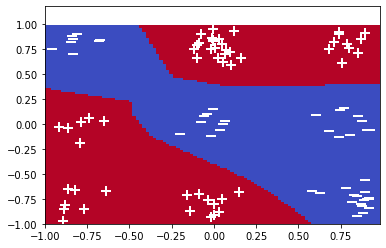

mu = 3.4676309382485133


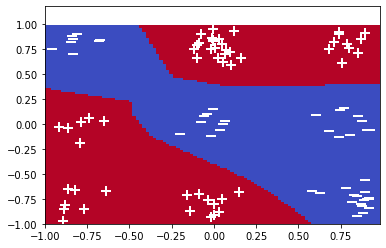

mu = 3.4595165301499224


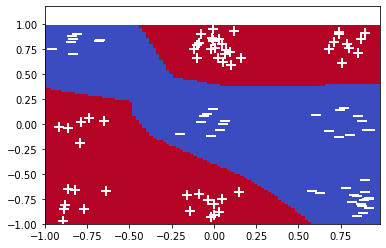

mu = 3.4514234599270046


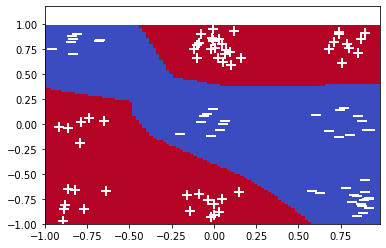

mu = 3.4433513619199005


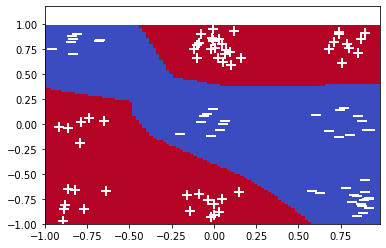

mu = 3.4353004820373476


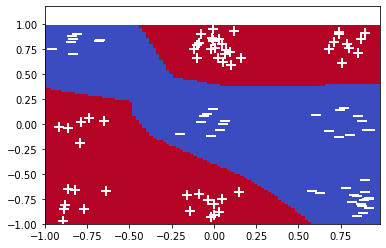

mu = 3.427270432307816


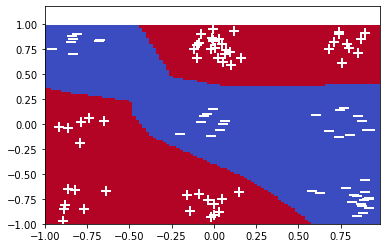

mu = 3.4192614825472525


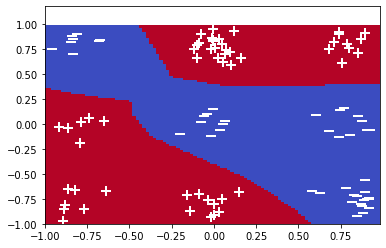

mu = 3.411273378090195


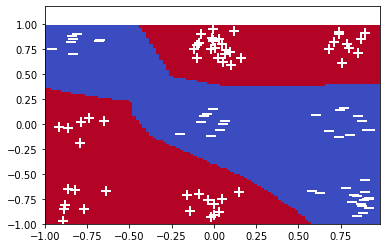

mu = 3.403306001904866


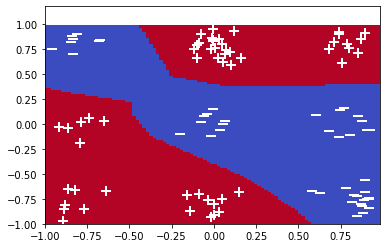

mu = 3.3953593880024644


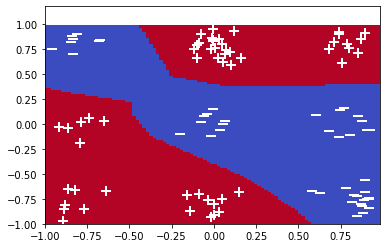

mu = 3.3874334873055223


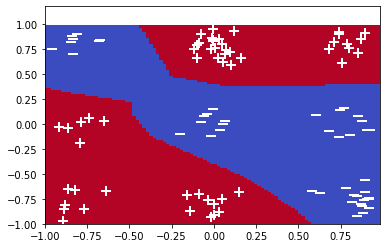

mu = 3.3795281454721886


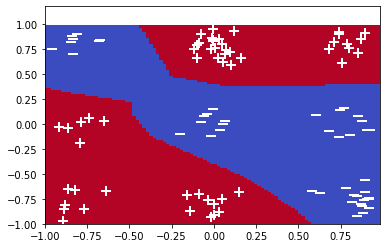

mu = 3.3716432793234143


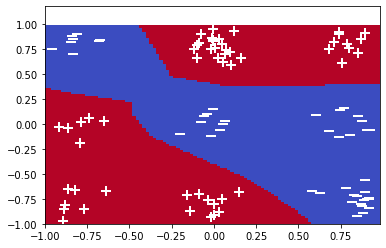

mu = 3.363779064679839


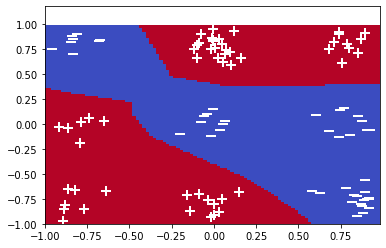

mu = 3.3559351903410595


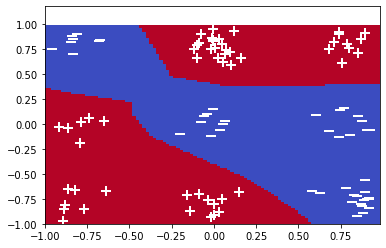

mu = 3.3481117254001185


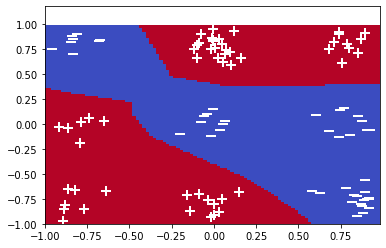

mu = 3.3403084198786934


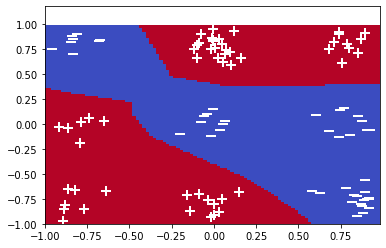

mu = 3.3325254604350407


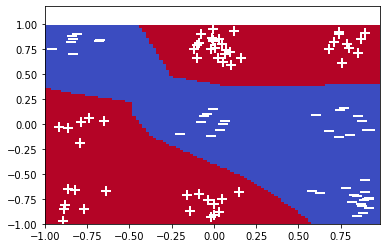

mu = 3.3247627204924175


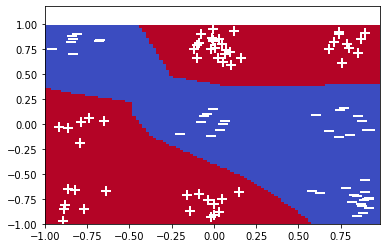

mu = 3.317020030185669


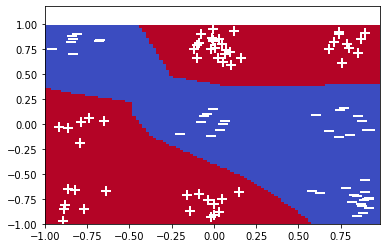

mu = 3.3092973690366274


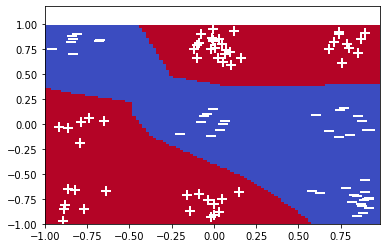

mu = 3.301594655303551


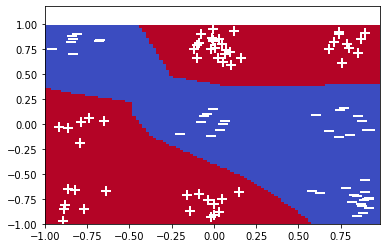

mu = 3.293911826126069


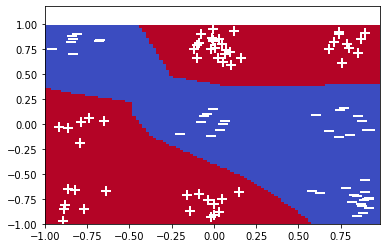

mu = 3.286249000663713


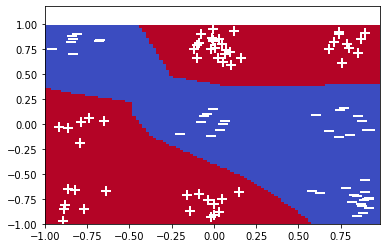

mu = 3.27860587426169


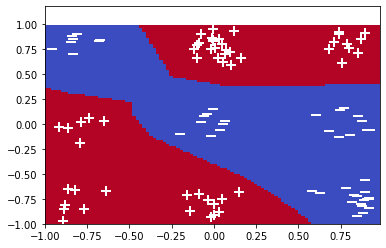

mu = 3.2709825573414673


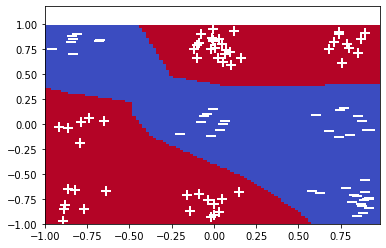

mu = 3.263378798518626


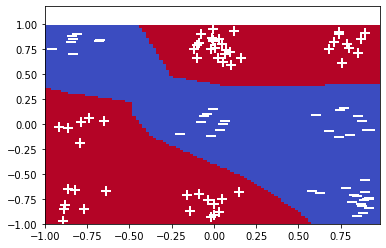

mu = 3.255794813349578


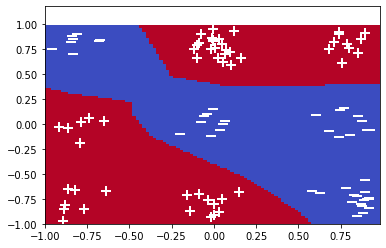

mu = 3.2482303545561653


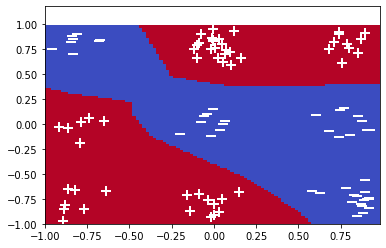

mu = 3.2406853194762983


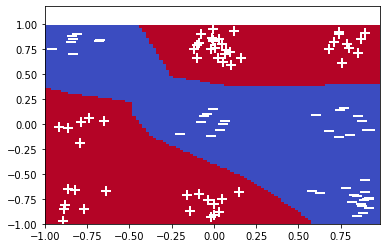

mu = 3.233159771802173


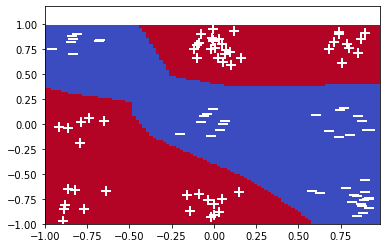

mu = 3.2256535692897317


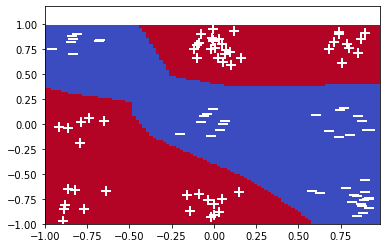

mu = 3.218166639993815


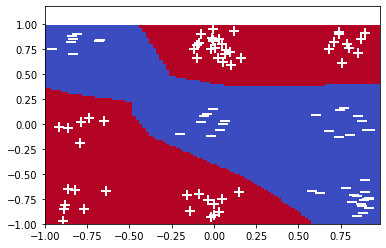

mu = 3.2106989730639133


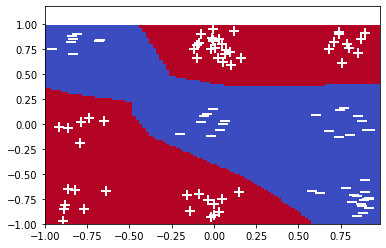

mu = 3.203250661659283


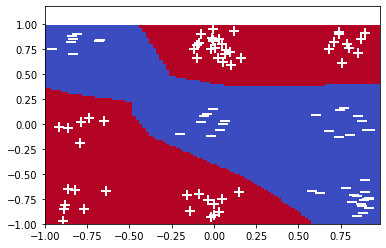

mu = 3.19582127856833


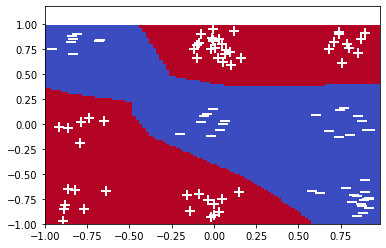

mu = 3.1884111647632842


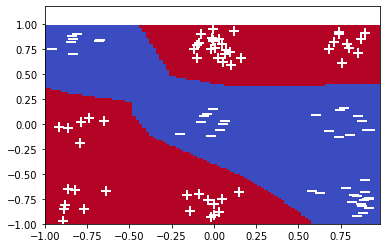

mu = 3.1810200418652403


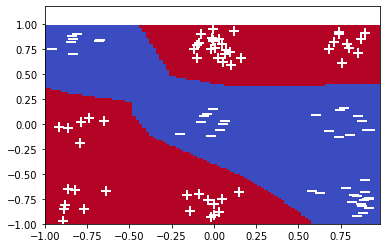

mu = 3.173647806520632


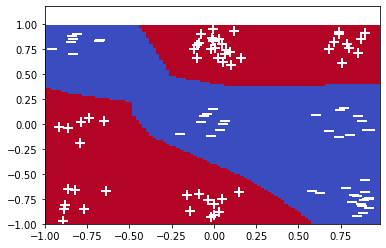

mu = 3.166294449541851


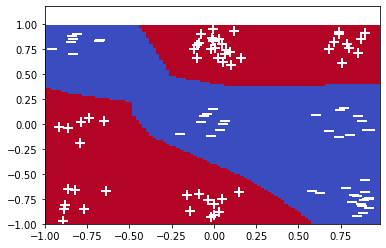

mu = 3.158959996561816


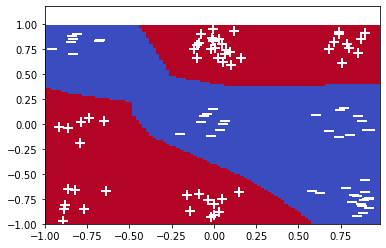

mu = 3.15164450106003


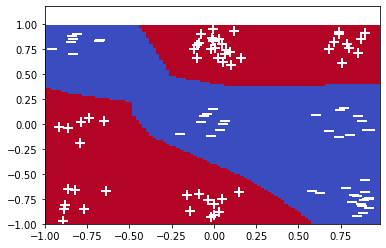

mu = 3.1443474794347868


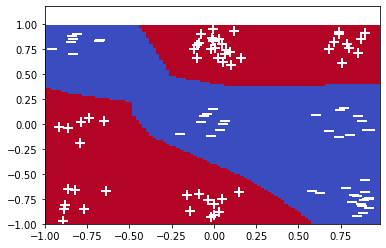

mu = 3.1370693737655473


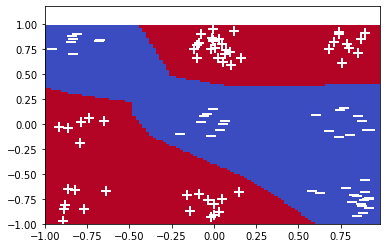

mu = 3.12980974661287


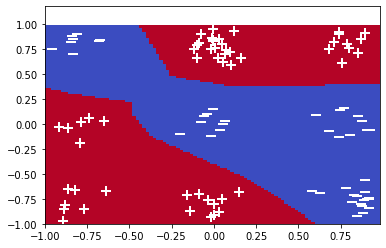

mu = 3.1226093597662956


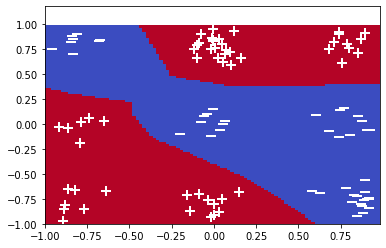

mu = 3.1156056057989945


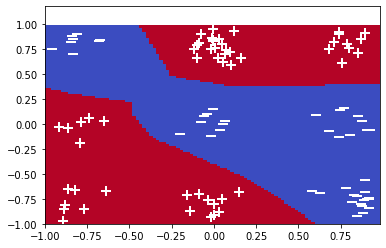

mu = 3.10861972095277


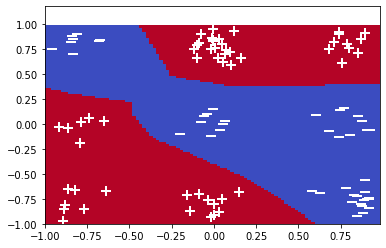

mu = 3.1016508362566504


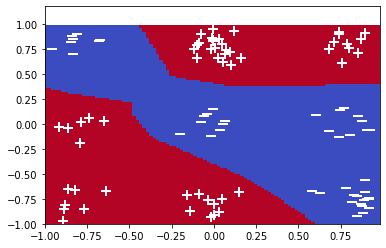

mu = 3.0946991250843925


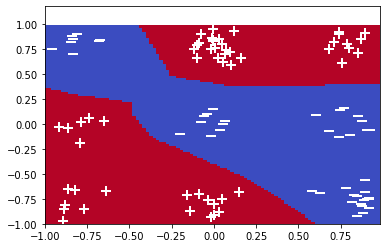

mu = 3.0877642460248724


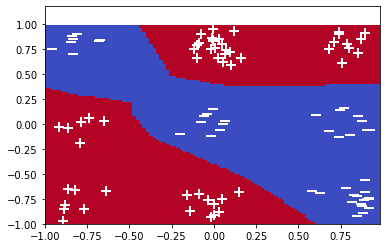

mu = 3.0808653470537397


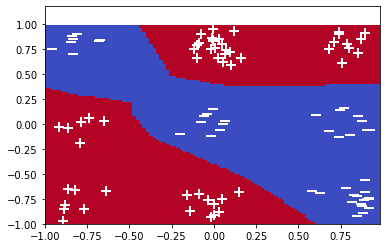

mu = 3.074051245888364


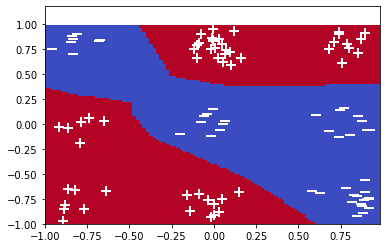

mu = 3.067254064290562


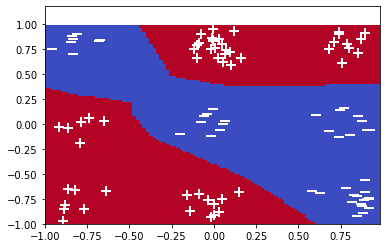

mu = 3.060473862796955


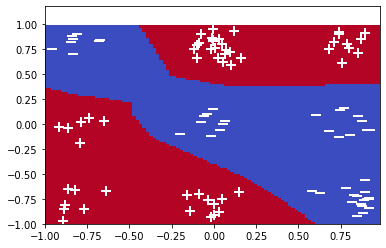

mu = 3.053710284892258


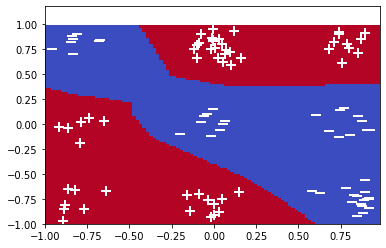

mu = 3.0469634344310648


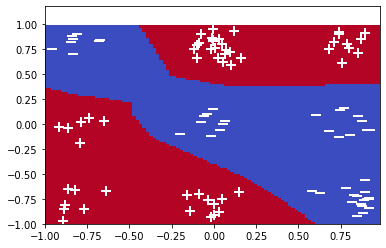

mu = 3.0402333424221446


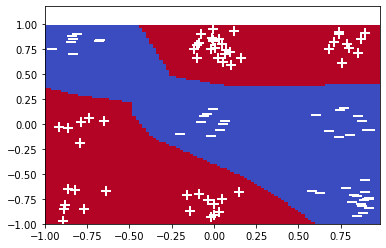

mu = 3.0335198005960105


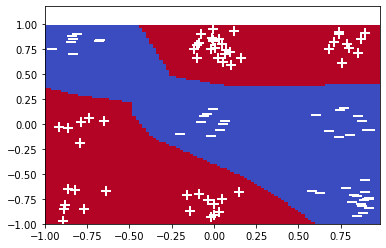

mu = 3.0268227159981933


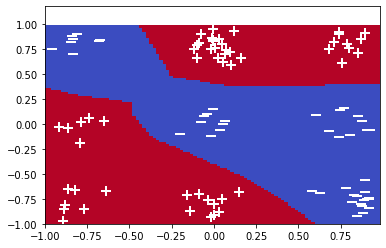

mu = 3.0201422919261636


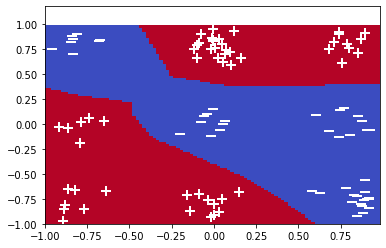

mu = 3.013478350845276


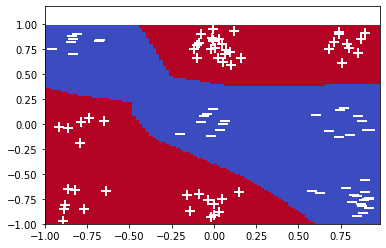

mu = 3.0068307397223344


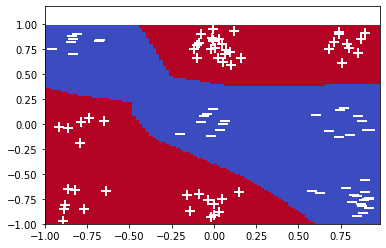

mu = 3.0001996361050596


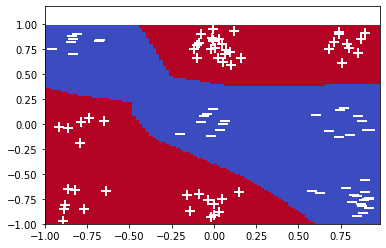

mu = 2.9935848703975236


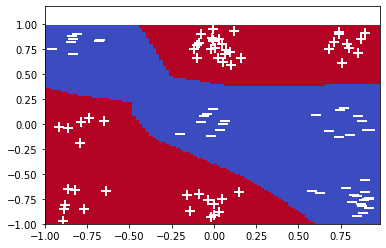

mu = 2.986986304940618


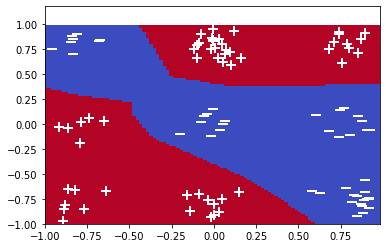

mu = 2.9804039011010888


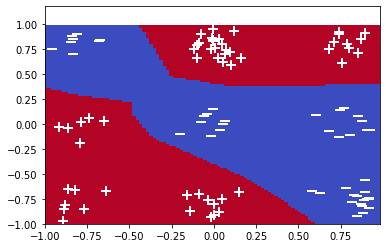

mu = 2.973837899165182


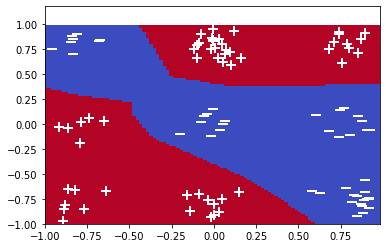

mu = 2.9672878905322144


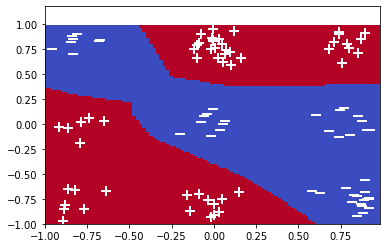

mu = 2.9607540858654144


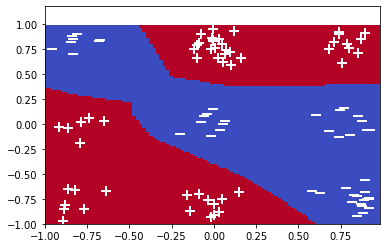

mu = 2.9542362263723683


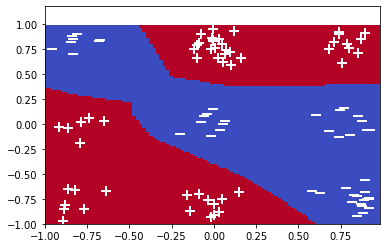

mu = 2.9477344663177045


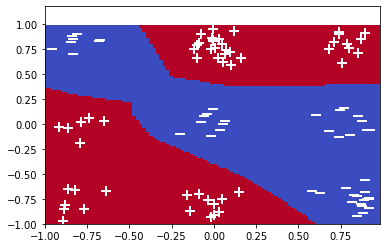

mu = 2.9412486921138608


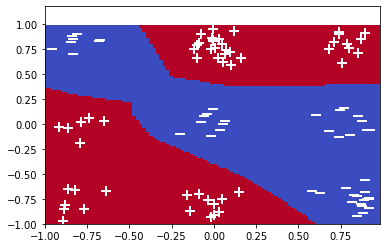

mu = 2.9347787848819546


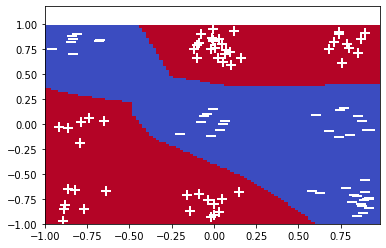

mu = 2.928324576349869


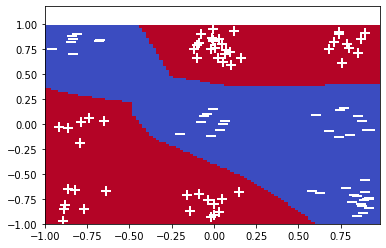

mu = 2.9218863631815255


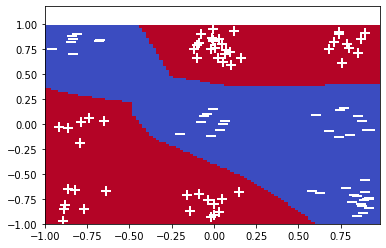

mu = 2.915463920495042


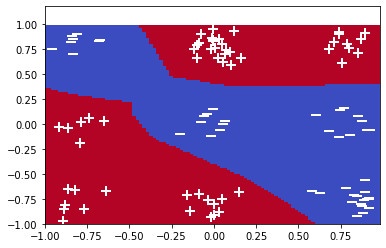

mu = 2.909057283652331


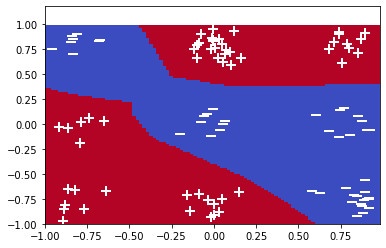

mu = 2.902666254161178


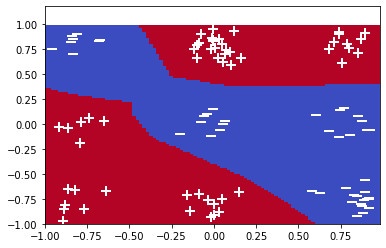

mu = 2.8962908346976635


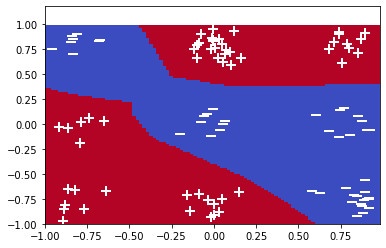

mu = 2.889931035765659


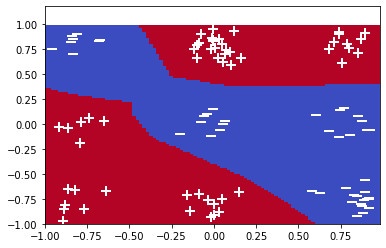

mu = 2.883586828045221


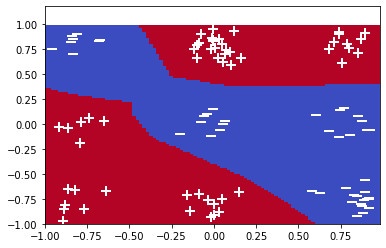

mu = 2.877258168250556


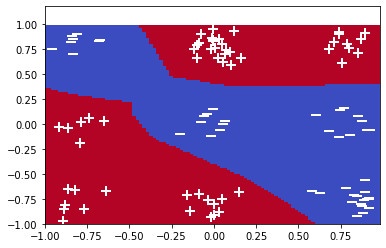

mu = 2.8709449591330833


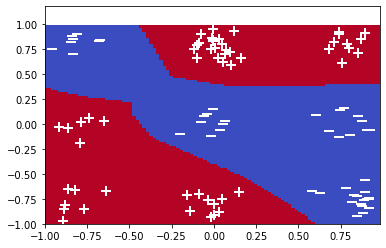

mu = 2.864647032869105


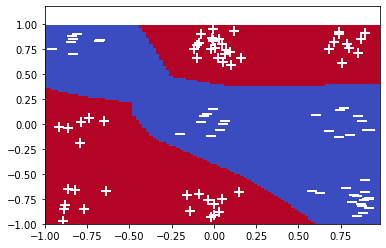

mu = 2.8583646529864914


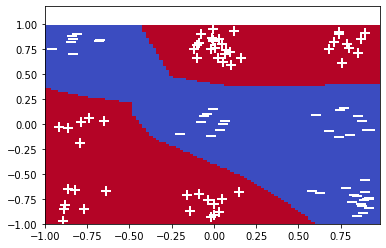

mu = 2.852097502204436


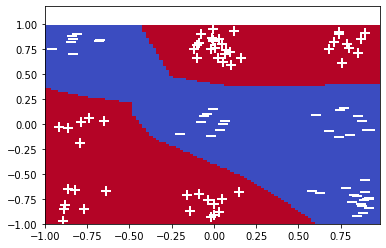

mu = 2.8458457326527338


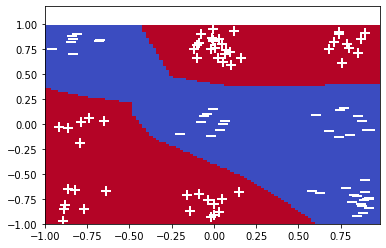

mu = 2.8396090719558638


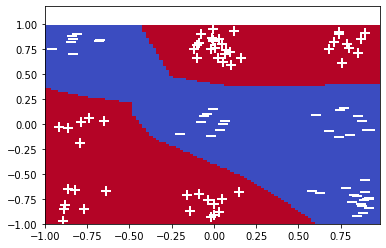

mu = 2.8333877036818373


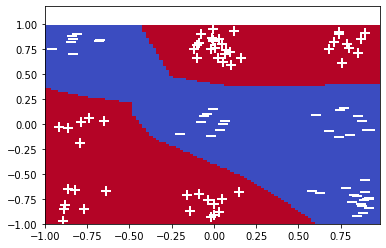

mu = 2.8271815763782473


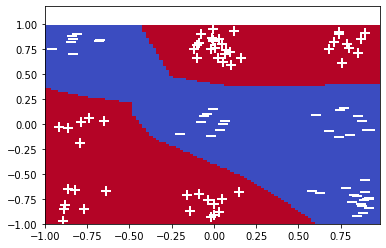

mu = 2.820990499455257


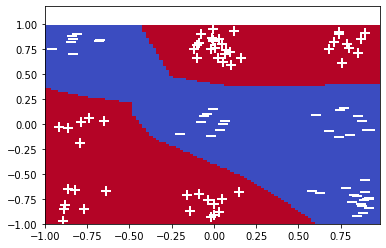

mu = 2.8148144421001446


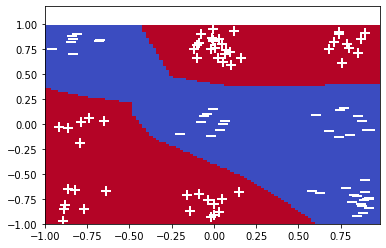

mu = 2.808653423954639


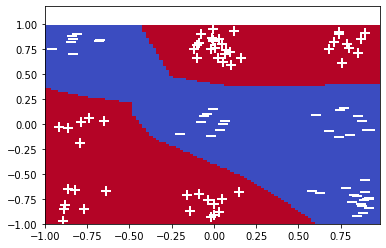

mu = 2.802507428374416


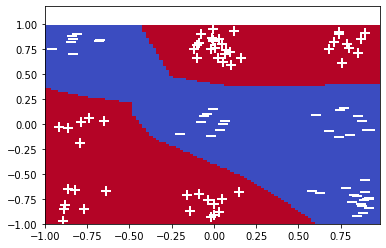

mu = 2.7963764797243833


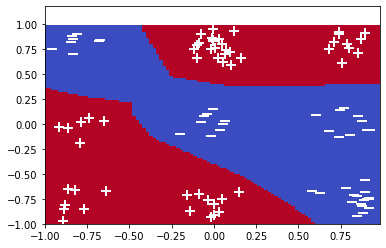

mu = 2.7902603119399596


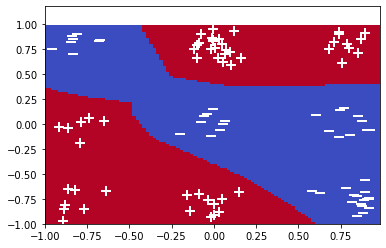

mu = 2.7841590999625483


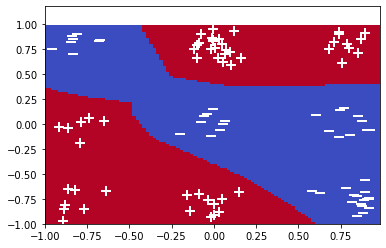

mu = 2.778072523547971


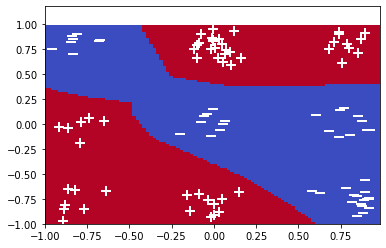

mu = 2.772000907723232


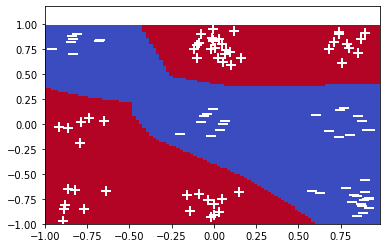

mu = 2.7659439584826866


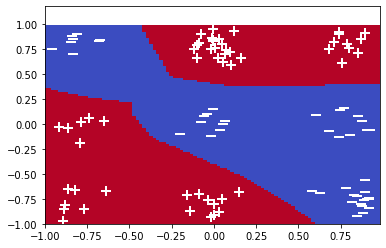

mu = 2.759901762887844


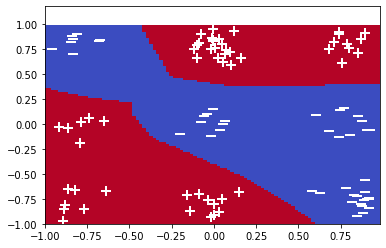

mu = 2.753874169799841


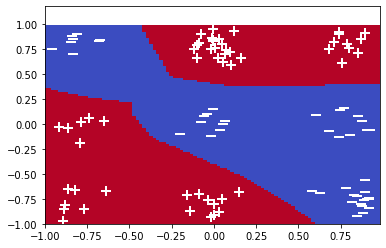

mu = 2.7478612001425042


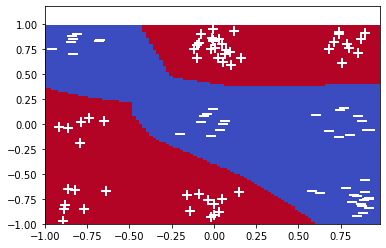

mu = 2.741862864823073


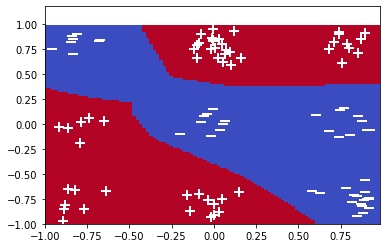

mu = 2.7358789419955722


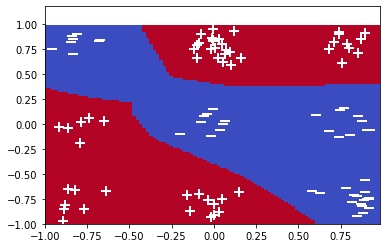

mu = 2.729909662513146


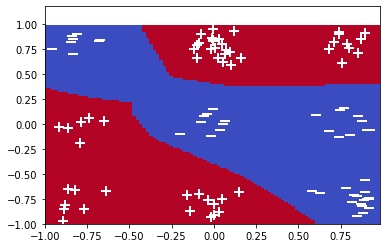

mu = 2.7239546715506053


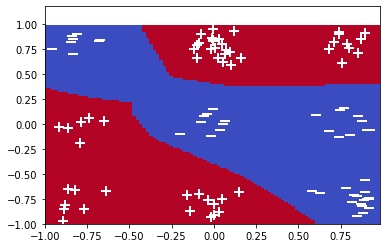

mu = 2.7180142037833916


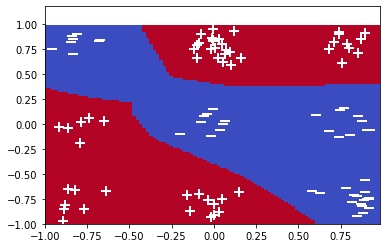

mu = 2.7120881005770188


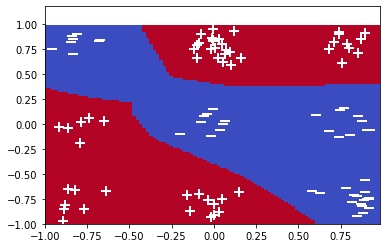

mu = 2.7061763227938487


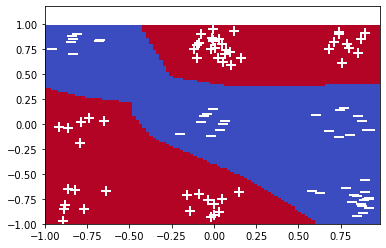

mu = 2.7002787840919202


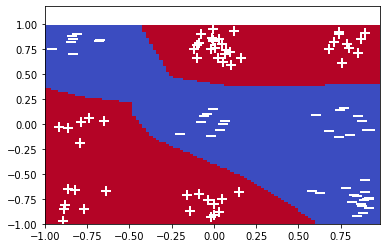

mu = 2.6943955108522433


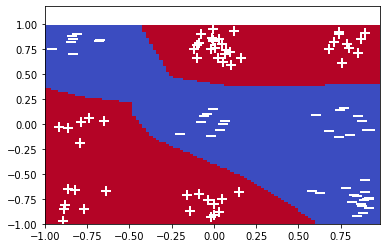

mu = 2.688526454658095


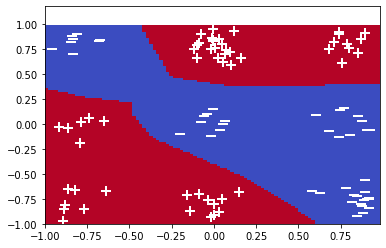

mu = 2.6826715393217415


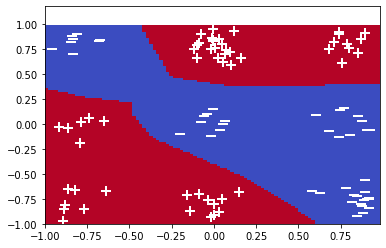

mu = 2.6768308236804734


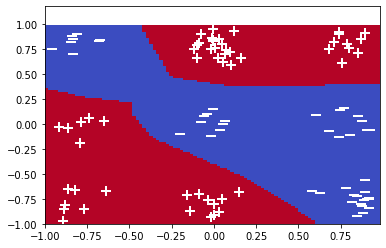

mu = 2.671004155863871


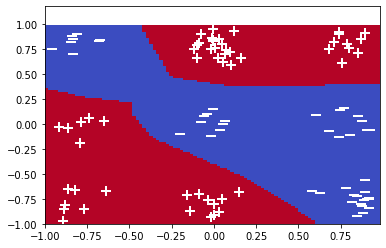

mu = 2.6651915651070723


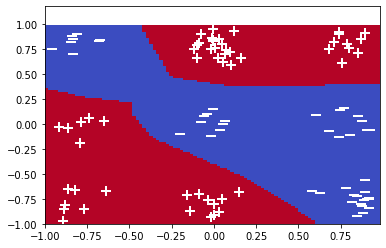

mu = 2.659392861451412


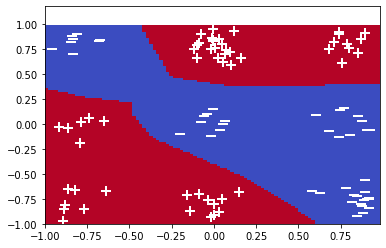

mu = 2.6536082454732575


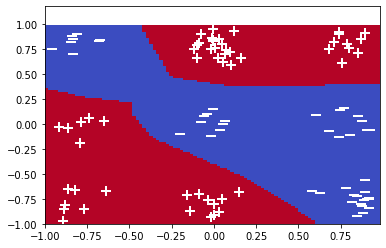

mu = 2.6478375495817836


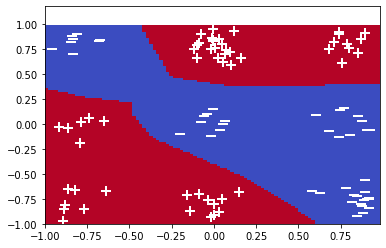

mu = 2.64208083225965


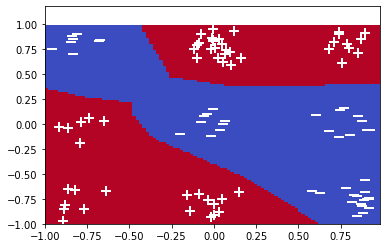

mu = 2.636337901564652


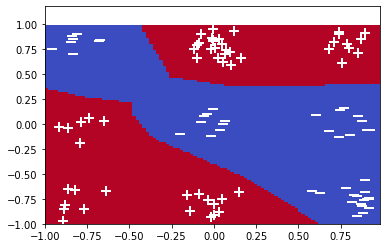

mu = 2.6306087707401913


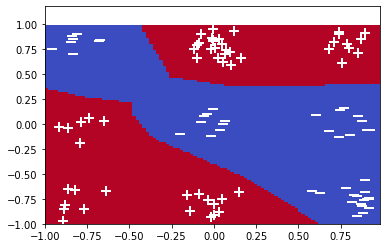

mu = 2.624893380975572


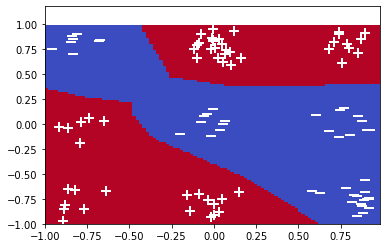

mu = 2.619191898275964


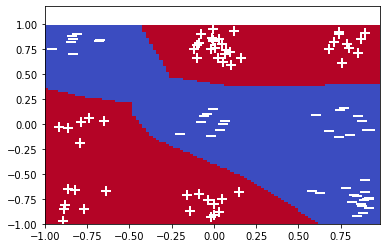

mu = 2.6135040104803897


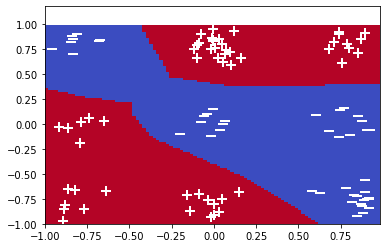

mu = 2.607829804790066


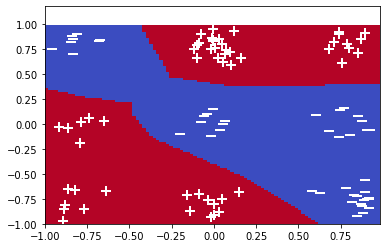

mu = 2.6021691446776343


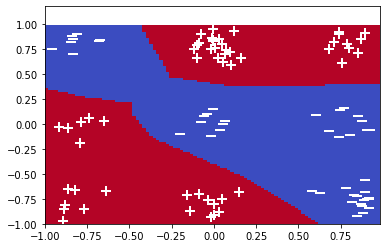

mu = 2.59652211043575


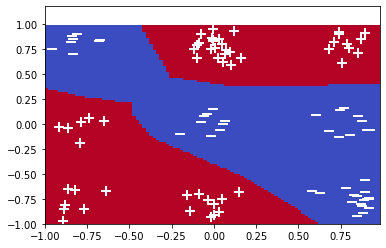

mu = 2.590888693911198


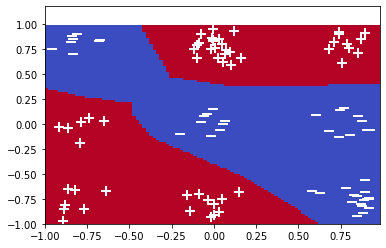

mu = 2.585268845282133


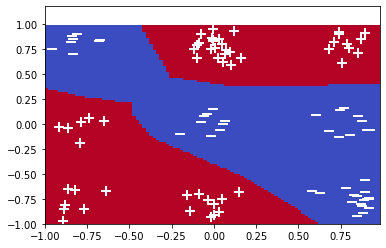

mu = 2.5796623338664317


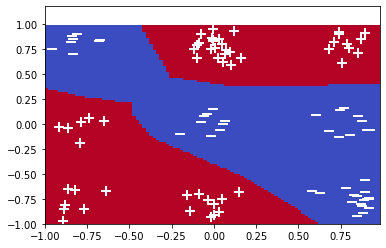

mu = 2.5740693567938937


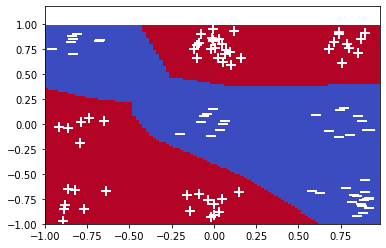

mu = 2.5684896519934233


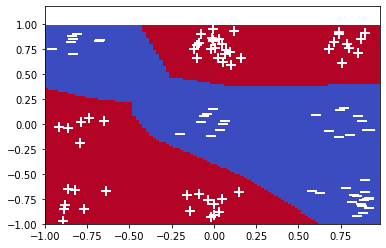

mu = 2.562923495234696


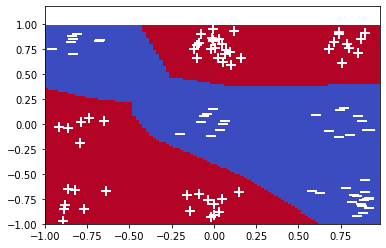

mu = 2.5573705261687305


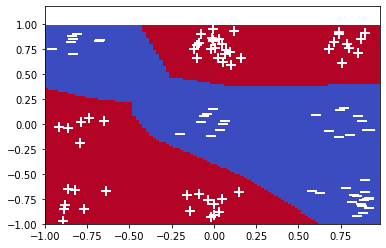

mu = 2.5518310105117585


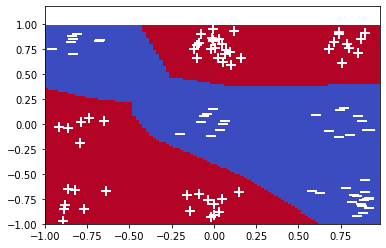

mu = 2.546304613001438


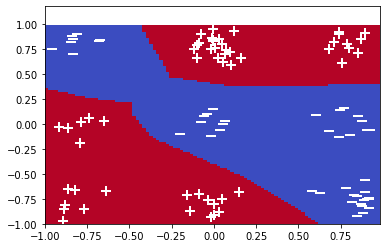

mu = 2.5407915048762115


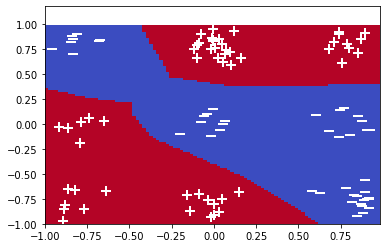

mu = 2.535291460336108


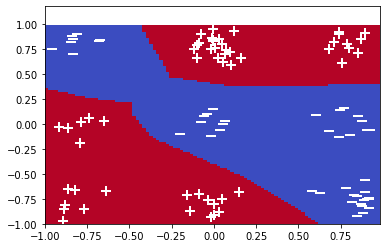

mu = 2.5298047266349966


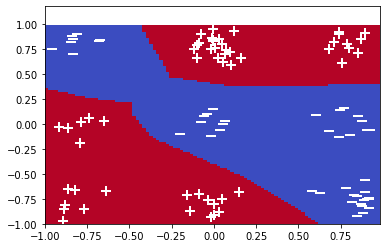

mu = 2.524331023440919


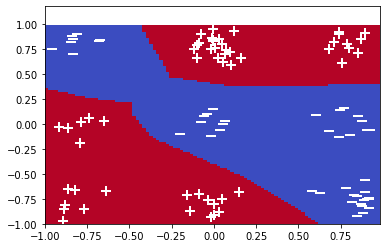

mu = 2.518870361036039


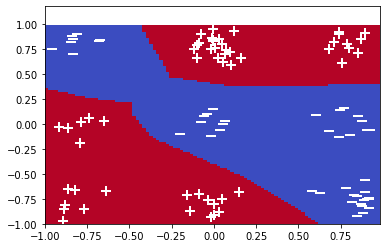

mu = 2.513422877657674


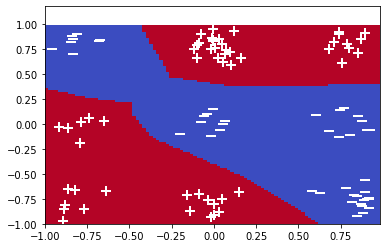

mu = 2.5079882359354686


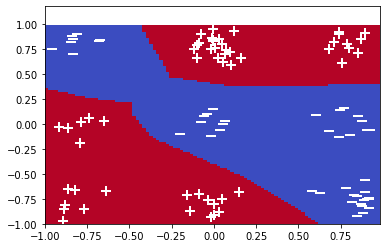

mu = 2.5025667019989113


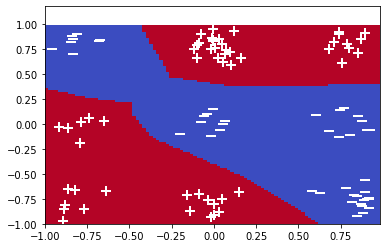

mu = 2.4971580435621132


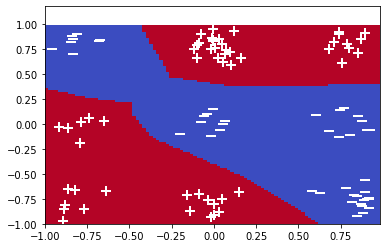

mu = 2.491762261633795


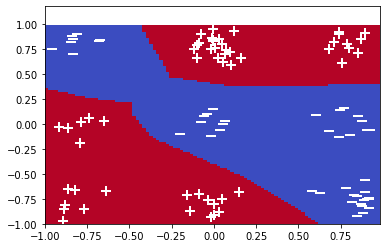

mu = 2.486379306339131


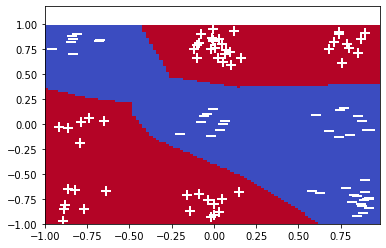

mu = 2.4810092314129517


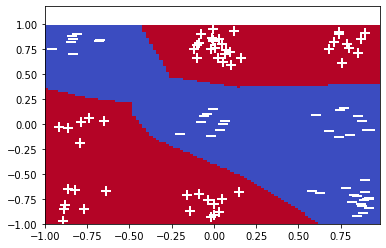

mu = 2.475651923433258


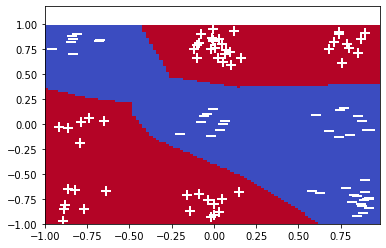

mu = 2.470307452284367


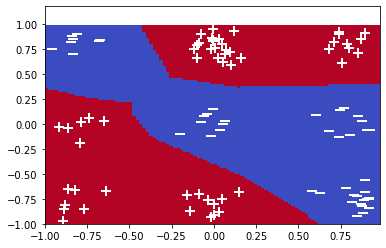

mu = 2.464975602382062


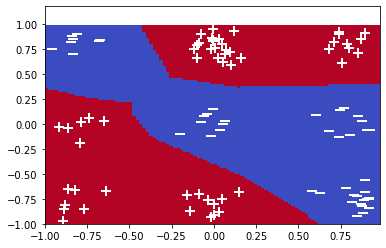

mu = 2.459656500126932


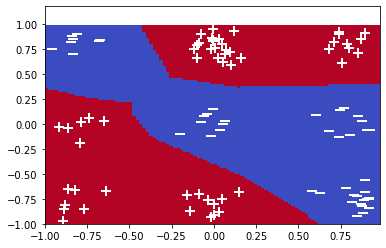

mu = 2.45435011157728


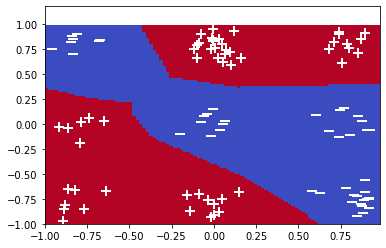

mu = 2.4490561922268963


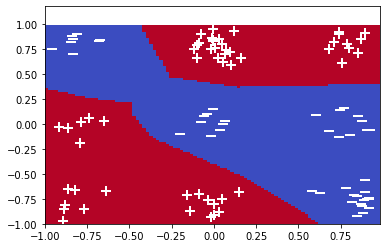

mu = 2.4437749316660957


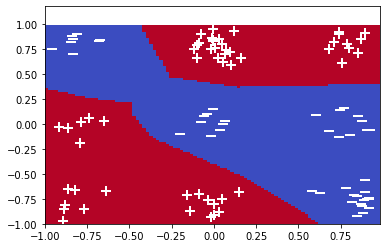

mu = 2.4385062861492632


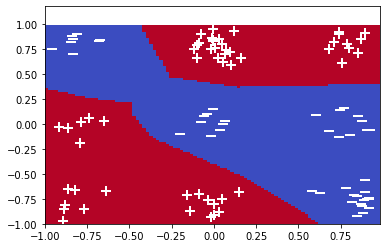

mu = 2.4332500449601335


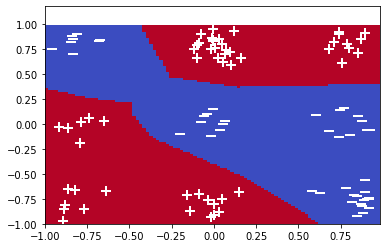

mu = 2.4280063613496075


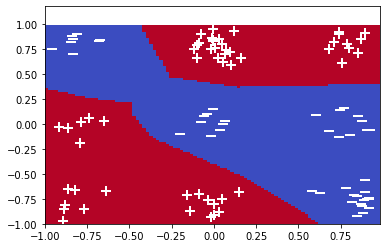

mu = 2.4227750637196404


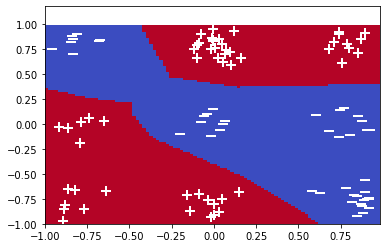

mu = 2.41755635542319


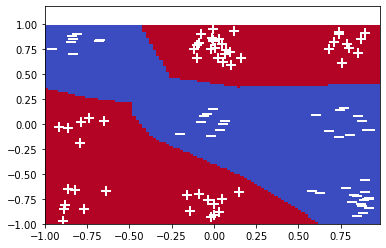

mu = 2.4123498390065623


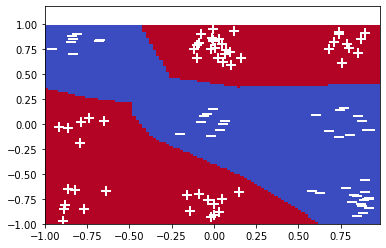

mu = 2.4071557548382385


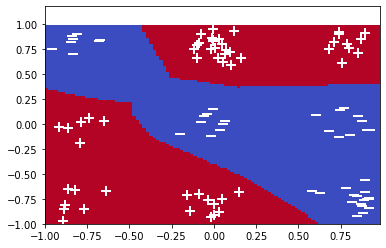

mu = 2.401973895922104


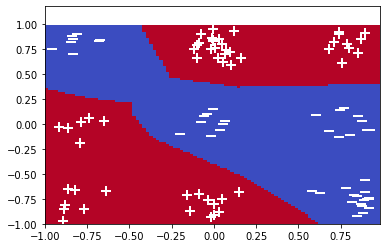

mu = 2.3968043987273253


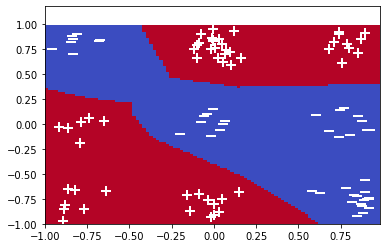

mu = 2.391647136549026


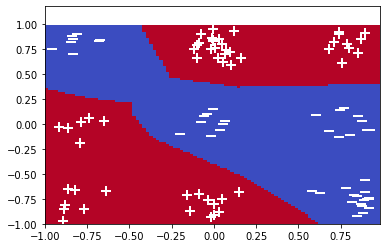

mu = 2.386502031560578


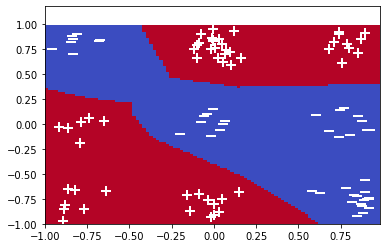

mu = 2.3813691904855387


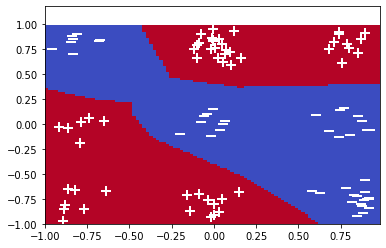

mu = 2.376248516938189


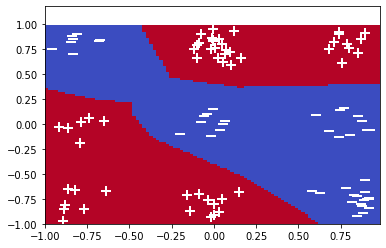

mu = 2.3711398985033294


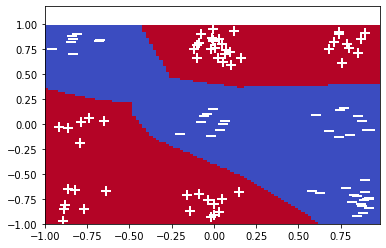

mu = 2.366043323463799


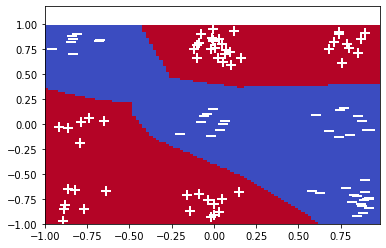

mu = 2.3609588284793377


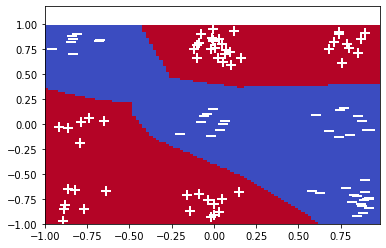

mu = 2.3558863678956925


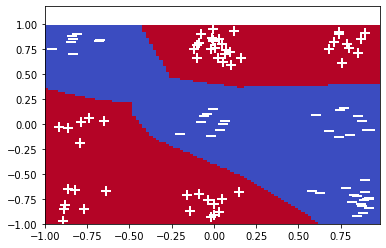

mu = 2.3508259581534987


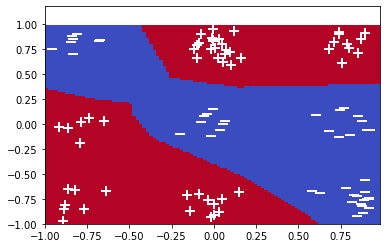

mu = 2.3457773924791354


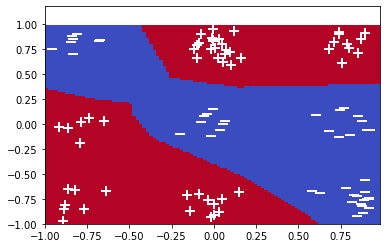

mu = 2.3407408603762128


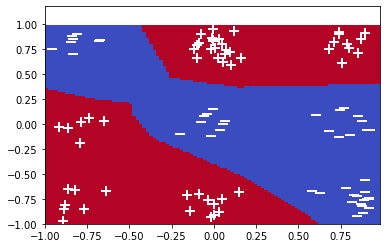

mu = 2.335716140439401


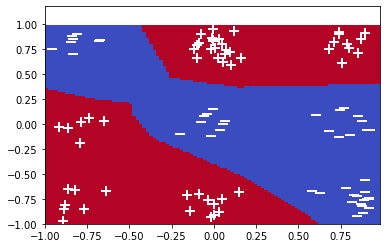

mu = 2.3307032278715263


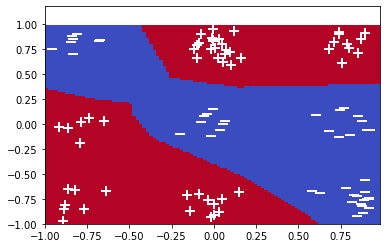

mu = 2.32570221796251


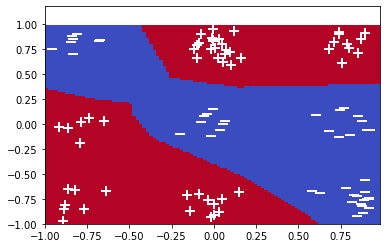

mu = 2.320712948911743


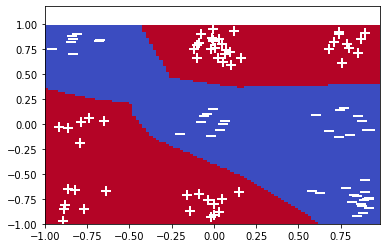

mu = 2.3157355200413194


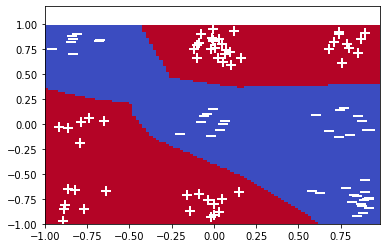

mu = 2.3107698319392513


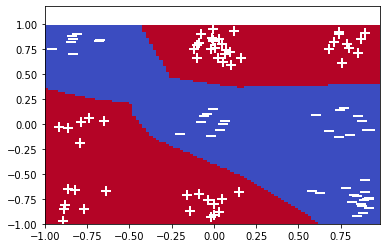

mu = 2.3058157257660454


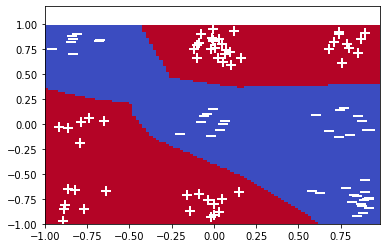

mu = 2.3008733058062103


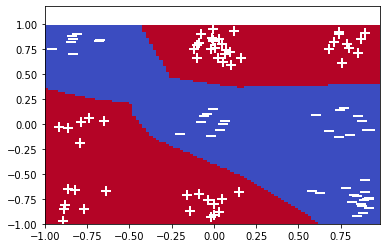

mu = 2.295942625037061


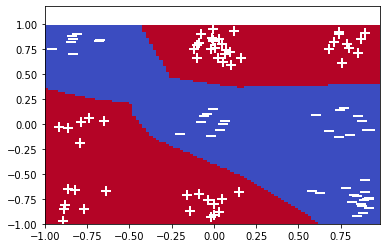

mu = 2.2910234930476454


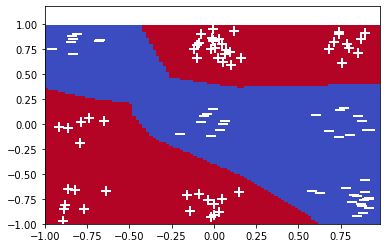

mu = 2.28611593725253


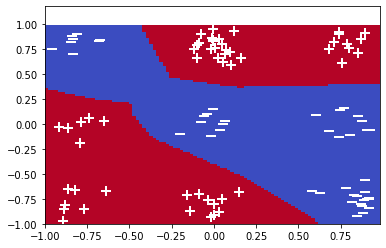

mu = 2.2812198937204795


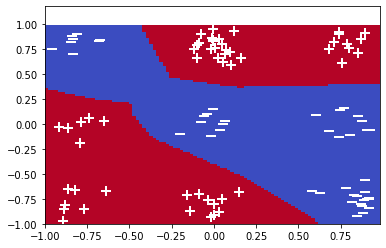

mu = 2.2763354166063205


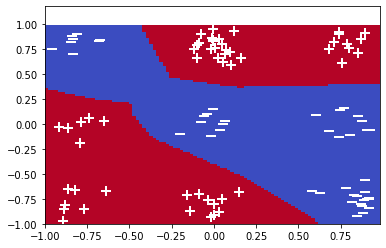

mu = 2.2714623687520263


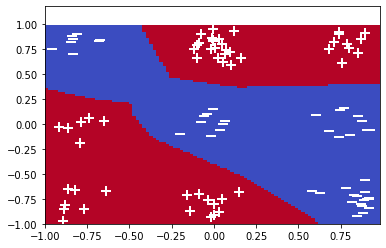

mu = 2.2666007621644755


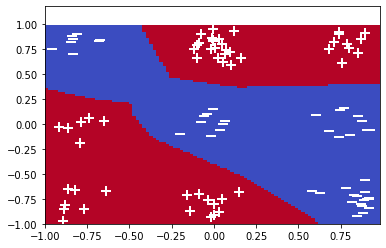

mu = 2.2617506920839023


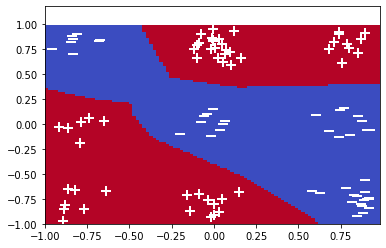

mu = 2.2569118169952067


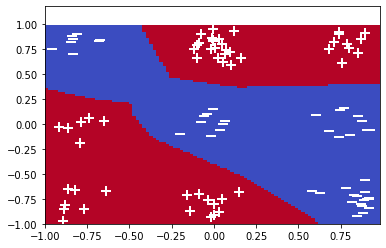

mu = 2.2520844249327334


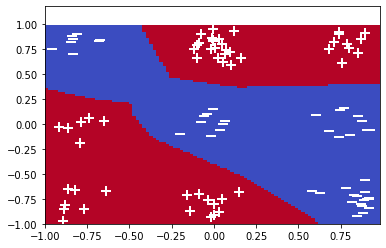

mu = 2.2472683524265635


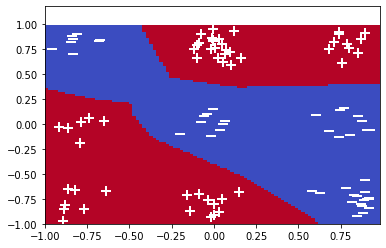

mu = 2.2424636129771134


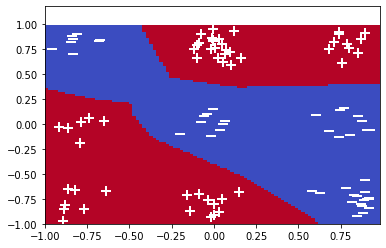

mu = 2.237670038950319


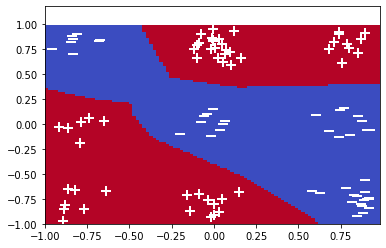

mu = 2.232887754920355


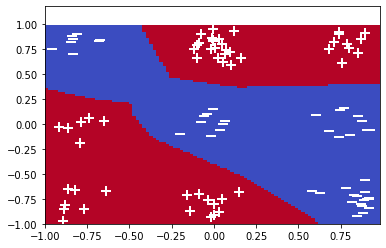

mu = 2.2281167570736513


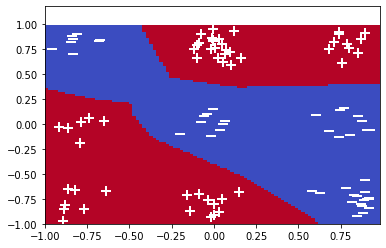

mu = 2.223356876767121


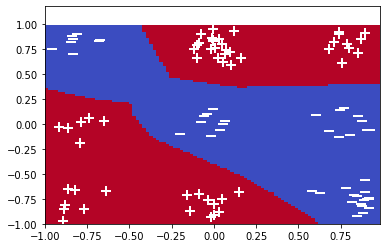

mu = 2.2186081471209462


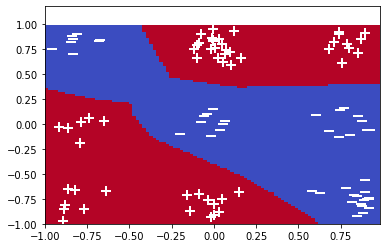

mu = 2.213870579573107


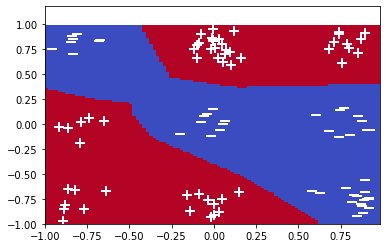

mu = 2.2091439406511713


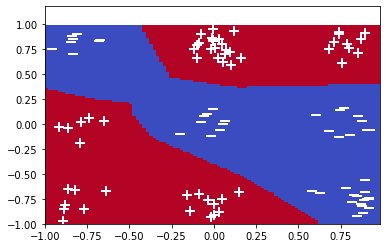

mu = 2.2044285309336793


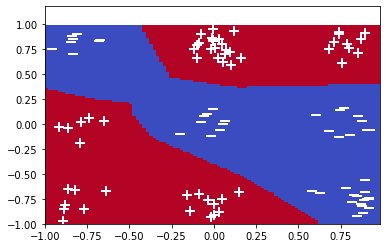

mu = 2.1997240744580875


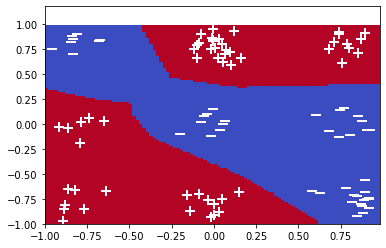

mu = 2.195030598740229


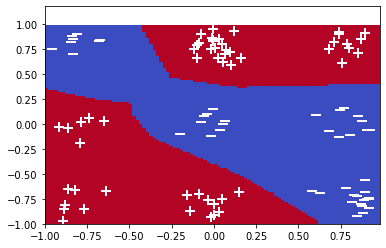

mu = 2.1903482159365986


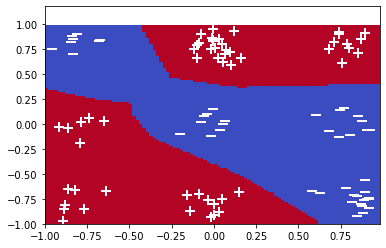

mu = 2.185676701247934


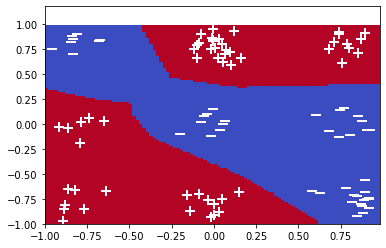

mu = 2.181016108529537


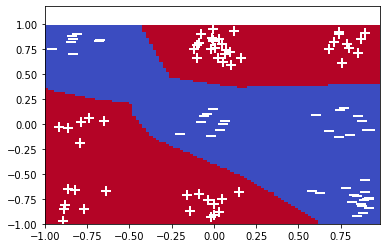

mu = 2.1763663331988283


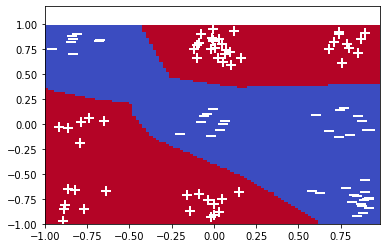

mu = 2.1717275037557155


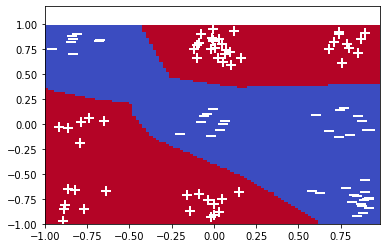

mu = 2.167099454411198


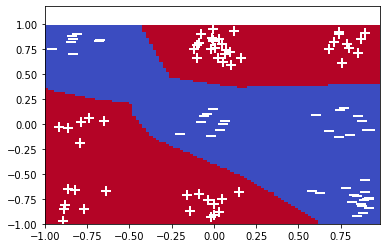

mu = 2.162482206403803


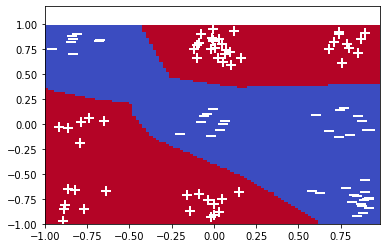

mu = 2.157875753266631


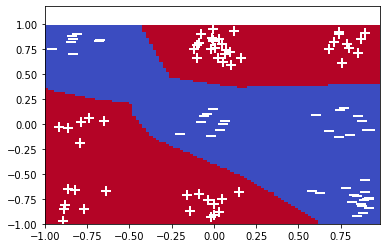

mu = 2.153280041402279


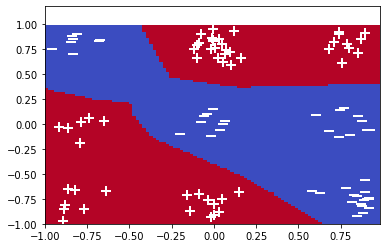

mu = 2.1486950200980015


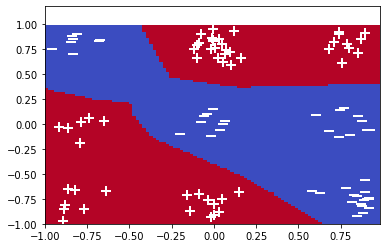

mu = 2.144120728856521


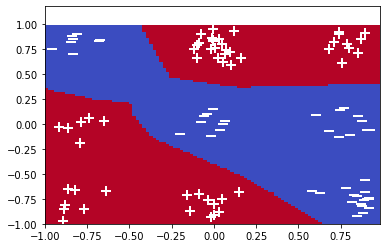

mu = 2.1395570266161346


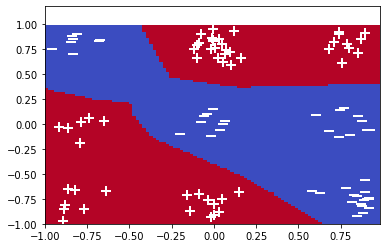

mu = 2.1350039979473543


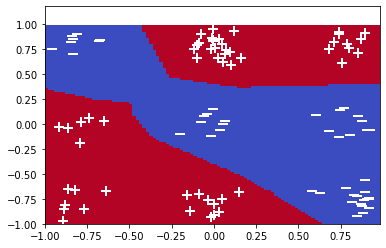

mu = 2.130461580056746


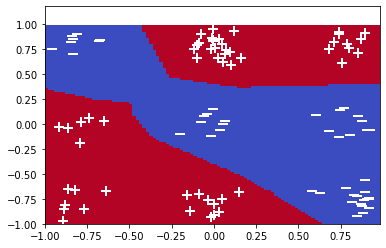

mu = 2.1259297543670925


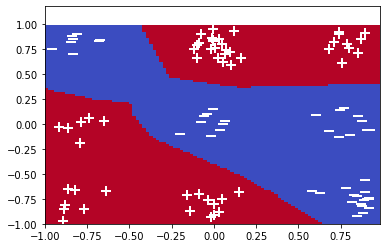

mu = 2.121408463242976


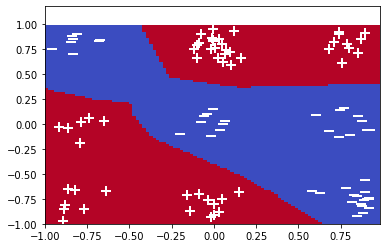

mu = 2.1168976478657013


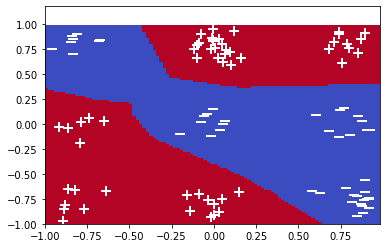

mu = 2.1123972919424827


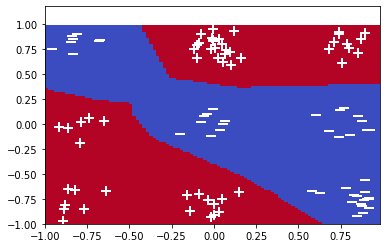

mu = 2.107907489890562


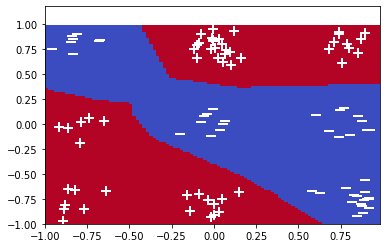

mu = 2.103428113002262


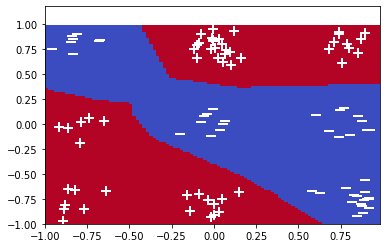

mu = 2.0989590453454774


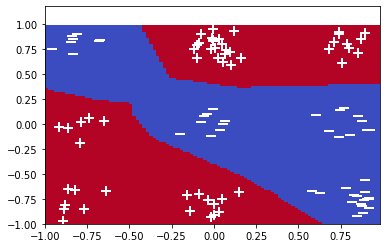

mu = 2.0945004967313765


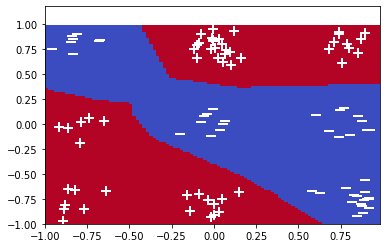

mu = 2.090052209683563


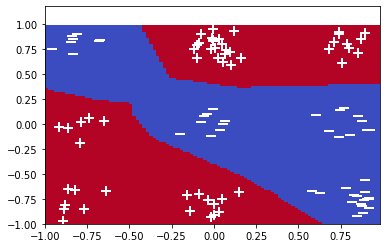

mu = 2.085614315712841


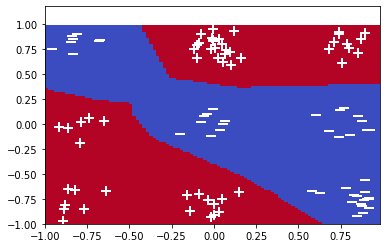

mu = 2.081186611282131


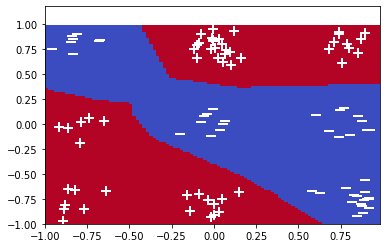

mu = 2.076769291551464


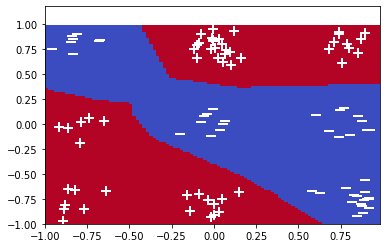

mu = 2.0723621527225005


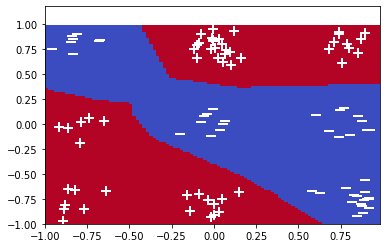

mu = 2.0679652796946626


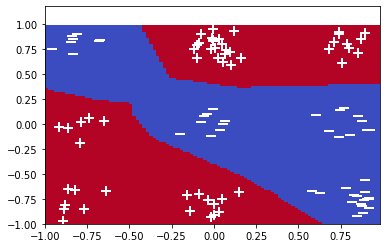

mu = 2.0635785131628497


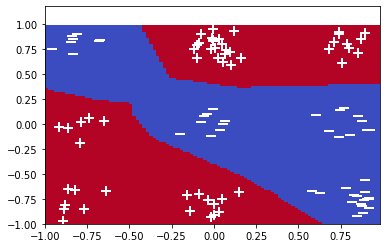

mu = 2.0592019744335794


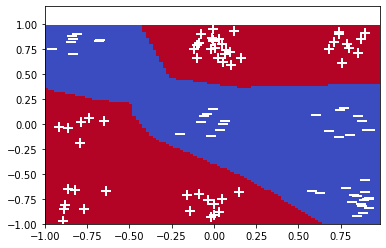

mu = 2.054835572546336


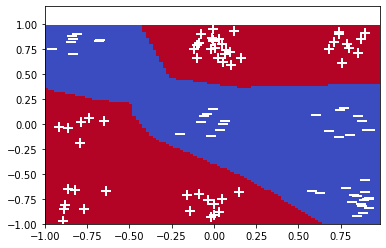

mu = 2.050479257767768


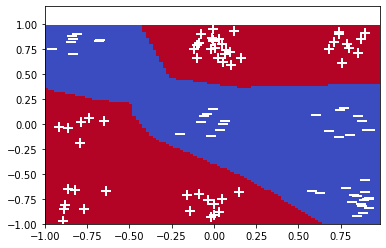

mu = 2.0461331351541876


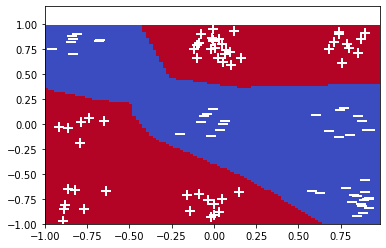

mu = 2.04179692726122


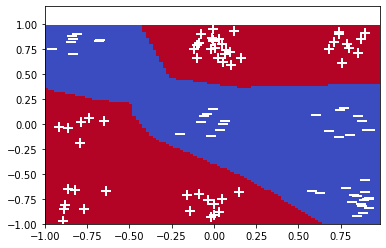

mu = 2.0374708172221263


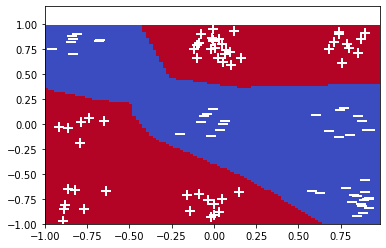

mu = 2.0331547255116442


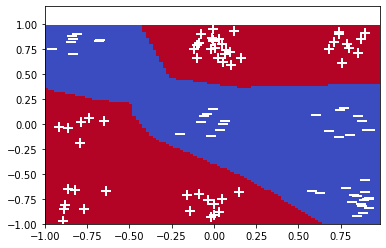

mu = 2.0288485877585942


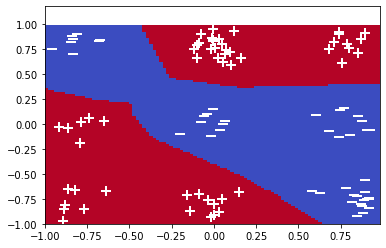

mu = 2.024552359858295


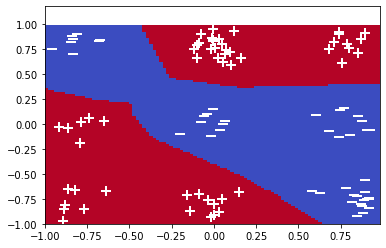

mu = 2.0202661572428275


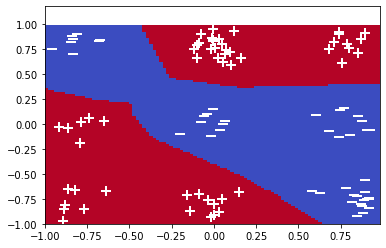

mu = 2.0159898423504994


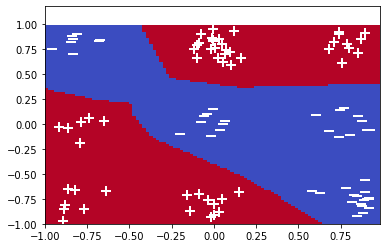

mu = 2.0117233334267377


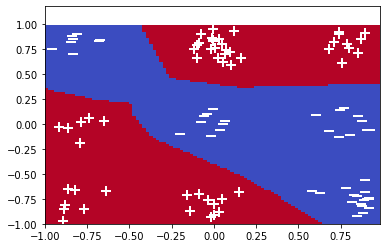

mu = 2.0074666899264093


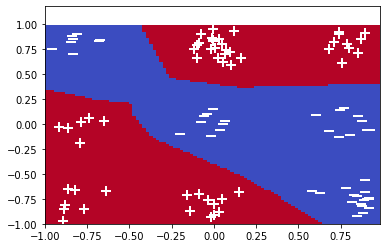

mu = 2.0032199394457164


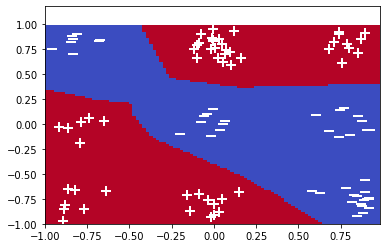

mu = 1.9989830001397249


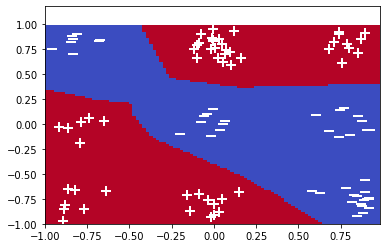

mu = 1.9947556976658887


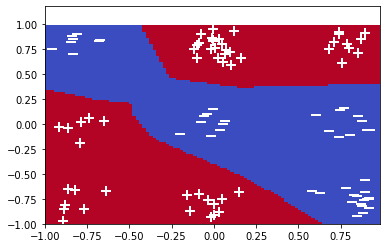

mu = 1.9905382967415723


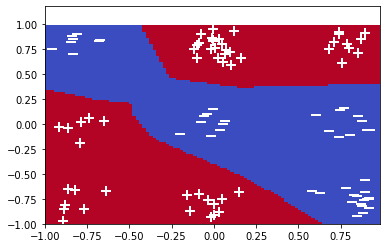

mu = 1.9863305676018406


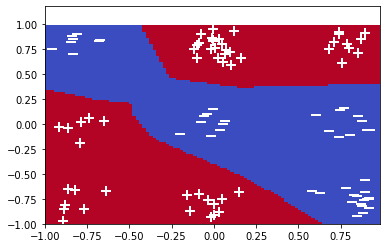

mu = 1.982132491155904


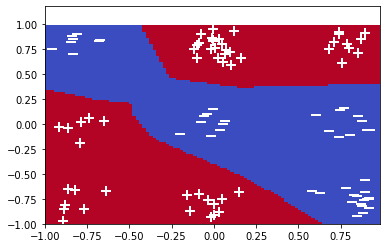

mu = 1.977944082839795


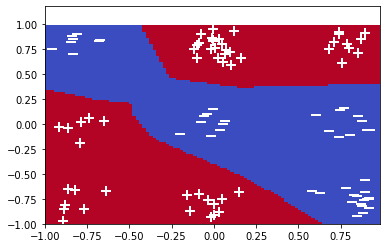

mu = 1.973765378473562


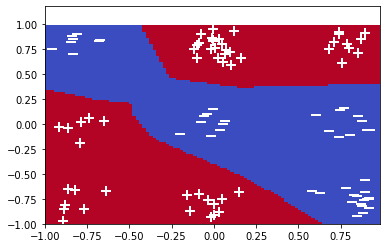

mu = 1.9695962864613408


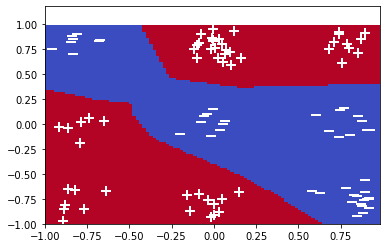

mu = 1.9654368097302872


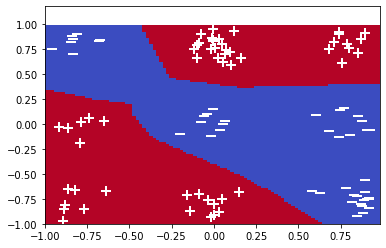

mu = 1.9612869074402934


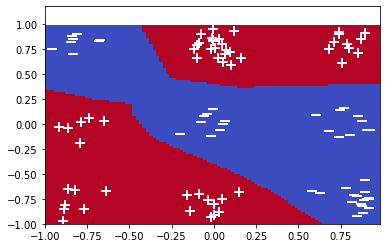

mu = 1.957146550727459


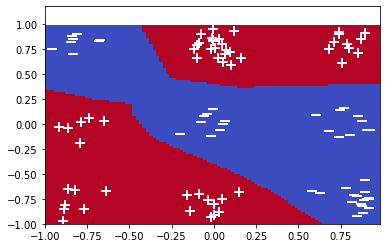

mu = 1.9530156734825264


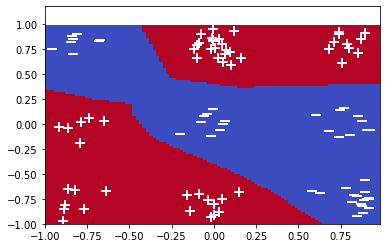

mu = 1.9488942603436343


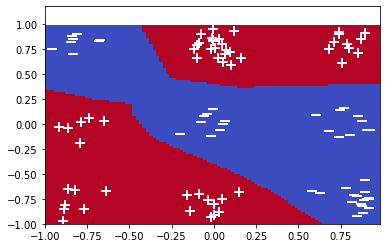

mu = 1.9447823892029554


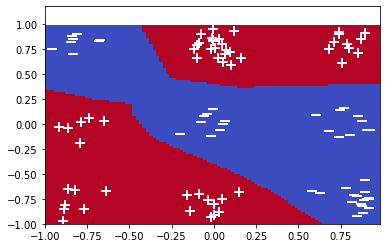

mu = 1.9406799919326805


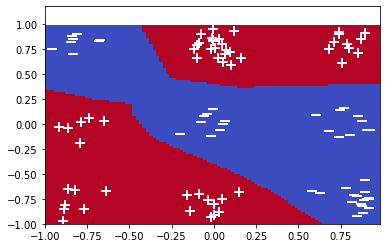

mu = 1.9365869909276343


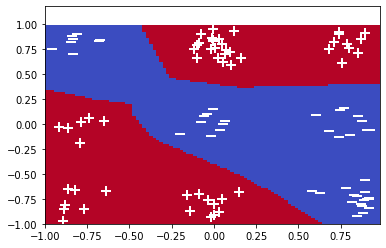

mu = 1.932503383464891


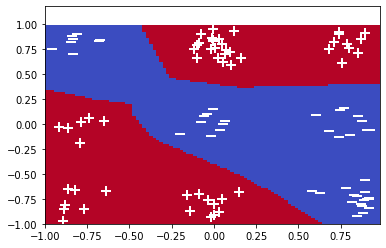

mu = 1.9284291113787506


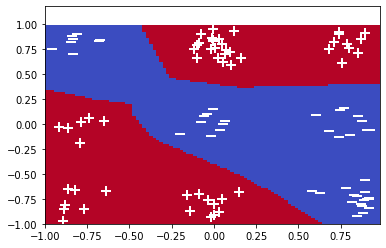

mu = 1.9243642511255832


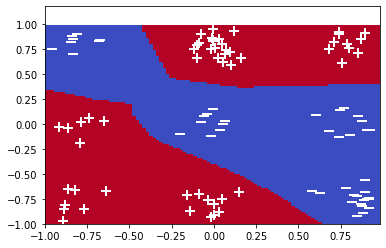

mu = 1.9203087984834222


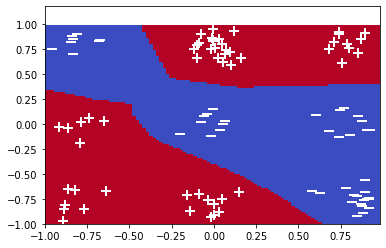

mu = 1.9162625570275784


KeyboardInterrupt: 

In [346]:
num_plots = 1000
idx = 0
for i in range(num_plots):
    print("mu = {}".format(2 * alpha[0]/results['training_loss'][idx]))
    plot_classifier(results['w'][idx], results['a'][idx], x, y)
    idx += len(results['training_loss']) // num_plots    

##### NTK solution

In [336]:
clf = fit_svm_with_tangent_kernel(w_0, a_0, x, y)

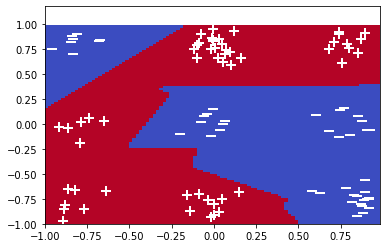

In [337]:
plot_svm_classifier(clf, x, y)

### The Effect of Shape

In [729]:
alpha = [10000] * m
s = [0.95] * (m//4) + [0] * (m//4) + [0.95] * (m//4) + [0] * (m//4)

w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, symmetric=True)

results = train(
    w_0=w_0,
    a_0=a_0,
    x=x,
    y=y,
    m=m,
    d=d,
    alpha=alpha,
    s=s,
    step_size=1e-6,
    n_epochs=10000000,
    eval_freq=1000,
    eval_freq_Q=np.inf)  # don't eval Q

100%|██████████| 1000000/1000000 [00:45<00:00, 21955.18it/s]


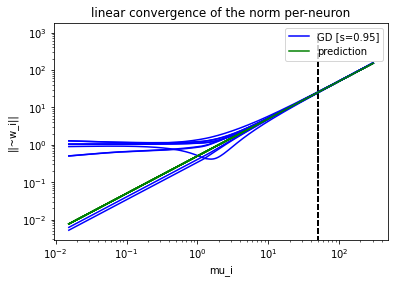

In [44]:
for i in list(range(m//4)) + list(range(m//2, 3*m//4)):
    marker = 'b'
    plot([2 * alpha[i]/t for t in results['training_loss']], [r[i] for r in results['w_tilde_norms']], marker)
    plot([2 * alpha[i]/t for t in results['training_loss']], [alpha[i] / gamma_tilde for gamma_tilde in results['training_loss']], 'g')

    first_perfect_fit_index = np.where(np.array(results['training_accuracy']) == 1.0)[0][5]
    first_perfect_fit_mu = 2 * alpha[i]/results['training_loss'][first_perfect_fit_index]
    vlines(first_perfect_fit_mu, 0, 1e3, linestyles='dashed', color='k')

yscale('log')
xscale('log')
ylabel('||~w_i||');
xlabel('mu_i');
title(f'linear convergence of the norm per-neuron');
legend(['GD [s=0.95]', 'prediction']);

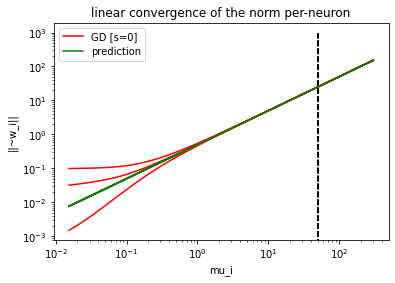

In [47]:
for i in list(range(m//4, m//2)) + list(range(3*m//2, m)):
    marker = 'r'
    plot([2 * alpha[i]/t for t in results['training_loss']], [r[i] for r in results['w_tilde_norms']], marker)
    plot([2 * alpha[i]/t for t in results['training_loss']], [alpha[i] / gamma_tilde for gamma_tilde in results['training_loss']], 'g')

    first_perfect_fit_index = np.where(np.array(results['training_accuracy']) == 1.0)[0][5]
    first_perfect_fit_mu = 2 * alpha[i]/results['training_loss'][first_perfect_fit_index]
    vlines(first_perfect_fit_mu, 0, 1e3, linestyles='dashed', color='k')

yscale('log')
xscale('log')
ylabel('||~w_i||');
xlabel('mu_i');
title(f'linear convergence of the norm per-neuron');
legend(['GD [s=0]', 'prediction']);

##### Show that it respects the bilevel problem

In [15]:
num_reries = 100
num_solutions = 50
L1_solutions  = []

for idx in range(num_reries):
    w_0 = np.random.normal(loc=0, scale=1, size=(m, d))
    a_0 = np.random.normal(loc=0, scale=1, size=(m,))

    w_opt_L1, a_opt_L1 = solver(x, y, w_0, a_0, m, d, obj='L1')
    w_tilde_norms_opt_L1 = calc_w_tilde_norms(w_opt_L1, a_opt_L1)
            
    L1_solutions.append((w_opt_L1, a_opt_L1, np.linalg.norm(w_tilde_norms_opt_L1, ord=1)))
    
best_L1_solutions = sorted(L1_solutions, key=lambda x: x[2])[:num_solutions]
print([s[2] for s in best_L1_solutions])

[7.657164318967731, 7.657164473943626, 7.657164898745095, 7.657164908851735, 7.657165032998077, 7.657166547882116, 7.65716763888743, 7.657168238538107, 7.65716848495901, 7.657168653674948, 7.657168693818799, 7.657169140700396, 7.65716950600279, 7.657169616861299, 7.657171919988432, 7.657171969523526, 7.65717213351127, 7.657172881918566, 7.657172954334529, 7.657179745871977, 7.6571802545610534, 7.657181123583344, 7.657181470862905, 7.657183829032254, 7.657183923807152, 7.657184830293286, 7.657187509020588, 7.65719329992328, 7.657197790321108, 7.657198647349299, 7.657201667559629, 7.657204352071089, 7.657206133656253, 7.657206620859724, 7.657210095198418, 7.657215534316412, 7.657220847657004, 7.657220923676424, 7.657226923281064, 7.657249569420332, 7.657253933219899, 7.657271536497559, 7.657272320475489, 7.657279716633046, 7.6572924654927546, 7.657391870230423, 7.657400536832303, 7.657402313340477, 7.657405303731899, 7.657436024024092]


In [16]:
def lower_level_Q(w, a, gamma, s):
    w_tilde_norms = calc_w_tilde_norms(w, a) / gamma
    f = 0
    for w_tilde_norm_i, s_i in zip(w_tilde_norms, s):
        f += w_tilde_norm_i * (np.log(w_tilde_norm_i) + np.log(2 * (1 - s_i**2)) - 1)
    return f

In [17]:
s = [0.95] * (m//4) + [0] * (m//4) + [0.95] * (m//4) + [0] * (m//4)
score = []
for w, a, _ in best_L1_solutions:
    score.append(lower_level_Q(w, a, gamma=1, s=s))

In [19]:
alpha = [10000] * m
s = [0.95] * (m//4) + [0] * (m//4) + [0.95] * (m//4) + [0] * (m//4)

w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, symmetric=True)

results = train(
    w_0=w_0,
    a_0=a_0,
    x=x,
    y=y,
    m=m,
    d=d,
    alpha=alpha,
    s=s,
    step_size=1e-5,
    n_epochs=10000000,
    eval_freq=100000,
    eval_freq_Q=np.inf)  # don't eval Q

100%|██████████| 10000000/10000000 [07:26<00:00, 22417.03it/s]


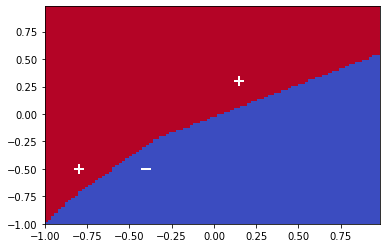

In [20]:
plot_classifier(results['w'][-1], results['a'][-1], x, y)

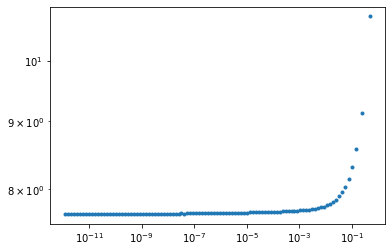

In [21]:
plot([2 * alpha[0]/t for t in results['training_loss']], [np.linalg.norm(r, ord=1) for r in results['w_tilde_norms']], '.')
yscale('log')
xscale('log')

In [27]:
min(score)

-15.862482181514478

In [22]:
w_tilde_norms = calc_w_tilde_norms(results['w'][-1], results['a'][-1])
gamma = minimal_margin(results['w'][-1], results['a'][-1], x, y)
np.linalg.norm(w_tilde_norms, ord=1) / gamma

7.659533234868689

In [23]:
GD_score = lower_level_Q(results['w'][-1], results['a'][-1], gamma, s)
GD_score

-17.82024275106976

In [24]:
def cosine_sim(u, v):
    return np.dot(u.reshape(-1,), v.reshape(-1,)) / np.linalg.norm(u) / np.linalg.norm(v)

In [25]:
cosin_sims = [cosine_sim(calc_w_tilde_norms(results['w'][-1], results['a'][-1]), calc_w_tilde_norms(w, a)) for w, a, _ in best_L1_solutions]

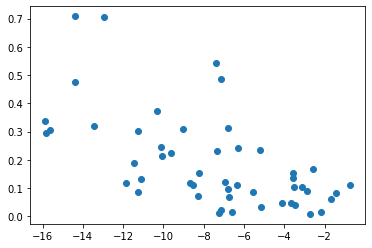

In [26]:
scatter(score, cosin_sims)

### Sparsity of the L1 solution based on the shape

In [19]:
out = {}
imbalanced_s = [0] * (m - 4) + [0.95] * (4)
balanced_s_0 = [0] * m
balanced_s_0_95 = [0.95] * m

for s in [imbalanced_s, balanced_s_0, balanced_s_0_95]:
    for try_ in range(3):
        alpha = [10000] * m
        mu = [1e-6] * m

        try:
            w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, symmetric=False)
            w_opt_Q, a_opt_Q = solver(
                        x,
                        y,
                        w_0,
                        a_0,
                        m,
                        d,
                        obj='Q',
                        mu=mu,
                        s=s,
                        x0=np.random.normal(size=(m * (d + 1),)),
                        optim_tol=1e-7
                    )
            out.setdefault(str(s), []).append((w_opt_Q, a_opt_Q))
        except Exception as e:
            print(e)
            pass

Minimization Failed.
Minimization Failed.
Minimization Failed.


In [20]:
for k, v in out.items():
    print(k)
    for w, a in v:
        gamma = minimal_margin(w, a, x, y)
        norms = calc_w_tilde_norms(w, a) / gamma
        print(np.linalg.norm(norms, ord=2) / np.linalg.norm(norms, ord=1), np.linalg.norm(norms, ord=1))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.95, 0.95, 0.95, 0.95]
0.391855926123914 7.670330907257535
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
0.25093439583053384 7.747967456126296
0.242863926414476 7.746014444820867
0.2623638893743381 7.755822567011774
[0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]
0.2264498051188318 7.661425046179082
0.24261213604575474 7.775052111496967


In [22]:
alpha = [10000] * m

GD_shape_results = {}
for s in [imbalanced_s, balanced_s_0, balanced_s_0_95]:

    w_0, a_0 = symmetric_init(alpha=alpha, s=s,  m=m, d=d, symmetric=False)

    results = train(
        w_0=w_0,
        a_0=a_0,
        x=x,
        y=y,
        m=m,
        d=d,
        alpha=alpha,
        s=s,
        step_size=1e-6,
        n_epochs=50000000,
        eval_freq=100000,
        eval_freq_Q=np.inf)  # don't eval Q
    
    GD_shape_results[str(s)] = results

100%|██████████| 50000000/50000000 [36:30<00:00, 22824.82it/s]


In [27]:
for k, v in GD_shape_results.items():
    print(k)
    print([2 * alpha[0]/t for t in v['training_loss']][-1])
    norms = v['w_tilde_norms'][-1]
    print(np.linalg.norm(norms, ord=2) / np.linalg.norm(norms, ord=1), np.linalg.norm(norms, ord=1))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.95, 0.95, 0.95, 0.95]
3.6624269201334095e-06
0.6292385596289626 7.847874009247869
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
6.19859731920569e-06
0.3301923419306498 7.720908468135272
[0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95]
2.79952739134916e-07
0.3001447938005279 7.691582228241062


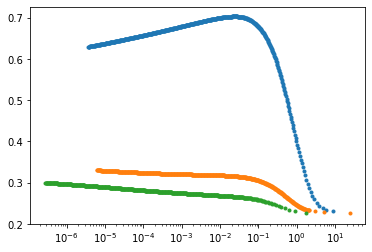

In [43]:
r_s = GD_shape_results[list(GD_shape_results.keys())[0]]
plot([2 * alpha[0]/t for t in r_s['training_loss']], [np.linalg.norm(norms, ord=2) / np.linalg.norm(norms, ord=1) for norms in r_s['w_tilde_norms']], '.')
r_s = GD_shape_results[list(GD_shape_results.keys())[1]]
plot([2 * alpha[0]/t for t in r_s['training_loss']], [np.linalg.norm(norms, ord=2) / np.linalg.norm(norms, ord=1) for norms in r_s['w_tilde_norms']], '.')
r_s = GD_shape_results[list(GD_shape_results.keys())[2]]
plot([2 * alpha[0]/t for t in r_s['training_loss']], [np.linalg.norm(norms, ord=2) / np.linalg.norm(norms, ord=1) for norms in r_s['w_tilde_norms']], '.')
#plot([2 * alpha[0]/t for t in r_s['training_loss']], [np.linalg.norm(norms, ord=1) for norms in r_s['w_tilde_norms']], '.')
#yscale('log')
xscale('log')

### Plot q_s

Text(0.5, 1.0, 'q_s')

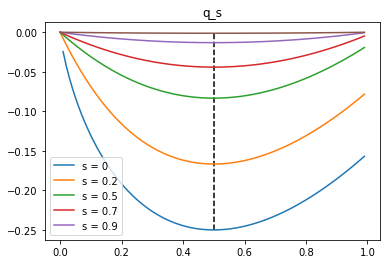

In [96]:
mu = 1
x = list(np.arange(0, mu, 0.01))
for s in [0, 0.2, 0.5, 0.7, 0.9, 0.99]:
    plot(x, list(map(lambda x: q_func(x/mu, s), x)))
    
vlines(0.5, -0.25, 0, linestyles='dashed')
legend([f's = {k}' for k in [0, 0.2, 0.5, 0.7, 0.9]])
title('q_s')